In [1]:
# -*- coding: utf-8 -*-
import warnings
import os.path
import sys
import pickle
import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import ow_f01, cxmn_train, cxmn_predict, predict_mean
from code.refactor.common import loadSettingsFromYamlFile, save_object, object2Float, get_column_by_type

warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [3]:
p1_used_header = ['productkey', 'promotionkey', 'startdatetime', 'enddatetime', 'jdprice', 'syntheticgrossprice', 'promotiondesc', 'promotiondesc_flag', 'promotiontype', 'promotionsubtype',
                'areatypearray', 'tokenflag', 'directdiscount_discount', 'directdiscount_availabilitynumber', 'bundle_subtype1_threshold', 'bundle_subtype1_giveaway',
                'bundle_subtype4_threshold1', 'bundle_subtype4_giveaway1', 'bundle_subtype4_threshold2', 'bundle_subtype4_giveaway2', 'bundle_subtype4_threshold3',
                'bundle_subtype4_giveaway3', 'bundle_subtype2_threshold', 'bundle_subtype2_giveaway', 'bundle_subtype2_maximumgiveaway', 'bundle_subtype15_thresholdnumber1',
                'bundle_subtype15_giveawayrate1', 'bundle_subtype15_thresholdnumber2', 'bundle_subtype15_giveawayrate2', 'bundle_subtype15_thresholdnumber3',
                'bundle_subtype15_giveawayrate3', 'bundle_subtype6_thresholdnumber', 'bundle_subtype6_freenumber', 'suit_maxvaluepool', 'suit_minvaluepool', 'suit_avgvaluepool',
                'suit_discount', 'directdiscount_saleprice', 'bundle_subtype1_percent', 'bundle_subtype4_percent', 'bundle_subtype2_percent', 'bundle_subtype15_percent',
                'bundle_subtype6_percent', 'suit_percent', 'allpercentdiscount', 'mainproductkey', 'hierarchylevel3key', 'createdate', 'statuscode', 'dt']
p2_used_header = ['ProductKey', 'Date', 'HierarchyLevel3Key', 'PromotionCount', 'bundlecount', 'MaxDiscount', 'MinDiscount', 'AvgDiscount', 'MaxSyntheticDiscountA',
				         'MinSyntheticDiscountA', 'AvgSyntheticDiscountA', 'MaxBundleDiscount', 'MinBundleDiscount', 'AvgBundleDiscount', 'MaxDirectDiscount', 'MinDirectDiscount',
				         'AvgDirectDiscount', 'MaxFreegiftDiscount', 'MinFreegiftDiscount', 'AvgFreegiftDiscount', 'SyntheticGrossPrice', 'promotionkey', 'promotiontype',
				         'promotionsubtype', 'syntheticgrossprice_vb', 'jdprice', 'syntheticdiscounta_vb', 'durationinhours', 'daynumberinpromotion', 'bundleflag', 'directdiscountflag',
				         'freegiftflag', 'suitflag', 'numberproducts', 'numberhierarchylevel1', 'numberhierarchylevel2', 'numberhierarchylevel3', 'strongmark', 'stockprice', 'dt']
suffix = '.da'
item = 'p1'
for_what = ['train', 'predict']

In [4]:
def statitics_mape(new_df_final):
		new_df_sku = new_df_final.groupby('ProductKey').sum().reset_index()
		print "ensemble pred sum : %f"%(new_df_sku.ypred_mean_promo_new.sum())
		print "raw pred sum :      %f"%(new_df_sku.ypred_raw.sum())
		print "actual sum:         %f"%(new_df_sku.salesForecast.sum())

		print "raw pred residual:      %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)))
		print "ensemble pred residual: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)))

		print "raw pred mape: %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())
		print "ensemble mape: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())

In [5]:
def get_online_history_data():
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p1.da',sep='\t',header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p2.da',sep='\t',header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_ts.da',sep='\t',header=None)
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p1.da', sep='\t', header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p2.da', sep='\t', header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_ts.da', sep='\t', header=None)
    p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p1.da', sep='\t', header=None)
    p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p2.da', sep='\t', header=None)
    ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_ts.da', sep='\t', header=None)
    # p1 = pd.read_csv('./diannaobangong/700_p1.csv', sep='\t', header=None)
    # p2 = pd.read_csv('./diannaobangong/700_p2.csv', sep='\t', header=None)
    # ts = pd.read_csv('./diannaobangong/700_ts.csv', sep='\t', header=None)
    # p1 = pd.read_csv('./diannaobangong/7371_p1.csv', sep='\t', header=None)
    # p2 = pd.read_csv('./diannaobangong/7371_p2.csv', sep='\t', header=None)
    # ts = pd.read_csv('./diannaobangong/7371_ts.csv', sep='\t', header=None)
    return p1,p2,ts


In [6]:
scenarioSettingsPath = 'code/refactor/ow_scenario.yaml'
scenario = loadSettingsFromYamlFile(scenarioSettingsPath)
area_rdc_map = pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/area_rdc_mapping.csv')
holidays_df=pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/holidays.csv')
seasonality_df = pd.read_csv('tmp/data/870_season.csv', parse_dates=['Date'])

In [7]:
cate =  736 # 7371 700 736
valid_date = pd.to_datetime('2018-04-10')
pred_date = pd.to_datetime('2018-05-08')
scenario['lookforwardPeriodDays'] = 28
# cate = 7054
# valid_date = pd.to_datetime('2018-01-04')
# pred_date = pd.to_datetime('2018-02-01')
# scenario['lookforwardPeriodDays'] = 28

# cate = 12029
# pred_date = pd.to_datetime('2018-05-07')
# scenario['lookforwardPeriodDays'] = 7


In [8]:
p1_df,p2_df,ts_df = get_online_history_data()

In [9]:
p1_df.columns = p1_used_header
p2_df.columns = p2_used_header


In [10]:
ts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2018-07-28,0,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
1,2018-07-27,1,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
2,2018-07-26,2,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
3,2018-07-25,3,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
4,2018-07-24,4,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0


In [11]:
print p2_df.Date.min()
print p2_df.Date.max()

2015-01-01
2018-07-27


In [12]:
###handle p2
p2_df['Date'] = pd.to_datetime(p2_df['Date'])
p2_df['dt'] = pd.to_datetime(p2_df['dt'])
p2_df.replace('null', np.nan, inplace=True)
p2_df.replace('None', np.nan, inplace=True)
p2_df.replace(-999, np.nan, inplace=True)
p2_df.drop_duplicates(inplace=True)

# Convert Object -> float
if 'object' in p2_df.dtypes.values:
    obj_cols = get_column_by_type(p2_df,'object')
    object2Float(p2_df,obj_cols)


convert to Float columns:
MaxSyntheticDiscountA
convert to Float columns:
MinSyntheticDiscountA
convert to Float columns:
AvgSyntheticDiscountA
convert to Float columns:
SyntheticGrossPrice
convert to Float columns:
promotionkey
convert to Float columns:
promotiontype
convert to Float columns:
promotionsubtype
convert to Float columns:
syntheticgrossprice_vb
convert to Float columns:
jdprice
convert to Float columns:
syntheticdiscounta_vb
convert to Float columns:
durationinhours
convert to Float columns:
daynumberinpromotion
convert to Float columns:
bundleflag
convert to Float columns:
directdiscountflag
convert to Float columns:
freegiftflag
convert to Float columns:
suitflag
convert to Float columns:
stockprice


In [13]:
def handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario):
    for fw in for_what:
    	print "output and save: %s_p1_%s"%(str(cate),fw)
    	train_pred_gate = fw   # 'train'
    	f01_output = ow_f01.generate_f01_promo(area_rdc_map, p1_df, scenario, train_pred_gate, ForecastStartDate=pred_date)
    	if train_pred_gate == 'train':
    		train_p1_df = f01_output
    	else:
    		predict_p1_df = f01_output
    return train_p1_df, predict_p1_df
train_p1_df_valid,predict_p1_df_valid = handle_f01(p1_df, for_what, area_rdc_map, valid_date, scenario)


output and save: 736_p1_train
convert to Float columns:
allpercentdiscount
convert to Float columns:
bundle_subtype15_giveawayrate1
convert to Float columns:
bundle_subtype15_giveawayrate2
convert to Float columns:
bundle_subtype15_giveawayrate3
convert to Float columns:
bundle_subtype15_percent
convert to Float columns:
bundle_subtype15_thresholdnumber1
convert to Float columns:
bundle_subtype15_thresholdnumber2
convert to Float columns:
bundle_subtype15_thresholdnumber3
convert to Float columns:
bundle_subtype1_giveaway
convert to Float columns:
bundle_subtype1_percent
convert to Float columns:
bundle_subtype1_threshold
convert to Float columns:
bundle_subtype2_giveaway
convert to Float columns:
bundle_subtype2_maximumgiveaway
convert to Float columns:
bundle_subtype2_percent
convert to Float columns:
bundle_subtype2_threshold
convert to Float columns:
bundle_subtype4_giveaway1
convert to Float columns:
bundle_subtype4_giveaway2
convert to Float columns:
bundle_subtype4_giveaway3
con

/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
code/refactor/common.py:2111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  period_promo_raw['rdc_list'] = period_promo_raw['areatypearray'].apply(lambda x: extract_rdc(x, area_rdc_dict))
/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

('| - Before filter: ', 108374)
('| - Filtered tokens: ', 107780)
('| - Filtered descriptions: ', 107170)
('| - Filtered flash sale available units', 107168)
('| - Filtered non-national promo: ', 107168)
| | - Add additional columns
| | - Calculate dd price per promotion
| | - Calculate dd price per period
| | - Generate bundle features
| | - Calculate bundle price per period
| - Reformat date
| | - process features
| | - aggregate features per period
| | - prep data for Step 3
| | - fix indicators on days with end time 00:00 or start time 23:59
| | - calculate weighted price per day
| | - aggregate features per day
f01 shape
(821530, 23)
output and save: 736_p1_predict
('| - Before filter: ', 13964)
('| - Filtered tokens: ', 13791)
('| - Filtered descriptions: ', 13649)
('| - Filtered flash sale available units', 13634)
('| - Filtered non-national promo: ', 13634)
| | - Add additional columns
| | - Calculate dd price per promotion
| | - Calculate dd price per period
| | - Generate bun

In [14]:
print train_p1_df_valid.shape
print predict_p1_df_valid.shape

(821530, 23)
(290497, 23)


In [15]:
train_p1_df,predict_p1_df = handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario)

output and save: 736_p1_train


KeyboardInterrupt: 

In [16]:
print train_p1_df.shape
print predict_p1_df.shape

NameError: name 'train_p1_df' is not defined

In [17]:
print predict_p1_df_valid.Date.max()
print predict_p1_df_valid.Date.min()
print predict_p1_df.Date.max()
print predict_p1_df.Date.min()

2019-01-01 00:00:00
2014-10-01 00:00:00
2019-01-01 00:00:00
2014-10-01 00:00:00


In [17]:
ts_df.columns = ['Date', 'ind', 'RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
ts_df['Date'] = pd.to_datetime(ts_df['Date'])

ts_df.replace('null', np.nan, inplace=True)
ts_df.replace(-999, np.nan, inplace=True)
ts_df.replace('None', np.nan, inplace=True)
ts_to_float_col = ['RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
if 'object' in ts_df[ts_to_float_col].dtypes.values:
    object2Float(ts_df,ts_to_float_col)


levels = ['HierarchyLevel3Key','ProductKey','RDCKey','Date']
ts_df.sort_values(levels, ascending=[True]*len(levels), inplace=True)
ts_df= ts_df.reset_index(drop=True)

In [18]:
ts_df_bak = ts_df.copy()

In [19]:
print ts_df.Date.min()
print ts_df.Date.max()

2015-04-18 00:00:00
2018-07-28 00:00:00


In [20]:
# -*- coding: utf-8 -*-
import warnings
import os.path
from code.refactor.common import (get_setting_from_cfg, get_setting_path, filter_df_by_cate_id,get_future_sales_feature,\
                                  dummy_features, model_predict, get_weekly_df,get_future_condition_sales_feature,gen_train_valid_by_date,\
                                  generate_promotion_future, get_hour, save_object, add_pv,get_lowest_n,generate_cv_train_valid_set,\
                                  generate_default_values_by_dic,fill_col_with_default, week2month,trans_band_to_int,get_future_condition_sales_feature_stage2,\
                                  loadSettingsFromYamlFile,createSeasonalityFeatures,createLevel3Features,createSeasonalityDecomposeFeatures,\
                                 calculateNationalRolling,calculateRolling,calculateLagging,createDateFeatures,splitTimeWindow,calculateSimilarRolling,calculateStockFeatures,\
                                 process_rdc,clean_data,add_cols,get_dd_price,agg_dd_price,get_bundle_feat,agg_bd_price,process_feature,\
                                 agg_feature,prep_data,calc_weighted_price,agg_feature_day,get_column_by_type,object2Float,object2Int)
from code.refactor.fdc_flow import  filter_non_price_fill_it
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
ForecastStartDate = pd.to_datetime(valid_date)
print scenario['lookbackPeriodDays']

400


In [22]:
print ForecastStartDate

2018-04-10 00:00:00


In [23]:
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays'])

In [24]:
print DataStartDate

2017-03-06 00:00:00


In [25]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
object2Int(holidays_df,['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212'])
for col in area_rdc_map.columns:
    area_rdc_map[col] = area_rdc_map[col].astype('int')
period_promo_raw = train_p1_df_valid
promoCalendarDf = p2_df

convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212


In [26]:
promoCalendarDf = promoCalendarDf[(promoCalendarDf['Date']<ForecastStartDate)&(promoCalendarDf['Date']>DataStartDate)]

ts_df_pred = ts_df[(ts_df['Date']<ForecastStartDate)&(ts_df['Date']>DataStartDate)]


period_promo_raw.drop_duplicates(inplace=True)
promo_period = period_promo_raw


In [27]:
raw_df= ts_df_pred[ts_df_pred['Date']<ForecastStartDate]


''' initialization'''
if 'ind' in raw_df.columns.values:
    del raw_df['ind']
groupKeys = scenario['selectedColumns']['levelsCoarse'] # ['HierarchyLevel3Key','ProductKey','RDCKey']

In [28]:
min_dt_record = raw_df.groupby(groupKeys)['Date'].min().reset_index(name='dt_min')
min_dt_onstock_record = raw_df[raw_df.counterState==1].groupby(groupKeys)['Date'].min().reset_index(name='dt_onstock_min')
merged_min_dt = pd.merge(min_dt_record,min_dt_onstock_record,on=groupKeys)
valid_merged_min_dt = merged_min_dt[merged_min_dt.dt_min ==merged_min_dt.dt_onstock_min]

raw_df = pd.merge(raw_df, valid_merged_min_dt[groupKeys+['dt_onstock_min']],how='left',on=groupKeys)
raw_df.reset_index(drop=True,inplace=True)
''' fillZeroRows '''
raw_df= filter_non_price_fill_it(raw_df, scenario, price_col_ts='priceAfterDiscount')

In [29]:
q = scenario['quantile'] # 0.95

unitVolumeQuantile = raw_df.groupby(groupKeys)[scenario['Target_col']].quantile(q, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {scenario['Target_col']: 'UnitCapVolume'}, inplace=True)

# join quantile
raw_df= pd.merge(raw_df, quantileDf, how='left', on=groupKeys)
raw_df['OrderNonOutlierVolume'] = raw_df[['salesForecast', 'UnitCapVolume']].min(axis=1)

# drop cap volume
raw_df.drop(['UnitCapVolume'], axis=1, inplace = True)
if True:
    f = lambda x: x.shift(1).fillna(method='bfill')
    raw_df[['counterState1']] = raw_df[['counterState','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)
    raw_df[['vendibility1']] = raw_df[['vendibility','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)

featuresDf = raw_df


In [30]:
featuresDf.Date.max()

Timestamp('2018-04-09 00:00:00')

In [31]:
if seasonality_df is None:
    if (ts_df_pred.Date.max() - ts_df_pred.Date.min()).days > 730:
        print 'running Seasonality'
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key', 'ProductKey'], 'sku', scenario)
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key'], 'level3', scenario)

        '''
            createLevel3Features
        '''
        featuresDf = createLevel3Features(featuresDf,scenario)
    else:
        print 'faking Seasonality Due to less 2 year Data'
        featuresDf['skuDecomposedTrend'],featuresDf['skuDecomposedSeasonal'],featuresDf['level3DecomposedTrend'],featuresDf['level3DecomposedSeasonal'],featuresDf['Curve'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
else:
    if 'OrderNonOutlierVolume' in seasonality_df.columns:
        seasonality_df.drop(['OrderNonOutlierVolume'], axis=1, inplace = True)
    featuresDf = pd.merge(featuresDf,seasonality_df,on=['HierarchyLevel3Key','ProductKey','Date','RDCKey'],how='left')
'''加入Holiday '''

'\xe5\x8a\xa0\xe5\x85\xa5Holiday '

In [32]:
featuresDf = pd.merge(featuresDf, holidays_df, on='Date', how='left')
'''
    createDateFeatures
'''
featuresDf = createDateFeatures(featuresDf)

'''
    rolling part, 28min, too slow!
'''

featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])],   left_on = ['ProductKey', 'Date'], right_on = ['ProductKey', 'Date'], how='left')
if scenario['STOCK_PRICE_FLAG']:
    featuresDf = calculateStockFeatures(featuresDf)


featuresDf = calculateNationalRolling(featuresDf, scenario, scenario['selectedColumns']['target'])
featuresDf = calculateRolling(featuresDf, scenario, scenario['selectedColumns']['target'])
featuresDf = calculateSimilarRolling(featuresDf, scenario, scenario['Target_col'])
featuresDf = calculateLagging(featuresDf, scenario, scenario['Target_col'])

featuresDf = pd.merge(featuresDf,  promo_period,on = ['ProductKey', 'Date'], how = 'left')

| Add date features...
| - Add month of the year...
| - Add day of the week...
| Calculating national rolling features...
('| - Rolling value:', 'xxxHashColumn')
| - Rolling 14 mean...
| - Rolling 7 mean...
| - Rolling 5 mean...
| - Rolling 3 mean...
| - Rolling 2 mean...
| - Rolling 1 mean...
| - Rolling 14 median...
| - Rolling 7 median...
| - Rolling decay 28 mean...
| - Rolling decay 14 mean...
| - Rolling decay 7 mean...
| - Rolling decay 3 mean...
| - Added rolling features in 67.424814 seconds 

| Calculating  rolling features...
('| - Rolling value:', 'OrderNonOutlierVolume')
| - Rolling 360 mean...
| - Rolling 180 mean...
| - Rolling 90 mean...
| - Rolling 28 mean...
| - Rolling 14 mean...
| - Rolling 7 mean...
| - Rolling 5 mean...
| - Rolling 3 mean...
| - Rolling 2 mean...
| - Rolling 1 mean...
| - Rolling 14 median...
| - Rolling 7 median...
| - Rolling decay 360 mean...
| - Rolling decay 180 mean...
| - Rolling decay 90 mean...
| - Rolling decay 28 mean...
| - Rolling dec

In [33]:
featuresDf.shape

(2256942, 141)

In [34]:
xColumns = scenario['selectedColumns']['features']
yColumns = scenario['selectedColumns']['target']
xColumns.remove('skuDecomposedTrend')
xColumns.remove('skuDecomposedSeasonal')
xColumns.remove('level3DecomposedTrend')
xColumns.remove('level3DecomposedSeasonal')
xColumns.remove('Curve')

In [35]:
'''
exclude_cols = ['MaxBundleDiscount',
 'numberproducts',
 'bd_price_daily_min',
 'MinBundleDiscount',
 'AvgBundleDiscount',
 'MaxFreegiftDiscount',
 'MinFreegiftDiscount',
 'AvgFreegiftDiscount',
 'strongmark',
 'bundle_buy199get100_ind',
 'suit_ind',
 'freegift_ind',
 'suit_discount_new_daily_max']
for col in exclude_cols:
    xColumns.remove(col)


if 'RDCKey' not in xColumns:
    print "go"
    xColumns.append('RDCKey')
'''

'\nexclude_cols = [\'MaxBundleDiscount\',\n \'numberproducts\',\n \'bd_price_daily_min\',\n \'MinBundleDiscount\',\n \'AvgBundleDiscount\',\n \'MaxFreegiftDiscount\',\n \'MinFreegiftDiscount\',\n \'AvgFreegiftDiscount\',\n \'strongmark\',\n \'bundle_buy199get100_ind\',\n \'suit_ind\',\n \'freegift_ind\',\n \'suit_discount_new_daily_max\']\nfor col in exclude_cols:\n    xColumns.remove(col)\n\n\nif \'RDCKey\' not in xColumns:\n    print "go"\n    xColumns.append(\'RDCKey\')\n'

In [36]:
import copy
model_1_xColumns = copy.deepcopy(xColumns)
model_1_xColumns.remove('RDCKey')

In [37]:
featuresDf.RDCKey = featuresDf.RDCKey.astype('float')

In [38]:
def train_model(scenario, df_feature):
    param = {
    'objective': "reg:linear",
    'booster': "gbtree",
    'eta' : 0.3, # 0.06, #0.01,
    'min_child_weight':1.0,
    'gamma':0,
    'seed':10,
    'max_depth' :10, #changed from default of 8
    'subsample' :1.0, # 0.7
    'colsample_bytree': 1.0,# 0.7
    # 'silent':1,
    'nthread':4,
    'num_round':  20
    }

    y = df_feature[yColumns].values
    
    X = df_feature[model_1_xColumns]
    xgmat = xgb.DMatrix(X.values, label=y, missing=np.NaN)
    model = xgb.train(param, xgmat, int(param['num_round']))
    return model

In [39]:
model_hash = {}
grouped = featuresDf.groupby('RDCKey')
for rdc, group in grouped:
    print 'rdc'
    print rdc
    this_model = train_model(scenario, group)
    model_hash[rdc] = this_model

rdc
3.0
rdc
4.0
rdc
5.0
rdc
6.0
rdc
9.0
rdc
10.0
rdc
316.0
rdc
772.0


In [40]:
PredictEndDate = ForecastStartDate + datetime.timedelta(days=(scenario['lookforwardPeriodDays']-1))
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays_predict'])


print PredictEndDate
print scenario['lookbackPeriodDays_predict']

ts_df = ts_df[(ts_df['Date']<ForecastStartDate)&(ts_df['Date']>DataStartDate)]

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
object2Int(holidays_df,['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212'])
for col in area_rdc_map.columns:
    area_rdc_map[col] = area_rdc_map[col].astype('int')
period_promo_raw = predict_p1_df_valid
promoCalendarDf = p2_df

promoCalendarDf = promoCalendarDf[(promoCalendarDf['Date']<PredictEndDate)&(promoCalendarDf['Date']>DataStartDate)]


period_promo_raw.drop_duplicates(inplace=True)
promo_period = period_promo_raw


''' f02 predict'''

raw_df= ts_df[ts_df['Date']<ForecastStartDate]

if 'ind' in raw_df.columns.values:
    del raw_df['ind']
groupKeys = scenario['selectedColumns']['levelsCoarse'] # ['HierarchyLevel3Key','ProductKey','RDCKey']

''' 获取新品的上柜时间 'dt_onstaock_min'. nan if 上柜时间小于ts start_time '''
min_dt_record = raw_df.groupby(groupKeys)['Date'].min().reset_index(name='dt_min')
min_dt_onstock_record = raw_df[raw_df.counterState==1].groupby(groupKeys)['Date'].min().reset_index(name='dt_onstock_min')
merged_min_dt = pd.merge(min_dt_record,min_dt_onstock_record,on=groupKeys)
valid_merged_min_dt = merged_min_dt[merged_min_dt.dt_min ==merged_min_dt.dt_onstock_min]

raw_df = pd.merge(raw_df, valid_merged_min_dt[groupKeys+['dt_onstock_min']],how='left',on=groupKeys)
raw_df.reset_index(drop=True,inplace=True)
''' fillZeroRows '''
raw_df= filter_non_price_fill_it(raw_df, scenario, price_col_ts='priceAfterDiscount')

q = scenario['quantile'] # 0.95
# q = 0.9

unitVolumeQuantile = raw_df.groupby(groupKeys)[scenario['Target_col']].quantile(q, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {scenario['Target_col']: 'UnitCapVolume'}, inplace=True)

# join quantile
raw_df= pd.merge(raw_df, quantileDf, how='left', on=groupKeys)
raw_df['OrderNonOutlierVolume'] = raw_df[['salesForecast', 'UnitCapVolume']].min(axis=1)

# drop cap volume
raw_df.drop(['UnitCapVolume'], axis=1, inplace = True)
if True:
    f = lambda x: x.shift(1).fillna(method='bfill')
    raw_df[['counterState1']] = raw_df[['counterState','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)
    raw_df[['vendibility1']] = raw_df[['vendibility','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)

df_past = raw_df

def return_nearest_date_index():
    index = [i for i in range(1,10) if (ForecastStartDate- pd.DateOffset(days=i)).strftime('%Y-%m-%d') not in scenario['Remove_by_stat_date']]
    return index[0]

fut_train_end = ForecastStartDate- pd.DateOffset(days=1)
# make sure train end date not in remove date
if fut_train_end.strftime('%Y-%m-%d') in scenario['Remove_by_stat_date']:
    i = return_nearest_date_index()

    fut_train_end = ForecastStartDate- pd.DateOffset(days=i)

''' concat Future Df by RDC'''
dfs=[]
for rdc in list(set(df_past.RDCKey)):

    valid_skus_fut=list(set(df_past[(df_past['Date']==fut_train_end)&(df_past.RDCKey==rdc)]['ProductKey'].values))

    # generate_default_df
    def generate_strutured_null_df(data_start_date, data_end_date, valid_skus, sku_name='ProductKey', date_name='Date'):
        rng = pd.date_range(start=data_start_date, end=data_end_date, freq='D')
        valid_date_span_length = len(rng)
        sku_col = []
        rng_col = []
        for sku_id in valid_skus:
            sku_col.extend(np.repeat(sku_id, valid_date_span_length))
            rng_col.extend(rng)

        dic = {sku_name : sku_col, date_name: rng_col}

        return pd.DataFrame(dic)

    fut_null_df = generate_strutured_null_df(ForecastStartDate, PredictEndDate, valid_skus_fut)  # Filling 0601-0604 cols [stat_date, sku]
    fill_one_cols = {'vendibility1': 1}

    basic_col=['ProductKey','Date','RDCKey','HierarchyLevel1Key','HierarchyLevel2Key','HierarchyLevel3Key'\
            ,'dt_onstock_min','brand_code','salesForecast','reserveState','OrderNonOutlierVolume','vendibility1']
    to_fillna_col=['dt_onstock_min','RDCKey','brand_code','reserveState','HierarchyLevel1Key','HierarchyLevel2Key'\
            ,'HierarchyLevel3Key','vendibility1']

    default_kv = generate_default_values_by_dic(fill_nan_list=to_fillna_col, fill_default_kv=fill_one_cols)

    fut_null_df = fill_col_with_default(fut_null_df, default_kv)

    df_future = df_past[df_past.RDCKey==rdc][basic_col].append(fut_null_df)
    df_future.sort_values(['ProductKey', 'Date'], inplace=True)
    df_future.reset_index(drop=True,inplace=True)
    col = list(df_future.columns.values)
    col.remove('ProductKey')

    df_future[col] = df_future.groupby(['ProductKey']).transform(lambda x: x.fillna(method='ffill'))
    dfs.append(df_future)
df_with_future=pd.concat(dfs)
df_with_future.reset_index(drop=True,inplace=True)

featuresDf = df_with_future

if seasonality_df is None:
    if (ts_df.Date.max() - ts_df.Date.min()).days > 730:
        print 'running Seasonality'
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key', 'ProductKey'], 'sku', scenario)
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key'], 'level3', scenario)

        '''
            createLevel3Features
        '''
        featuresDf = createLevel3Features(featuresDf,scenario)
    else:
        print 'faking Seasonality Due to less 2 year Data'
        featuresDf['skuDecomposedTrend'],featuresDf['skuDecomposedSeasonal'],featuresDf['level3DecomposedTrend'],featuresDf['level3DecomposedSeasonal'],featuresDf['Curve'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
else:
    if 'OrderNonOutlierVolume' in seasonality_df.columns:
        seasonality_df.drop(['OrderNonOutlierVolume'], axis=1, inplace = True)
    featuresDf = pd.merge(featuresDf,seasonality_df,on=['HierarchyLevel3Key','ProductKey','Date','RDCKey'],how='left')

# -*- coding: utf-8 -*-
import warnings
import os.path
from code.refactor.common import (get_setting_from_cfg, get_setting_path, filter_df_by_cate_id,get_future_sales_feature,\
                                  dummy_features, model_predict, get_weekly_df,get_future_condition_sales_feature,gen_train_valid_by_date,\
                                  generate_promotion_future, get_hour, save_object, add_pv,get_lowest_n,generate_cv_train_valid_set,\
                                  generate_default_values_by_dic,fill_col_with_default, week2month,trans_band_to_int,get_future_condition_sales_feature_stage2,\
                                  loadSettingsFromYamlFile,createSeasonalityFeatures,createLevel3Features,createSeasonalityDecomposeFeatures,\
                                 calculateNationalRolling_predict,calculateRolling_predict,calculateLagging_predict,createDateFeatures,splitTimeWindow,calculateSimilarRolling_predict,calculateStockFeatures,\
                                 process_rdc,clean_data,add_cols,get_dd_price,agg_dd_price,get_bundle_feat,agg_bd_price,process_feature,\
                                 agg_feature,prep_data,calc_weighted_price,agg_feature_day,get_column_by_type,object2Float,object2Int)
from code.refactor.fdc_flow import  filter_non_price_fill_it
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
import pickle

featuresDf = pd.merge(featuresDf, holidays_df, on='Date', how='left')

'''
    createDateFeatures
'''
featuresDf = createDateFeatures(featuresDf)

'''
    rolling part, 28min, too slow!
'''

# featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])],   left_on = ['ProductKey', 'Date'], right_on = ['ProductKey', 'Date'], how='left')
featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])].drop_duplicates(),   on = ['ProductKey', 'Date'], how='left')
if scenario['STOCK_PRICE_FLAG']:
    featuresDf = calculateStockFeatures(featuresDf)

df_fut = featuresDf[featuresDf.Date>=pd.to_datetime(ForecastStartDate)]
# df_fut = featuresDf[featuresDf.Date>=pd.to_datetime('2017-10-01')]
df_past = featuresDf[featuresDf.Date<pd.to_datetime(ForecastStartDate)]
####notice: use selected promotion cols' mean values to fill the same cols in df_future

df_fut = calculateNationalRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateSimilarRolling_predict(df_fut,df_past, scenario, scenario['Target_col'])
df_fut = calculateLagging_predict(df_fut,df_past, scenario, scenario['Target_col'])

# promo_period.read_csv('f01.csv',parse_dates=['Date'])
df_fut = pd.merge(df_fut,  promo_period,on = ['ProductKey', 'Date'], how = 'left')

2018-05-07 00:00:00
400
convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212
| Add date features...
| - Add month of the year...
| - Add day of the week...


code/refactor/common.py:1363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  + df_past[similarLevels[2]]
code/refactor/common.py:1364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_past['SyntheticPromotionSubType'] = df_past['SyntheticPromotionSubType'].fillna(0.0)


| - group by SyntheticPromotionSubType...


In [41]:
grouped = df_fut.groupby('RDCKey')
result_list = []
for rdc, pred_df in grouped:
    if rdc in model_hash.keys():
        this_model = model_hash[rdc]
    else:
        continue
    
    X_future = pred_df[model_1_xColumns]

    future_xtest = xgb.DMatrix(X_future.values, missing=np.NaN )
    ypred = this_model.predict(future_xtest)
    pred_df['ypred'] =ypred
    pred_df['RDCKey'] = rdc

    ''' Tuning result '''
    lanjie = pred_df[(pred_df.ypred<0)]
    if len(lanjie)>0:
        pred_df.ix[lanjie.index,'ypred'] = 0
    result_list.append(pred_df)
final_result = pd.concat(result_list)

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [42]:
final_result.shape

(190204, 135)

In [43]:
def get_actual_sales(ts_df, pred_date, scenario):
	simplified_ts_df = ts_df[ts_df.Date.between(pred_date, pd.to_datetime(pred_date)+\
                       pd.DateOffset(days=scenario['lookforwardPeriodDays']-1))]
	return simplified_ts_df
simplified_ts_df = get_actual_sales(ts_df_bak, valid_date, scenario)


In [44]:
simplified_ts_df.shape

(249078, 17)

In [45]:
simplified_ts_df.Date.max()

Timestamp('2018-05-07 00:00:00')

In [46]:
list_keys = ['Date','RDCKey','ProductKey']
df = pd.merge(final_result, simplified_ts_df[list_keys + ['sales','salesForecast']], how='left', on=list_keys)

In [47]:
df.shape

(190204, 137)

In [48]:
df.head()

,Date,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,OrderNonOutlierVolume,ProductKey,RDCKey,brand_code,dt_onstock_min,reserveState,salesForecast_x,vendibility1,skuDecomposedSeasonal,skuDecomposedTrend,level3DecomposedTrend,level3DecomposedSeasonal,Curve,Holiday,Ind_1111_pre,Ind_1111,Ind_1111_post,Ind_618_pre,Ind_618,Ind_618_post,Ind_1212,Month,DayOfWeek,AvgBundleDiscount,AvgDirectDiscount,AvgDiscount,AvgFreegiftDiscount,AvgSyntheticDiscountA,MaxBundleDiscount,MaxDirectDiscount,MaxDiscount,MaxFreegiftDiscount,MaxSyntheticDiscountA,MinBundleDiscount,MinDirectDiscount,MinDiscount,MinFreegiftDiscount,MinSyntheticDiscountA,PromotionCount,SyntheticGrossPrice,bundlecount,bundleflag,daynumberinpromotion,directdiscountflag,dt,durationinhours,freegiftflag,jdprice,numberhierarchylevel1,numberhierarchylevel2,numberhierarchylevel3,numberproducts,promotionkey,promotionsubtype,promotiontype,stockprice,strongmark,suitflag,syntheticdiscounta_vb,syntheticgrossprice_vb,national_rolling14Mean,national_rolling7Mean,national_rolling5Mean,national_rolling3Mean,national_rolling2Mean,national_rolling1Mean,national_rolling14Median,national_rolling7Median,national_rolling28DecayMean,national_rolling14DecayMean,national_rolling7DecayMean,national_rolling3DecayMean,rolling360Mean,rolling180Mean,rolling90Mean,rolling28Mean,rolling14Mean,rolling7Mean,rolling5Mean,rolling3Mean,rolling2Mean,rolling1Mean,rolling14Median,rolling7Median,rolling360DecayMean,rolling180DecayMean,rolling90DecayMean,rolling28DecayMean,rolling14DecayMean,rolling7DecayMean,rolling3DecayMean,SyntheticPromotionSubType,similar_rolling14Mean,similar_rolling7Mean,similar_rolling5Mean,similar_rolling3Mean,similar_rolling2Mean,similar_rolling1Mean,similar_rolling14Median,similar_rolling7Median,similar_rolling28DecayMean,similar_rolling14DecayMean,similar_rolling7DecayMean,similar_rolling3DecayMean,volume_rolling365Shift,volume_rolling180Shift,volume_rolling90Shift,volume_rolling30Shift,volume_rolling7Shift,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,dd_discount_sgp_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,ypred,sales,salesForecast_y
0,2018-04-10,670.0,729.0,7371.0,1.0,247046,3,15097.0,2017-03-07,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,4,1,0.30303,0.0,0.30303,0.0,0.303,0.30303,0.0,0.30303,0.0,0.303,0.30303,0.0,0.30303,0.0,0.303,1.0,32.5,1.0,1.0,6.0,0.0,2018-04-10,24.0,0.0,32.5,1.0,1.0,1.0,243.0,215991190.0,4.0,10.0,22.27,0.0,0.0,0.303,32.5,7.071429,4.857143,4.2,5.666667,6.0,8.0,6.0,4.0,5.526584,5.657482,5.543321,6.021598,1.683333,1.844444,1.155556,0.964286,1.214286,0.571429,0.4,0.333333,0.5,1.0,1.0,1.0,1.600255,1.473756,1.228861,0.984548,0.907902,0.735743,0.609998,100040.0,0.4,0.4,0.4,0.333333,0.5,1.0,0.0,0.0,0.414813,0.430734,0.466069,0.580645,2.0,1.0,2.0,0.0,1.0,29.0,19.2685,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.107692,0.107692,0.407124,0.0,29.0,19.268456,29.0,32.5,0.0,0.1077,0.3356,0.4071,1.227539,4,4
1,2018-04-11,670.0,729.0,7371.0,1.0,247046,3,15097.0,2017-03-07,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2,1,0,0,0,0,0,0,4,2,0.30303,0.0,0.30303,0.0,0.303,0.30303,0.0,0.30303,0.0,0.303,0.30303,0.0,0.30303,0.0,0.303,1.0,32.5,1.0,1.0,7.0,0.0,2018-04-11,24.0,0.0,32.5,1.0,1.0,1.0,243.0,215991190.0,4.0,10.0,22.28,0.0,0.0,0.303,32.5,7.071429,4.857143,4.2,5.666667,6.0,8.0,6.0,4.0,5.526584,5.657482,5.543321,6.021598,1.683333,1.844444,1.155556,0.964286,1.214286,0.571429,0.4,0.333333,0.5,1.0,1.0,1.0,1.600255,1.473756,1.228861,0.984548,0.907902,0.735743,0.609998,100040.0,0.4,0.4,0.4,0.333333,0.5,1.0,0.0,0.0,0.414813,0.430734,0.466069,0.580645,2.0,1.0,2.0,0.0,1.0,29.0,19.2685,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.107692,0.107692,0.407124,0.0,29.0,19.268456,29.0,32.5,0.0,0.1077,0.3356,0.4071,1.214298,0,0
2,2018-04-12,670.0,729.0,7371.0,1.0,247046,3,1509

In [48]:
ForecastStartDate = pd.to_datetime(pred_date)

In [49]:
ts_df = ts_df_bak.copy()
print ts_df.Date.max()

2018-07-28 00:00:00


In [50]:
print ForecastStartDate

2018-05-08 00:00:00


In [52]:
PredictEndDate = ForecastStartDate + datetime.timedelta(days=(scenario['lookforwardPeriodDays']-1))
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays_predict'])


print PredictEndDate
print scenario['lookbackPeriodDays_predict']

ts_df = ts_df[(ts_df['Date']<ForecastStartDate)&(ts_df['Date']>DataStartDate)]

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
object2Int(holidays_df,['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212'])
for col in area_rdc_map.columns:
    area_rdc_map[col] = area_rdc_map[col].astype('int')
period_promo_raw = predict_p1_df
promoCalendarDf = p2_df

promoCalendarDf = promoCalendarDf[(promoCalendarDf['Date']<PredictEndDate)&(promoCalendarDf['Date']>DataStartDate)]


period_promo_raw.drop_duplicates(inplace=True)
promo_period = period_promo_raw


''' f02 predict'''

raw_df= ts_df[ts_df['Date']<ForecastStartDate]

if 'ind' in raw_df.columns.values:
    del raw_df['ind']
groupKeys = scenario['selectedColumns']['levelsCoarse'] # ['HierarchyLevel3Key','ProductKey','RDCKey']

''' 获取新品的上柜时间 'dt_onstaock_min'. nan if 上柜时间小于ts start_time '''
min_dt_record = raw_df.groupby(groupKeys)['Date'].min().reset_index(name='dt_min')
min_dt_onstock_record = raw_df[raw_df.counterState==1].groupby(groupKeys)['Date'].min().reset_index(name='dt_onstock_min')
merged_min_dt = pd.merge(min_dt_record,min_dt_onstock_record,on=groupKeys)
valid_merged_min_dt = merged_min_dt[merged_min_dt.dt_min ==merged_min_dt.dt_onstock_min]

raw_df = pd.merge(raw_df, valid_merged_min_dt[groupKeys+['dt_onstock_min']],how='left',on=groupKeys)
raw_df.reset_index(drop=True,inplace=True)
''' fillZeroRows '''
raw_df= filter_non_price_fill_it(raw_df, scenario, price_col_ts='priceAfterDiscount')

q = scenario['quantile'] # 0.95
# q = 0.9

unitVolumeQuantile = raw_df.groupby(groupKeys)[scenario['Target_col']].quantile(q, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {scenario['Target_col']: 'UnitCapVolume'}, inplace=True)

# join quantile
raw_df= pd.merge(raw_df, quantileDf, how='left', on=groupKeys)
raw_df['OrderNonOutlierVolume'] = raw_df[['salesForecast', 'UnitCapVolume']].min(axis=1)

# drop cap volume
raw_df.drop(['UnitCapVolume'], axis=1, inplace = True)
if True:
    f = lambda x: x.shift(1).fillna(method='bfill')
    raw_df[['counterState1']] = raw_df[['counterState','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)
    raw_df[['vendibility1']] = raw_df[['vendibility','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)

df_past = raw_df

def return_nearest_date_index():
    index = [i for i in range(1,10) if (ForecastStartDate- pd.DateOffset(days=i)).strftime('%Y-%m-%d') not in scenario['Remove_by_stat_date']]
    return index[0]

fut_train_end = ForecastStartDate- pd.DateOffset(days=1)
# make sure train end date not in remove date
if fut_train_end.strftime('%Y-%m-%d') in scenario['Remove_by_stat_date']:
    i = return_nearest_date_index()

    fut_train_end = ForecastStartDate- pd.DateOffset(days=i)

''' concat Future Df by RDC'''
dfs=[]
for rdc in list(set(df_past.RDCKey)):

    valid_skus_fut=list(set(df_past[(df_past['Date']==fut_train_end)&(df_past.RDCKey==rdc)]['ProductKey'].values))

    # generate_default_df
    def generate_strutured_null_df(data_start_date, data_end_date, valid_skus, sku_name='ProductKey', date_name='Date'):
        rng = pd.date_range(start=data_start_date, end=data_end_date, freq='D')
        valid_date_span_length = len(rng)
        sku_col = []
        rng_col = []
        for sku_id in valid_skus:
            sku_col.extend(np.repeat(sku_id, valid_date_span_length))
            rng_col.extend(rng)

        dic = {sku_name : sku_col, date_name: rng_col}

        return pd.DataFrame(dic)

    fut_null_df = generate_strutured_null_df(ForecastStartDate, PredictEndDate, valid_skus_fut)  # Filling 0601-0604 cols [stat_date, sku]
    fill_one_cols = {'vendibility1': 1}

    basic_col=['ProductKey','Date','RDCKey','HierarchyLevel1Key','HierarchyLevel2Key','HierarchyLevel3Key'\
            ,'dt_onstock_min','brand_code','salesForecast','reserveState','OrderNonOutlierVolume','vendibility1']
    to_fillna_col=['dt_onstock_min','RDCKey','brand_code','reserveState','HierarchyLevel1Key','HierarchyLevel2Key'\
            ,'HierarchyLevel3Key','vendibility1']

    default_kv = generate_default_values_by_dic(fill_nan_list=to_fillna_col, fill_default_kv=fill_one_cols)

    fut_null_df = fill_col_with_default(fut_null_df, default_kv)

    df_future = df_past[df_past.RDCKey==rdc][basic_col].append(fut_null_df)
    df_future.sort_values(['ProductKey', 'Date'], inplace=True)
    df_future.reset_index(drop=True,inplace=True)
    col = list(df_future.columns.values)
    col.remove('ProductKey')

    df_future[col] = df_future.groupby(['ProductKey']).transform(lambda x: x.fillna(method='ffill'))
    dfs.append(df_future)
df_with_future=pd.concat(dfs)
df_with_future.reset_index(drop=True,inplace=True)

featuresDf = df_with_future

if seasonality_df is None:
    if (ts_df.Date.max() - ts_df.Date.min()).days > 730:
        print 'running Seasonality'
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key', 'ProductKey'], 'sku', scenario)
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key'], 'level3', scenario)

        '''
            createLevel3Features
        '''
        featuresDf = createLevel3Features(featuresDf,scenario)
    else:
        print 'faking Seasonality Due to less 2 year Data'
        featuresDf['skuDecomposedTrend'],featuresDf['skuDecomposedSeasonal'],featuresDf['level3DecomposedTrend'],featuresDf['level3DecomposedSeasonal'],featuresDf['Curve'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
else:
    if 'OrderNonOutlierVolume' in seasonality_df.columns:
        seasonality_df.drop(['OrderNonOutlierVolume'], axis=1, inplace = True)
    featuresDf = pd.merge(featuresDf,seasonality_df,on=['HierarchyLevel3Key','ProductKey','Date','RDCKey'],how='left')

# -*- coding: utf-8 -*-
import warnings
import os.path
from code.refactor.common import (get_setting_from_cfg, get_setting_path, filter_df_by_cate_id,get_future_sales_feature,\
                                  dummy_features, model_predict, get_weekly_df,get_future_condition_sales_feature,gen_train_valid_by_date,\
                                  generate_promotion_future, get_hour, save_object, add_pv,get_lowest_n,generate_cv_train_valid_set,\
                                  generate_default_values_by_dic,fill_col_with_default, week2month,trans_band_to_int,get_future_condition_sales_feature_stage2,\
                                  loadSettingsFromYamlFile,createSeasonalityFeatures,createLevel3Features,createSeasonalityDecomposeFeatures,\
                                 calculateNationalRolling_predict,calculateRolling_predict,calculateLagging_predict,createDateFeatures,splitTimeWindow,calculateSimilarRolling_predict,calculateStockFeatures,\
                                 process_rdc,clean_data,add_cols,get_dd_price,agg_dd_price,get_bundle_feat,agg_bd_price,process_feature,\
                                 agg_feature,prep_data,calc_weighted_price,agg_feature_day,get_column_by_type,object2Float,object2Int)
from code.refactor.fdc_flow import  filter_non_price_fill_it
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
import pickle

featuresDf = pd.merge(featuresDf, holidays_df, on='Date', how='left')

'''
    createDateFeatures
'''
featuresDf = createDateFeatures(featuresDf)

'''
    rolling part, 28min, too slow!
'''

# featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])],   left_on = ['ProductKey', 'Date'], right_on = ['ProductKey', 'Date'], how='left')
featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])].drop_duplicates(),   on = ['ProductKey', 'Date'], how='left')
if scenario['STOCK_PRICE_FLAG']:
    featuresDf = calculateStockFeatures(featuresDf)

df_fut = featuresDf[featuresDf.Date>=pd.to_datetime(ForecastStartDate)]
# df_fut = featuresDf[featuresDf.Date>=pd.to_datetime('2017-10-01')]
df_past = featuresDf[featuresDf.Date<pd.to_datetime(ForecastStartDate)]
####notice: use selected promotion cols' mean values to fill the same cols in df_future

df_fut = calculateNationalRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateSimilarRolling_predict(df_fut,df_past, scenario, scenario['Target_col'])
df_fut = calculateLagging_predict(df_fut,df_past, scenario, scenario['Target_col'])

# promo_period.read_csv('f01.csv',parse_dates=['Date'])
df_fut = pd.merge(df_fut,  promo_period,on = ['ProductKey', 'Date'], how = 'left')

2018-06-04 00:00:00
400
convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212
| Add date features...
| - Add month of the year...
| - Add day of the week...
| - group by SyntheticPromotionSubType...


In [155]:
grouped = df_fut.groupby('RDCKey')
result_list = []
for rdc, pred_df in grouped:
    if rdc in model_hash.keys():
        this_model = model_hash[rdc]
    else:
        continue
    
    X_future = pred_df[model_1_xColumns]

    future_xtest = xgb.DMatrix(X_future.values, missing=np.NaN )
    ypred = this_model.predict(future_xtest)
    pred_df['ypred'] =ypred
    pred_df['RDCKey'] = rdc

    ''' Tuning result '''
    lanjie = pred_df[(pred_df.ypred<0)]
    if len(lanjie)>0:
        pred_df.ix[lanjie.index,'ypred'] = 0
    result_list.append(pred_df)
final_result = pd.concat(result_list)

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
#print final_result.head()
print final_result.shape
print final_result.Date.max()

(601468, 135)
2018-06-04 00:00:00


In [112]:
df.head()

,Date,RDCKey,ProductKey,ypred,model_2_ypred,sales,salesForecast,ensemble,ypred_raw,salesForecast_y
0,2018-05-08,3,247046,1.043977,1.009120,0,0,1.026252,1.178358,0
1,2018-05-09,3,247046,0.991574,1.078592,3,3,1.033254,1.121724,3
2,2018-05-10,3,247046,0.943584,1.006736,0,0,0.974137,1.121724,0
3,2018-05-11,3,247046,0.867182,0.964858,2,2,0.913416,1.043352,2
4,2018-05-12,3,247046,0.723614,0.740671,0,0,0.732043,0.919101,0


In [51]:
train_df.shape

NameError: name 'train_df' is not defined

In [52]:
train_df = df.copy()

model2_xColumns = copy.deepcopy(xColumns)
len(model2_xColumns)

101

In [53]:
model2_xColumns.append('ypred')

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
train,val = train_test_split(train_df,test_size = 0.2,random_state=21)

In [162]:
# y = train_df['salesForecast_y'].values
# X = train_df[model2_xColumns]
# dTrain = lgb.Dataset(X, label=y)

lgb_train = lgb.Dataset(train[model2_xColumns], train['salesForecast_y'].values, free_raw_data=False)
lgb_eval = lgb.Dataset(val[model2_xColumns],val['salesForecast_y'].values,reference=lgb_train,free_raw_data=False)

params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'mape',
          }

min_merror = float('Inf')
best_params = {}

for num_leaves in range(20,200,5):
    for max_depth in range(3,8,1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth

        cv_results = lgb.cv(
                            params,
                            lgb_train,
                            seed=2018,
                            nfold=3,
                            early_stopping_rounds=10,
                            verbose_eval=True,
                            metrics=['l1'],
                            num_boost_round = 1000,
                            stratified=False
                            )
            
        mean_merror = pd.Series(cv_results['l1-mean']).min()
        boost_rounds = pd.Series(cv_results['l1-mean']).argmin()
            
        if mean_merror < min_merror:
            min_merror = mean_merror
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
            
params['num_leaves'] = best_params['num_leaves']
params['max_depth'] = best_params['max_depth']

数据转换
设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	cv_agg's l1: 1.45632 + 0.00762453
[19]	cv_agg's l1: 1.44174 + 0.00817857
[20]	cv_agg's l1: 1.42645 + 0.00743706
[21]	cv_agg's l1: 1.41373 + 0.00584068
[22]	cv_agg's l1: 1.40513 + 0.00575845
[23]	cv_agg's l1: 1.39427 + 0.00729049
[24]	cv_agg's l1: 1.38728 + 0.00639371
[25]	cv_agg's l1: 1.38019 + 0.00733282
[26]	cv_agg's l1:

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


[1]	cv_agg's l1: 2.42901 + 0.00970892
[2]	cv_agg's l1: 2.27563 + 0.0081958
[3]	cv_agg's l1: 2.14351 + 0.00721331
[4]	cv_agg's l1: 2.02961 + 0.00747605
[5]	cv_agg's l1: 1.92982 + 0.00627421
[6]	cv_agg's l1: 1.84875 + 0.00600782
[7]	cv_agg's l1: 1.77785 + 0.00529498
[8]	cv_agg's l1: 1.71717 + 0.00506379
[9]	cv_agg's l1: 1.66464 + 0.00574977
[10]	cv_agg's l1: 1.61877 + 0.00649035
[11]	cv_agg's l1: 1.57836 + 0.00739029
[12]	cv_agg's l1: 1.5444 + 0.00809062
[13]	cv_agg's l1: 1.51279 + 0.00877908
[14]	cv_agg's l1: 1.48594 + 0.0092589
[15]	cv_agg's l1: 1.46141 + 0.00919899
[16]	cv_agg's l1: 1.43978 + 0.00923633
[17]	cv_agg's l1: 1.4203 + 0.0102739
[18]	cv_agg's l1: 1.4032 + 0.0102273
[19]	cv_agg's l1: 1.38877 + 0.0105571
[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	

[16]	cv_agg's l1: 1.44432 + 0.00865601
[17]	cv_agg's l1: 1.42649 + 0.00828905
[18]	cv_agg's l1: 1.40994 + 0.0079993
[19]	cv_agg's l1: 1.39555 + 0.0090631
[20]	cv_agg's l1: 1.38096 + 0.00778172
[21]	cv_agg's l1: 1.36832 + 0.00751349
[22]	cv_agg's l1: 1.35706 + 0.00739295
[23]	cv_agg's l1: 1.34772 + 0.00799255
[24]	cv_agg's l1: 1.33757 + 0.00854532
[25]	cv_agg's l1: 1.32863 + 0.00756735
[26]	cv_agg's l1: 1.32282 + 0.00752321
[27]	cv_agg's l1: 1.31705 + 0.00819171
[28]	cv_agg's l1: 1.31068 + 0.00736503
[29]	cv_agg's l1: 1.3039 + 0.00836014
[30]	cv_agg's l1: 1.29891 + 0.00949997
[31]	cv_agg's l1: 1.29398 + 0.00873177
[32]	cv_agg's l1: 1.28962 + 0.00886562
[33]	cv_agg's l1: 1.28538 + 0.00828087
[34]	cv_agg's l1: 1.28063 + 0.0077346
[35]	cv_agg's l1: 1.27705 + 0.0072874
[36]	cv_agg's l1: 1.27447 + 0.00656806
[37]	cv_agg's l1: 1.27124 + 0.0077297
[38]	cv_agg's l1: 1.269 + 0.00789941
[39]	cv_agg's l1: 1.26607 + 0.00866119
[40]	cv_agg's l1: 1.26383 + 0.00800852
[41]	cv_agg's l1: 1.26124 + 0.008

[29]	cv_agg's l1: 1.35322 + 0.00750727
[30]	cv_agg's l1: 1.34666 + 0.00904339
[31]	cv_agg's l1: 1.34233 + 0.00921329
[32]	cv_agg's l1: 1.3389 + 0.0111842
[33]	cv_agg's l1: 1.33469 + 0.0106493
[34]	cv_agg's l1: 1.33037 + 0.010642
[35]	cv_agg's l1: 1.32678 + 0.00972946
[36]	cv_agg's l1: 1.32441 + 0.00941894
[37]	cv_agg's l1: 1.32308 + 0.00886426
[38]	cv_agg's l1: 1.32033 + 0.00840151
[39]	cv_agg's l1: 1.31883 + 0.00871719
[40]	cv_agg's l1: 1.31594 + 0.00832926
[41]	cv_agg's l1: 1.31291 + 0.00874646
[42]	cv_agg's l1: 1.31032 + 0.00751735
[43]	cv_agg's l1: 1.30795 + 0.00891297
[44]	cv_agg's l1: 1.30636 + 0.00857489
[45]	cv_agg's l1: 1.30561 + 0.00857633
[46]	cv_agg's l1: 1.30384 + 0.00887493
[47]	cv_agg's l1: 1.30157 + 0.00897436
[48]	cv_agg's l1: 1.29986 + 0.00918184
[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00

[46]	cv_agg's l1: 1.2459 + 0.00905668
[47]	cv_agg's l1: 1.24506 + 0.00902929
[48]	cv_agg's l1: 1.24468 + 0.00916974
[49]	cv_agg's l1: 1.24391 + 0.00899339
[50]	cv_agg's l1: 1.24284 + 0.00837607
[51]	cv_agg's l1: 1.24253 + 0.00875978
[52]	cv_agg's l1: 1.24158 + 0.00795368
[53]	cv_agg's l1: 1.24109 + 0.00824982
[54]	cv_agg's l1: 1.24041 + 0.00825525
[55]	cv_agg's l1: 1.23846 + 0.00843458
[56]	cv_agg's l1: 1.23721 + 0.00853999
[57]	cv_agg's l1: 1.2368 + 0.00855265
[58]	cv_agg's l1: 1.23666 + 0.00851496
[59]	cv_agg's l1: 1.23517 + 0.00801788
[60]	cv_agg's l1: 1.23473 + 0.00816247
[61]	cv_agg's l1: 1.23388 + 0.00818947
[62]	cv_agg's l1: 1.23321 + 0.00773218
[63]	cv_agg's l1: 1.23215 + 0.00793238
[64]	cv_agg's l1: 1.2321 + 0.00821876
[65]	cv_agg's l1: 1.23086 + 0.00956982
[66]	cv_agg's l1: 1.2304 + 0.00908006
[67]	cv_agg's l1: 1.23002 + 0.00895808
[68]	cv_agg's l1: 1.22876 + 0.00904487
[69]	cv_agg's l1: 1.22853 + 0.00868958
[70]	cv_agg's l1: 1.22822 + 0.00864148
[71]	cv_agg's l1: 1.22789 + 0

[59]	cv_agg's l1: 1.23003 + 0.0101322
[60]	cv_agg's l1: 1.22915 + 0.0104571
[61]	cv_agg's l1: 1.22798 + 0.0100849
[62]	cv_agg's l1: 1.22739 + 0.00991055
[63]	cv_agg's l1: 1.22659 + 0.0102619
[64]	cv_agg's l1: 1.22617 + 0.00990985
[65]	cv_agg's l1: 1.22516 + 0.0103871
[66]	cv_agg's l1: 1.22491 + 0.0106699
[67]	cv_agg's l1: 1.224 + 0.0105092
[68]	cv_agg's l1: 1.22358 + 0.0100639
[69]	cv_agg's l1: 1.2227 + 0.00978028
[70]	cv_agg's l1: 1.22242 + 0.00980177
[71]	cv_agg's l1: 1.22204 + 0.00996515
[72]	cv_agg's l1: 1.2218 + 0.0100791
[73]	cv_agg's l1: 1.2209 + 0.0098681
[74]	cv_agg's l1: 1.22051 + 0.00987173
[75]	cv_agg's l1: 1.22032 + 0.00965586
[76]	cv_agg's l1: 1.21977 + 0.00983894
[77]	cv_agg's l1: 1.21978 + 0.00986935
[78]	cv_agg's l1: 1.21972 + 0.0097597
[79]	cv_agg's l1: 1.21964 + 0.00986638
[80]	cv_agg's l1: 1.21948 + 0.00992214
[81]	cv_agg's l1: 1.21937 + 0.00980149
[82]	cv_agg's l1: 1.21898 + 0.00966853
[83]	cv_agg's l1: 1.2184 + 0.00974439
[84]	cv_agg's l1: 1.21829 + 0.00996999
[85

[73]	cv_agg's l1: 1.2411 + 0.00980975
[74]	cv_agg's l1: 1.24066 + 0.0101557
[75]	cv_agg's l1: 1.24047 + 0.0104403
[76]	cv_agg's l1: 1.23984 + 0.0102143
[77]	cv_agg's l1: 1.23956 + 0.0100165
[78]	cv_agg's l1: 1.23959 + 0.009879
[79]	cv_agg's l1: 1.23896 + 0.0101619
[80]	cv_agg's l1: 1.23797 + 0.0100189
[81]	cv_agg's l1: 1.23777 + 0.00999247
[82]	cv_agg's l1: 1.23781 + 0.0100725
[83]	cv_agg's l1: 1.23738 + 0.00970037
[84]	cv_agg's l1: 1.23708 + 0.00962148
[85]	cv_agg's l1: 1.23698 + 0.00955394
[86]	cv_agg's l1: 1.2366 + 0.00931013
[87]	cv_agg's l1: 1.23606 + 0.00941457
[88]	cv_agg's l1: 1.23556 + 0.00964369
[89]	cv_agg's l1: 1.23534 + 0.00991961
[90]	cv_agg's l1: 1.23514 + 0.00978315
[91]	cv_agg's l1: 1.23434 + 0.00959218
[92]	cv_agg's l1: 1.23413 + 0.00966493
[93]	cv_agg's l1: 1.23393 + 0.00960712
[94]	cv_agg's l1: 1.23324 + 0.00985264
[95]	cv_agg's l1: 1.23299 + 0.00987402
[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763
[98]	cv_agg's l1: 1.2319 + 0.00975821

[88]	cv_agg's l1: 1.2191 + 0.00773724
[89]	cv_agg's l1: 1.21872 + 0.00777609
[90]	cv_agg's l1: 1.21843 + 0.00792498
[91]	cv_agg's l1: 1.21778 + 0.00842979
[92]	cv_agg's l1: 1.21778 + 0.00836388
[93]	cv_agg's l1: 1.21762 + 0.00826348
[94]	cv_agg's l1: 1.21744 + 0.00826076
[95]	cv_agg's l1: 1.21728 + 0.00801533
[96]	cv_agg's l1: 1.21708 + 0.00800779
[97]	cv_agg's l1: 1.21662 + 0.00791738
[98]	cv_agg's l1: 1.21648 + 0.00813868
[99]	cv_agg's l1: 1.21628 + 0.00824421
[100]	cv_agg's l1: 1.21613 + 0.00856957
[1]	cv_agg's l1: 2.42832 + 0.00983521
[2]	cv_agg's l1: 2.2738 + 0.00787894
[3]	cv_agg's l1: 2.13995 + 0.0085459
[4]	cv_agg's l1: 2.02417 + 0.00773074
[5]	cv_agg's l1: 1.92091 + 0.0070058
[6]	cv_agg's l1: 1.83752 + 0.00715407
[7]	cv_agg's l1: 1.76605 + 0.00776581
[8]	cv_agg's l1: 1.70479 + 0.00720876
[9]	cv_agg's l1: 1.65291 + 0.00740983
[10]	cv_agg's l1: 1.6067 + 0.0066336
[11]	cv_agg's l1: 1.56736 + 0.00678049
[12]	cv_agg's l1: 1.53217 + 0.00637898
[13]	cv_agg's l1: 1.50142 + 0.00714329


[1]	cv_agg's l1: 2.42901 + 0.00970892
[2]	cv_agg's l1: 2.27563 + 0.0081958
[3]	cv_agg's l1: 2.14351 + 0.00721331
[4]	cv_agg's l1: 2.02961 + 0.00747605
[5]	cv_agg's l1: 1.92982 + 0.00627421
[6]	cv_agg's l1: 1.84875 + 0.00600782
[7]	cv_agg's l1: 1.77785 + 0.00529498
[8]	cv_agg's l1: 1.71717 + 0.00506379
[9]	cv_agg's l1: 1.66464 + 0.00574977
[10]	cv_agg's l1: 1.61877 + 0.00649035
[11]	cv_agg's l1: 1.57836 + 0.00739029
[12]	cv_agg's l1: 1.5444 + 0.00809062
[13]	cv_agg's l1: 1.51279 + 0.00877908
[14]	cv_agg's l1: 1.48594 + 0.0092589
[15]	cv_agg's l1: 1.46141 + 0.00919899
[16]	cv_agg's l1: 1.43978 + 0.00923633
[17]	cv_agg's l1: 1.4203 + 0.0102739
[18]	cv_agg's l1: 1.4032 + 0.0102273
[19]	cv_agg's l1: 1.38877 + 0.0105571
[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	

[16]	cv_agg's l1: 1.41944 + 0.0100358
[17]	cv_agg's l1: 1.40016 + 0.00968259
[18]	cv_agg's l1: 1.38304 + 0.00993621
[19]	cv_agg's l1: 1.36732 + 0.0102883
[20]	cv_agg's l1: 1.35302 + 0.00995316
[21]	cv_agg's l1: 1.34081 + 0.00967726
[22]	cv_agg's l1: 1.32954 + 0.00951871
[23]	cv_agg's l1: 1.31902 + 0.0103868
[24]	cv_agg's l1: 1.30982 + 0.00942776
[25]	cv_agg's l1: 1.30241 + 0.00914412
[26]	cv_agg's l1: 1.2957 + 0.0091518
[27]	cv_agg's l1: 1.2891 + 0.00903312
[28]	cv_agg's l1: 1.28353 + 0.00881961
[29]	cv_agg's l1: 1.27846 + 0.00923528
[30]	cv_agg's l1: 1.27411 + 0.00875674
[31]	cv_agg's l1: 1.27013 + 0.00883008
[32]	cv_agg's l1: 1.26679 + 0.00888217
[33]	cv_agg's l1: 1.26372 + 0.00891311
[34]	cv_agg's l1: 1.26016 + 0.00835773
[35]	cv_agg's l1: 1.25821 + 0.00872408
[36]	cv_agg's l1: 1.25591 + 0.00839077
[37]	cv_agg's l1: 1.25362 + 0.00798613
[38]	cv_agg's l1: 1.25074 + 0.00805406
[39]	cv_agg's l1: 1.24853 + 0.00854729
[40]	cv_agg's l1: 1.24719 + 0.00836576
[41]	cv_agg's l1: 1.24577 + 0.0

[29]	cv_agg's l1: 1.35322 + 0.00750727
[30]	cv_agg's l1: 1.34666 + 0.00904339
[31]	cv_agg's l1: 1.34233 + 0.00921329
[32]	cv_agg's l1: 1.3389 + 0.0111842
[33]	cv_agg's l1: 1.33469 + 0.0106493
[34]	cv_agg's l1: 1.33037 + 0.010642
[35]	cv_agg's l1: 1.32678 + 0.00972946
[36]	cv_agg's l1: 1.32441 + 0.00941894
[37]	cv_agg's l1: 1.32308 + 0.00886426
[38]	cv_agg's l1: 1.32033 + 0.00840151
[39]	cv_agg's l1: 1.31883 + 0.00871719
[40]	cv_agg's l1: 1.31594 + 0.00832926
[41]	cv_agg's l1: 1.31291 + 0.00874646
[42]	cv_agg's l1: 1.31032 + 0.00751735
[43]	cv_agg's l1: 1.30795 + 0.00891297
[44]	cv_agg's l1: 1.30636 + 0.00857489
[45]	cv_agg's l1: 1.30561 + 0.00857633
[46]	cv_agg's l1: 1.30384 + 0.00887493
[47]	cv_agg's l1: 1.30157 + 0.00897436
[48]	cv_agg's l1: 1.29986 + 0.00918184
[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00

[43]	cv_agg's l1: 1.25038 + 0.00867902
[44]	cv_agg's l1: 1.24929 + 0.00829873
[45]	cv_agg's l1: 1.24875 + 0.00819795
[46]	cv_agg's l1: 1.24764 + 0.00827441
[47]	cv_agg's l1: 1.24668 + 0.00832499
[48]	cv_agg's l1: 1.24586 + 0.00823652
[49]	cv_agg's l1: 1.24527 + 0.00869908
[50]	cv_agg's l1: 1.2439 + 0.00872422
[51]	cv_agg's l1: 1.24314 + 0.00852707
[52]	cv_agg's l1: 1.24256 + 0.00841922
[53]	cv_agg's l1: 1.24153 + 0.00769929
[54]	cv_agg's l1: 1.24118 + 0.00769861
[55]	cv_agg's l1: 1.24011 + 0.00867906
[56]	cv_agg's l1: 1.23939 + 0.00857509
[57]	cv_agg's l1: 1.23792 + 0.00841878
[58]	cv_agg's l1: 1.23706 + 0.00819519
[59]	cv_agg's l1: 1.23639 + 0.00859684
[60]	cv_agg's l1: 1.2361 + 0.0083076
[61]	cv_agg's l1: 1.23541 + 0.00902885
[62]	cv_agg's l1: 1.23397 + 0.010085
[63]	cv_agg's l1: 1.23392 + 0.0100379
[64]	cv_agg's l1: 1.23309 + 0.0097088
[65]	cv_agg's l1: 1.23247 + 0.00965549
[66]	cv_agg's l1: 1.23197 + 0.00945163
[67]	cv_agg's l1: 1.23164 + 0.00912074
[68]	cv_agg's l1: 1.23138 + 0.00

[57]	cv_agg's l1: 1.22559 + 0.00816841
[58]	cv_agg's l1: 1.22504 + 0.00854655
[59]	cv_agg's l1: 1.22442 + 0.00846572
[60]	cv_agg's l1: 1.22254 + 0.00851689
[61]	cv_agg's l1: 1.22211 + 0.00838613
[62]	cv_agg's l1: 1.22175 + 0.00813555
[63]	cv_agg's l1: 1.22107 + 0.00804464
[64]	cv_agg's l1: 1.22098 + 0.00811541
[65]	cv_agg's l1: 1.22025 + 0.00755577
[66]	cv_agg's l1: 1.21981 + 0.00761087
[67]	cv_agg's l1: 1.21943 + 0.00727503
[68]	cv_agg's l1: 1.21921 + 0.00734342
[69]	cv_agg's l1: 1.21833 + 0.00806741
[70]	cv_agg's l1: 1.21806 + 0.00835114
[71]	cv_agg's l1: 1.21776 + 0.00861534
[72]	cv_agg's l1: 1.21747 + 0.00873262
[73]	cv_agg's l1: 1.21726 + 0.00853004
[74]	cv_agg's l1: 1.21691 + 0.00858701
[75]	cv_agg's l1: 1.21684 + 0.00854946
[76]	cv_agg's l1: 1.2164 + 0.00856016
[77]	cv_agg's l1: 1.21613 + 0.00879535
[78]	cv_agg's l1: 1.2159 + 0.00890107
[79]	cv_agg's l1: 1.21551 + 0.00868016
[80]	cv_agg's l1: 1.2153 + 0.00862628
[81]	cv_agg's l1: 1.21491 + 0.00844628
[82]	cv_agg's l1: 1.21452 + 

[72]	cv_agg's l1: 1.2416 + 0.00994301
[73]	cv_agg's l1: 1.2411 + 0.00980975
[74]	cv_agg's l1: 1.24066 + 0.0101557
[75]	cv_agg's l1: 1.24047 + 0.0104403
[76]	cv_agg's l1: 1.23984 + 0.0102143
[77]	cv_agg's l1: 1.23956 + 0.0100165
[78]	cv_agg's l1: 1.23959 + 0.009879
[79]	cv_agg's l1: 1.23896 + 0.0101619
[80]	cv_agg's l1: 1.23797 + 0.0100189
[81]	cv_agg's l1: 1.23777 + 0.00999247
[82]	cv_agg's l1: 1.23781 + 0.0100725
[83]	cv_agg's l1: 1.23738 + 0.00970037
[84]	cv_agg's l1: 1.23708 + 0.00962148
[85]	cv_agg's l1: 1.23698 + 0.00955394
[86]	cv_agg's l1: 1.2366 + 0.00931013
[87]	cv_agg's l1: 1.23606 + 0.00941457
[88]	cv_agg's l1: 1.23556 + 0.00964369
[89]	cv_agg's l1: 1.23534 + 0.00991961
[90]	cv_agg's l1: 1.23514 + 0.00978315
[91]	cv_agg's l1: 1.23434 + 0.00959218
[92]	cv_agg's l1: 1.23413 + 0.00966493
[93]	cv_agg's l1: 1.23393 + 0.00960712
[94]	cv_agg's l1: 1.23324 + 0.00985264
[95]	cv_agg's l1: 1.23299 + 0.00987402
[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763

[87]	cv_agg's l1: 1.21816 + 0.011105
[88]	cv_agg's l1: 1.21794 + 0.0110827
[89]	cv_agg's l1: 1.21746 + 0.0116762
[90]	cv_agg's l1: 1.21721 + 0.011449
[91]	cv_agg's l1: 1.21726 + 0.0113519
[92]	cv_agg's l1: 1.21711 + 0.0115034
[93]	cv_agg's l1: 1.21687 + 0.0116272
[94]	cv_agg's l1: 1.21672 + 0.0114737
[95]	cv_agg's l1: 1.2167 + 0.0115
[96]	cv_agg's l1: 1.21657 + 0.0114977
[97]	cv_agg's l1: 1.21665 + 0.0113481
[98]	cv_agg's l1: 1.21634 + 0.0114074
[99]	cv_agg's l1: 1.2161 + 0.01118
[100]	cv_agg's l1: 1.21614 + 0.0111259
[1]	cv_agg's l1: 2.42575 + 0.00968703
[2]	cv_agg's l1: 2.26812 + 0.0085332
[3]	cv_agg's l1: 2.13277 + 0.0082446
[4]	cv_agg's l1: 2.01553 + 0.00752728
[5]	cv_agg's l1: 1.91371 + 0.00764096
[6]	cv_agg's l1: 1.83003 + 0.00728454
[7]	cv_agg's l1: 1.75824 + 0.0077564
[8]	cv_agg's l1: 1.69542 + 0.00713132
[9]	cv_agg's l1: 1.64076 + 0.00719225
[10]	cv_agg's l1: 1.5944 + 0.00704067
[11]	cv_agg's l1: 1.5532 + 0.0066222
[12]	cv_agg's l1: 1.51781 + 0.00731834
[13]	cv_agg's l1: 1.486

[1]	cv_agg's l1: 2.42901 + 0.00970892
[2]	cv_agg's l1: 2.27563 + 0.0081958
[3]	cv_agg's l1: 2.14351 + 0.00721331
[4]	cv_agg's l1: 2.02961 + 0.00747605
[5]	cv_agg's l1: 1.92982 + 0.00627421
[6]	cv_agg's l1: 1.84875 + 0.00600782
[7]	cv_agg's l1: 1.77785 + 0.00529498
[8]	cv_agg's l1: 1.71717 + 0.00506379
[9]	cv_agg's l1: 1.66464 + 0.00574977
[10]	cv_agg's l1: 1.61877 + 0.00649035
[11]	cv_agg's l1: 1.57836 + 0.00739029
[12]	cv_agg's l1: 1.5444 + 0.00809062
[13]	cv_agg's l1: 1.51279 + 0.00877908
[14]	cv_agg's l1: 1.48594 + 0.0092589
[15]	cv_agg's l1: 1.46141 + 0.00919899
[16]	cv_agg's l1: 1.43978 + 0.00923633
[17]	cv_agg's l1: 1.4203 + 0.0102739
[18]	cv_agg's l1: 1.4032 + 0.0102273
[19]	cv_agg's l1: 1.38877 + 0.0105571
[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	

[15]	cv_agg's l1: 1.43019 + 0.00943403
[16]	cv_agg's l1: 1.40873 + 0.00954795
[17]	cv_agg's l1: 1.38919 + 0.0089663
[18]	cv_agg's l1: 1.3721 + 0.00889941
[19]	cv_agg's l1: 1.35697 + 0.00913285
[20]	cv_agg's l1: 1.34392 + 0.00970951
[21]	cv_agg's l1: 1.33093 + 0.0100884
[22]	cv_agg's l1: 1.32044 + 0.0105653
[23]	cv_agg's l1: 1.31109 + 0.0111288
[24]	cv_agg's l1: 1.30203 + 0.0111907
[25]	cv_agg's l1: 1.29464 + 0.0115924
[26]	cv_agg's l1: 1.28723 + 0.0120689
[27]	cv_agg's l1: 1.28164 + 0.011924
[28]	cv_agg's l1: 1.27602 + 0.0121722
[29]	cv_agg's l1: 1.27183 + 0.0122624
[30]	cv_agg's l1: 1.26726 + 0.0122634
[31]	cv_agg's l1: 1.26333 + 0.0117471
[32]	cv_agg's l1: 1.26043 + 0.0114836
[33]	cv_agg's l1: 1.2573 + 0.0115403
[34]	cv_agg's l1: 1.25468 + 0.0115137
[35]	cv_agg's l1: 1.25199 + 0.0119457
[36]	cv_agg's l1: 1.25009 + 0.0119631
[37]	cv_agg's l1: 1.24802 + 0.0116159
[38]	cv_agg's l1: 1.24613 + 0.0113382
[39]	cv_agg's l1: 1.24426 + 0.0112053
[40]	cv_agg's l1: 1.243 + 0.0113298
[41]	cv_agg'

[33]	cv_agg's l1: 1.33469 + 0.0106493
[34]	cv_agg's l1: 1.33037 + 0.010642
[35]	cv_agg's l1: 1.32678 + 0.00972946
[36]	cv_agg's l1: 1.32441 + 0.00941894
[37]	cv_agg's l1: 1.32308 + 0.00886426
[38]	cv_agg's l1: 1.32033 + 0.00840151
[39]	cv_agg's l1: 1.31883 + 0.00871719
[40]	cv_agg's l1: 1.31594 + 0.00832926
[41]	cv_agg's l1: 1.31291 + 0.00874646
[42]	cv_agg's l1: 1.31032 + 0.00751735
[43]	cv_agg's l1: 1.30795 + 0.00891297
[44]	cv_agg's l1: 1.30636 + 0.00857489
[45]	cv_agg's l1: 1.30561 + 0.00857633
[46]	cv_agg's l1: 1.30384 + 0.00887493
[47]	cv_agg's l1: 1.30157 + 0.00897436
[48]	cv_agg's l1: 1.29986 + 0.00918184
[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00968087
[55]	cv_agg's l1: 1.2899 + 0.0110182
[56]	cv_agg's l1: 1.28821 + 0.0104513
[57]	cv_agg's l1: 1.28626 + 0.0100796
[58]	cv_agg's l1: 1.28491 + 0.0094

[49]	cv_agg's l1: 1.24527 + 0.00869908
[50]	cv_agg's l1: 1.2439 + 0.00872422
[51]	cv_agg's l1: 1.24314 + 0.00852707
[52]	cv_agg's l1: 1.24256 + 0.00841922
[53]	cv_agg's l1: 1.24153 + 0.00769929
[54]	cv_agg's l1: 1.24118 + 0.00769861
[55]	cv_agg's l1: 1.24011 + 0.00867906
[56]	cv_agg's l1: 1.23939 + 0.00857509
[57]	cv_agg's l1: 1.23792 + 0.00841878
[58]	cv_agg's l1: 1.23706 + 0.00819519
[59]	cv_agg's l1: 1.23639 + 0.00859684
[60]	cv_agg's l1: 1.2361 + 0.0083076
[61]	cv_agg's l1: 1.23541 + 0.00902885
[62]	cv_agg's l1: 1.23397 + 0.010085
[63]	cv_agg's l1: 1.23392 + 0.0100379
[64]	cv_agg's l1: 1.23309 + 0.0097088
[65]	cv_agg's l1: 1.23247 + 0.00965549
[66]	cv_agg's l1: 1.23197 + 0.00945163
[67]	cv_agg's l1: 1.23164 + 0.00912074
[68]	cv_agg's l1: 1.23138 + 0.0090513
[69]	cv_agg's l1: 1.2311 + 0.00904159
[70]	cv_agg's l1: 1.23102 + 0.00937233
[71]	cv_agg's l1: 1.23086 + 0.0092076
[72]	cv_agg's l1: 1.23032 + 0.00912291
[73]	cv_agg's l1: 1.23039 + 0.00907154
[74]	cv_agg's l1: 1.22992 + 0.00906

[65]	cv_agg's l1: 1.22093 + 0.00646655
[66]	cv_agg's l1: 1.22047 + 0.00631353
[67]	cv_agg's l1: 1.22018 + 0.00643354
[68]	cv_agg's l1: 1.21993 + 0.00622307
[69]	cv_agg's l1: 1.2198 + 0.00625663
[70]	cv_agg's l1: 1.21969 + 0.00656718
[71]	cv_agg's l1: 1.21946 + 0.00685943
[72]	cv_agg's l1: 1.21857 + 0.00714032
[73]	cv_agg's l1: 1.21847 + 0.0073413
[74]	cv_agg's l1: 1.21802 + 0.00744485
[75]	cv_agg's l1: 1.21809 + 0.00738123
[76]	cv_agg's l1: 1.21797 + 0.00721635
[77]	cv_agg's l1: 1.21768 + 0.00708581
[78]	cv_agg's l1: 1.21733 + 0.00695797
[79]	cv_agg's l1: 1.2169 + 0.00696254
[80]	cv_agg's l1: 1.2167 + 0.00684324
[81]	cv_agg's l1: 1.21663 + 0.00696309
[82]	cv_agg's l1: 1.21646 + 0.00706961
[83]	cv_agg's l1: 1.21653 + 0.00701671
[84]	cv_agg's l1: 1.21651 + 0.00685895
[85]	cv_agg's l1: 1.21635 + 0.00681964
[86]	cv_agg's l1: 1.21616 + 0.00661276
[87]	cv_agg's l1: 1.21563 + 0.00687044
[88]	cv_agg's l1: 1.21516 + 0.00658199
[89]	cv_agg's l1: 1.2154 + 0.00660084
[90]	cv_agg's l1: 1.21531 + 0.

[81]	cv_agg's l1: 1.23777 + 0.00999247
[82]	cv_agg's l1: 1.23781 + 0.0100725
[83]	cv_agg's l1: 1.23738 + 0.00970037
[84]	cv_agg's l1: 1.23708 + 0.00962148
[85]	cv_agg's l1: 1.23698 + 0.00955394
[86]	cv_agg's l1: 1.2366 + 0.00931013
[87]	cv_agg's l1: 1.23606 + 0.00941457
[88]	cv_agg's l1: 1.23556 + 0.00964369
[89]	cv_agg's l1: 1.23534 + 0.00991961
[90]	cv_agg's l1: 1.23514 + 0.00978315
[91]	cv_agg's l1: 1.23434 + 0.00959218
[92]	cv_agg's l1: 1.23413 + 0.00966493
[93]	cv_agg's l1: 1.23393 + 0.00960712
[94]	cv_agg's l1: 1.23324 + 0.00985264
[95]	cv_agg's l1: 1.23299 + 0.00987402
[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763
[98]	cv_agg's l1: 1.2319 + 0.00975821
[99]	cv_agg's l1: 1.23179 + 0.00969237
[100]	cv_agg's l1: 1.23135 + 0.00945995
[1]	cv_agg's l1: 2.4259 + 0.00975715
[2]	cv_agg's l1: 2.26945 + 0.00807657
[3]	cv_agg's l1: 2.13451 + 0.00716833
[4]	cv_agg's l1: 2.01783 + 0.00640495
[5]	cv_agg's l1: 1.91657 + 0.00581223
[6]	cv_agg's l1: 1.83235 + 0.00617

[96]	cv_agg's l1: 1.21697 + 0.0100184
[97]	cv_agg's l1: 1.21683 + 0.0103427
[98]	cv_agg's l1: 1.21661 + 0.0103939
[99]	cv_agg's l1: 1.21647 + 0.0104514
[100]	cv_agg's l1: 1.2164 + 0.0103795
[1]	cv_agg's l1: 2.42464 + 0.00962653
[2]	cv_agg's l1: 2.26584 + 0.00812113
[3]	cv_agg's l1: 2.12916 + 0.00783048
[4]	cv_agg's l1: 2.01121 + 0.007289
[5]	cv_agg's l1: 1.90911 + 0.00790907
[6]	cv_agg's l1: 1.82419 + 0.00797593
[7]	cv_agg's l1: 1.75133 + 0.00767348
[8]	cv_agg's l1: 1.68863 + 0.00752225
[9]	cv_agg's l1: 1.63491 + 0.00771398
[10]	cv_agg's l1: 1.58744 + 0.008204
[11]	cv_agg's l1: 1.54658 + 0.00829602
[12]	cv_agg's l1: 1.5101 + 0.00828854
[13]	cv_agg's l1: 1.4794 + 0.00795203
[14]	cv_agg's l1: 1.45216 + 0.00787644
[15]	cv_agg's l1: 1.42692 + 0.00776862
[16]	cv_agg's l1: 1.40497 + 0.00756456
[17]	cv_agg's l1: 1.38654 + 0.00758368
[18]	cv_agg's l1: 1.3688 + 0.00744573
[19]	cv_agg's l1: 1.35335 + 0.00728027
[20]	cv_agg's l1: 1.33965 + 0.00731333
[21]	cv_agg's l1: 1.32726 + 0.00815774
[22]	cv

[11]	cv_agg's l1: 1.57836 + 0.00739029
[12]	cv_agg's l1: 1.5444 + 0.00809062
[13]	cv_agg's l1: 1.51279 + 0.00877908
[14]	cv_agg's l1: 1.48594 + 0.0092589
[15]	cv_agg's l1: 1.46141 + 0.00919899
[16]	cv_agg's l1: 1.43978 + 0.00923633
[17]	cv_agg's l1: 1.4203 + 0.0102739
[18]	cv_agg's l1: 1.4032 + 0.0102273
[19]	cv_agg's l1: 1.38877 + 0.0105571
[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	cv_agg's l1: 1.31262 + 0.00865324
[28]	cv_agg's l1: 1.30728 + 0.00816825
[29]	cv_agg's l1: 1.30301 + 0.00884287
[30]	cv_agg's l1: 1.29905 + 0.00863765
[31]	cv_agg's l1: 1.29474 + 0.0080704
[32]	cv_agg's l1: 1.29134 + 0.00786569
[33]	cv_agg's l1: 1.2892 + 0.00823831
[34]	cv_agg's l1: 1.28567 + 0.00904897
[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249

[24]	cv_agg's l1: 1.30201 + 0.0112201
[25]	cv_agg's l1: 1.29462 + 0.0116197
[26]	cv_agg's l1: 1.28721 + 0.0120974
[27]	cv_agg's l1: 1.28162 + 0.0119524
[28]	cv_agg's l1: 1.276 + 0.0121983
[29]	cv_agg's l1: 1.27181 + 0.0122937
[30]	cv_agg's l1: 1.26724 + 0.0122946
[31]	cv_agg's l1: 1.2633 + 0.0117782
[32]	cv_agg's l1: 1.26041 + 0.0115148
[33]	cv_agg's l1: 1.25728 + 0.011569
[34]	cv_agg's l1: 1.25466 + 0.0115424
[35]	cv_agg's l1: 1.25197 + 0.011973
[36]	cv_agg's l1: 1.25007 + 0.0119902
[37]	cv_agg's l1: 1.248 + 0.0116433
[38]	cv_agg's l1: 1.24611 + 0.0113656
[39]	cv_agg's l1: 1.24424 + 0.0112323
[40]	cv_agg's l1: 1.24298 + 0.011357
[41]	cv_agg's l1: 1.24104 + 0.0113229
[42]	cv_agg's l1: 1.23941 + 0.0107835
[43]	cv_agg's l1: 1.23837 + 0.0109875
[44]	cv_agg's l1: 1.23745 + 0.0107954
[45]	cv_agg's l1: 1.23664 + 0.0111252
[46]	cv_agg's l1: 1.23599 + 0.0110996
[47]	cv_agg's l1: 1.23504 + 0.0114855
[48]	cv_agg's l1: 1.2345 + 0.0113102
[49]	cv_agg's l1: 1.23365 + 0.0113356
[50]	cv_agg's l1: 1.2

[40]	cv_agg's l1: 1.31594 + 0.00832926
[41]	cv_agg's l1: 1.31291 + 0.00874646
[42]	cv_agg's l1: 1.31032 + 0.00751735
[43]	cv_agg's l1: 1.30795 + 0.00891297
[44]	cv_agg's l1: 1.30636 + 0.00857489
[45]	cv_agg's l1: 1.30561 + 0.00857633
[46]	cv_agg's l1: 1.30384 + 0.00887493
[47]	cv_agg's l1: 1.30157 + 0.00897436
[48]	cv_agg's l1: 1.29986 + 0.00918184
[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00968087
[55]	cv_agg's l1: 1.2899 + 0.0110182
[56]	cv_agg's l1: 1.28821 + 0.0104513
[57]	cv_agg's l1: 1.28626 + 0.0100796
[58]	cv_agg's l1: 1.28491 + 0.00944345
[59]	cv_agg's l1: 1.28345 + 0.0106077
[60]	cv_agg's l1: 1.28196 + 0.010809
[61]	cv_agg's l1: 1.28141 + 0.0104712
[62]	cv_agg's l1: 1.28091 + 0.0102328
[63]	cv_agg's l1: 1.27948 + 0.00960419
[64]	cv_agg's l1: 1.2778 + 0.00922723
[65]	cv_agg's l1: 1.27645 + 0.0099490

[55]	cv_agg's l1: 1.24011 + 0.00867906
[56]	cv_agg's l1: 1.23939 + 0.00857509
[57]	cv_agg's l1: 1.23792 + 0.00841878
[58]	cv_agg's l1: 1.23706 + 0.00819519
[59]	cv_agg's l1: 1.23639 + 0.00859684
[60]	cv_agg's l1: 1.2361 + 0.0083076
[61]	cv_agg's l1: 1.23541 + 0.00902885
[62]	cv_agg's l1: 1.23397 + 0.010085
[63]	cv_agg's l1: 1.23392 + 0.0100379
[64]	cv_agg's l1: 1.23309 + 0.0097088
[65]	cv_agg's l1: 1.23247 + 0.00965549
[66]	cv_agg's l1: 1.23197 + 0.00945163
[67]	cv_agg's l1: 1.23164 + 0.00912074
[68]	cv_agg's l1: 1.23138 + 0.0090513
[69]	cv_agg's l1: 1.2311 + 0.00904159
[70]	cv_agg's l1: 1.23102 + 0.00937233
[71]	cv_agg's l1: 1.23086 + 0.0092076
[72]	cv_agg's l1: 1.23032 + 0.00912291
[73]	cv_agg's l1: 1.23039 + 0.00907154
[74]	cv_agg's l1: 1.22992 + 0.00906169
[75]	cv_agg's l1: 1.22957 + 0.00949544
[76]	cv_agg's l1: 1.2291 + 0.00958383
[77]	cv_agg's l1: 1.22884 + 0.00954274
[78]	cv_agg's l1: 1.22824 + 0.00949936
[79]	cv_agg's l1: 1.22792 + 0.00929521
[80]	cv_agg's l1: 1.22779 + 0.00922

[71]	cv_agg's l1: 1.21763 + 0.00902738
[72]	cv_agg's l1: 1.21749 + 0.00891551
[73]	cv_agg's l1: 1.21743 + 0.00886032
[74]	cv_agg's l1: 1.21711 + 0.00873031
[75]	cv_agg's l1: 1.21689 + 0.0083998
[76]	cv_agg's l1: 1.21646 + 0.00854501
[77]	cv_agg's l1: 1.21627 + 0.00859726
[78]	cv_agg's l1: 1.21621 + 0.00855765
[79]	cv_agg's l1: 1.21605 + 0.00871425
[80]	cv_agg's l1: 1.21596 + 0.00863531
[81]	cv_agg's l1: 1.21569 + 0.00851596
[82]	cv_agg's l1: 1.21558 + 0.00849645
[83]	cv_agg's l1: 1.21552 + 0.00841958
[84]	cv_agg's l1: 1.21534 + 0.00850887
[85]	cv_agg's l1: 1.21522 + 0.00837059
[86]	cv_agg's l1: 1.21524 + 0.0084406
[87]	cv_agg's l1: 1.21457 + 0.00819461
[88]	cv_agg's l1: 1.21439 + 0.00809456
[89]	cv_agg's l1: 1.21439 + 0.00812851
[90]	cv_agg's l1: 1.21397 + 0.0078042
[91]	cv_agg's l1: 1.21356 + 0.0077676
[92]	cv_agg's l1: 1.21349 + 0.00768644
[93]	cv_agg's l1: 1.21316 + 0.00793842
[94]	cv_agg's l1: 1.21299 + 0.00771416
[95]	cv_agg's l1: 1.21296 + 0.00773775
[96]	cv_agg's l1: 1.21312 + 0

[87]	cv_agg's l1: 1.23606 + 0.00941457
[88]	cv_agg's l1: 1.23556 + 0.00964369
[89]	cv_agg's l1: 1.23534 + 0.00991961
[90]	cv_agg's l1: 1.23514 + 0.00978315
[91]	cv_agg's l1: 1.23434 + 0.00959218
[92]	cv_agg's l1: 1.23413 + 0.00966493
[93]	cv_agg's l1: 1.23393 + 0.00960712
[94]	cv_agg's l1: 1.23324 + 0.00985264
[95]	cv_agg's l1: 1.23299 + 0.00987402
[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763
[98]	cv_agg's l1: 1.2319 + 0.00975821
[99]	cv_agg's l1: 1.23179 + 0.00969237
[100]	cv_agg's l1: 1.23135 + 0.00945995
[1]	cv_agg's l1: 2.4259 + 0.00975715
[2]	cv_agg's l1: 2.26945 + 0.00807657
[3]	cv_agg's l1: 2.13451 + 0.00716833
[4]	cv_agg's l1: 2.01783 + 0.00640495
[5]	cv_agg's l1: 1.91657 + 0.00581223
[6]	cv_agg's l1: 1.83235 + 0.00617989
[7]	cv_agg's l1: 1.7607 + 0.00648924
[8]	cv_agg's l1: 1.6986 + 0.00673939
[9]	cv_agg's l1: 1.64493 + 0.00749853
[10]	cv_agg's l1: 1.59832 + 0.00782276
[11]	cv_agg's l1: 1.55838 + 0.00769882
[12]	cv_agg's l1: 1.5237 + 0.00796667


[1]	cv_agg's l1: 2.42396 + 0.00980295
[2]	cv_agg's l1: 2.26444 + 0.00823345
[3]	cv_agg's l1: 2.12754 + 0.00814258
[4]	cv_agg's l1: 2.00916 + 0.00743225
[5]	cv_agg's l1: 1.90636 + 0.00789351
[6]	cv_agg's l1: 1.82093 + 0.00820666
[7]	cv_agg's l1: 1.74727 + 0.00817092
[8]	cv_agg's l1: 1.68382 + 0.00778759
[9]	cv_agg's l1: 1.62924 + 0.00855263
[10]	cv_agg's l1: 1.58171 + 0.00807031
[11]	cv_agg's l1: 1.54026 + 0.00824444
[12]	cv_agg's l1: 1.50384 + 0.00831851
[13]	cv_agg's l1: 1.473 + 0.00877663
[14]	cv_agg's l1: 1.44506 + 0.0088179
[15]	cv_agg's l1: 1.42108 + 0.00844441
[16]	cv_agg's l1: 1.39913 + 0.00799352
[17]	cv_agg's l1: 1.37962 + 0.00790817
[18]	cv_agg's l1: 1.36267 + 0.00805691
[19]	cv_agg's l1: 1.34805 + 0.00803058
[20]	cv_agg's l1: 1.33514 + 0.00808526
[21]	cv_agg's l1: 1.3233 + 0.00840533
[22]	cv_agg's l1: 1.31198 + 0.00869139
[23]	cv_agg's l1: 1.30251 + 0.00874623
[24]	cv_agg's l1: 1.29389 + 0.00877724
[25]	cv_agg's l1: 1.28573 + 0.00901121
[26]	cv_agg's l1: 1.27845 + 0.00938841

[15]	cv_agg's l1: 1.46141 + 0.00919899
[16]	cv_agg's l1: 1.43978 + 0.00923633
[17]	cv_agg's l1: 1.4203 + 0.0102739
[18]	cv_agg's l1: 1.4032 + 0.0102273
[19]	cv_agg's l1: 1.38877 + 0.0105571
[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	cv_agg's l1: 1.31262 + 0.00865324
[28]	cv_agg's l1: 1.30728 + 0.00816825
[29]	cv_agg's l1: 1.30301 + 0.00884287
[30]	cv_agg's l1: 1.29905 + 0.00863765
[31]	cv_agg's l1: 1.29474 + 0.0080704
[32]	cv_agg's l1: 1.29134 + 0.00786569
[33]	cv_agg's l1: 1.2892 + 0.00823831
[34]	cv_agg's l1: 1.28567 + 0.00904897
[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249
[37]	cv_agg's l1: 1.27932 + 0.00866122
[38]	cv_agg's l1: 1.27746 + 0.00874092
[39]	cv_agg's l1: 1.27571 + 0.00818699
[40]	cv_agg's l1: 1.27418 + 0.007680

[30]	cv_agg's l1: 1.26724 + 0.0122946
[31]	cv_agg's l1: 1.2633 + 0.0117782
[32]	cv_agg's l1: 1.26041 + 0.0115148
[33]	cv_agg's l1: 1.25728 + 0.011569
[34]	cv_agg's l1: 1.25466 + 0.0115424
[35]	cv_agg's l1: 1.25197 + 0.011973
[36]	cv_agg's l1: 1.25007 + 0.0119902
[37]	cv_agg's l1: 1.248 + 0.0116433
[38]	cv_agg's l1: 1.24611 + 0.0113656
[39]	cv_agg's l1: 1.24424 + 0.0112323
[40]	cv_agg's l1: 1.24298 + 0.011357
[41]	cv_agg's l1: 1.24104 + 0.0113229
[42]	cv_agg's l1: 1.23941 + 0.0107835
[43]	cv_agg's l1: 1.23837 + 0.0109875
[44]	cv_agg's l1: 1.23745 + 0.0107954
[45]	cv_agg's l1: 1.23664 + 0.0111252
[46]	cv_agg's l1: 1.23599 + 0.0110996
[47]	cv_agg's l1: 1.23504 + 0.0114855
[48]	cv_agg's l1: 1.2345 + 0.0113102
[49]	cv_agg's l1: 1.23365 + 0.0113356
[50]	cv_agg's l1: 1.23344 + 0.0113893
[51]	cv_agg's l1: 1.23235 + 0.0105188
[52]	cv_agg's l1: 1.23167 + 0.0101962
[53]	cv_agg's l1: 1.23055 + 0.0110641
[54]	cv_agg's l1: 1.22965 + 0.0108487
[55]	cv_agg's l1: 1.22952 + 0.0109528
[56]	cv_agg's l1: 1

[45]	cv_agg's l1: 1.30561 + 0.00857633
[46]	cv_agg's l1: 1.30384 + 0.00887493
[47]	cv_agg's l1: 1.30157 + 0.00897436
[48]	cv_agg's l1: 1.29986 + 0.00918184
[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00968087
[55]	cv_agg's l1: 1.2899 + 0.0110182
[56]	cv_agg's l1: 1.28821 + 0.0104513
[57]	cv_agg's l1: 1.28626 + 0.0100796
[58]	cv_agg's l1: 1.28491 + 0.00944345
[59]	cv_agg's l1: 1.28345 + 0.0106077
[60]	cv_agg's l1: 1.28196 + 0.010809
[61]	cv_agg's l1: 1.28141 + 0.0104712
[62]	cv_agg's l1: 1.28091 + 0.0102328
[63]	cv_agg's l1: 1.27948 + 0.00960419
[64]	cv_agg's l1: 1.2778 + 0.00922723
[65]	cv_agg's l1: 1.27645 + 0.00994907
[66]	cv_agg's l1: 1.27527 + 0.0099125
[67]	cv_agg's l1: 1.27342 + 0.0101415
[68]	cv_agg's l1: 1.27269 + 0.0100141
[69]	cv_agg's l1: 1.27201 + 0.00984992
[70]	cv_agg's l1: 1.27106 + 0.00945237
[

[59]	cv_agg's l1: 1.23639 + 0.00859684
[60]	cv_agg's l1: 1.2361 + 0.0083076
[61]	cv_agg's l1: 1.23541 + 0.00902885
[62]	cv_agg's l1: 1.23397 + 0.010085
[63]	cv_agg's l1: 1.23392 + 0.0100379
[64]	cv_agg's l1: 1.23309 + 0.0097088
[65]	cv_agg's l1: 1.23247 + 0.00965549
[66]	cv_agg's l1: 1.23197 + 0.00945163
[67]	cv_agg's l1: 1.23164 + 0.00912074
[68]	cv_agg's l1: 1.23138 + 0.0090513
[69]	cv_agg's l1: 1.2311 + 0.00904159
[70]	cv_agg's l1: 1.23102 + 0.00937233
[71]	cv_agg's l1: 1.23086 + 0.0092076
[72]	cv_agg's l1: 1.23032 + 0.00912291
[73]	cv_agg's l1: 1.23039 + 0.00907154
[74]	cv_agg's l1: 1.22992 + 0.00906169
[75]	cv_agg's l1: 1.22957 + 0.00949544
[76]	cv_agg's l1: 1.2291 + 0.00958383
[77]	cv_agg's l1: 1.22884 + 0.00954274
[78]	cv_agg's l1: 1.22824 + 0.00949936
[79]	cv_agg's l1: 1.22792 + 0.00929521
[80]	cv_agg's l1: 1.22779 + 0.00922052
[81]	cv_agg's l1: 1.22752 + 0.00941064
[82]	cv_agg's l1: 1.22739 + 0.00930031
[83]	cv_agg's l1: 1.22704 + 0.00954646
[84]	cv_agg's l1: 1.22706 + 0.00957

[74]	cv_agg's l1: 1.21655 + 0.00932107
[75]	cv_agg's l1: 1.21623 + 0.009212
[76]	cv_agg's l1: 1.21595 + 0.00918385
[77]	cv_agg's l1: 1.21595 + 0.00914682
[78]	cv_agg's l1: 1.21583 + 0.00942407
[79]	cv_agg's l1: 1.21553 + 0.00949526
[80]	cv_agg's l1: 1.21523 + 0.00967745
[81]	cv_agg's l1: 1.21509 + 0.00968258
[82]	cv_agg's l1: 1.21506 + 0.00958652
[83]	cv_agg's l1: 1.21506 + 0.00957274
[84]	cv_agg's l1: 1.21501 + 0.00960076
[85]	cv_agg's l1: 1.21476 + 0.00959905
[86]	cv_agg's l1: 1.21442 + 0.00968405
[87]	cv_agg's l1: 1.21445 + 0.00971513
[88]	cv_agg's l1: 1.21425 + 0.00979584
[89]	cv_agg's l1: 1.21435 + 0.0098345
[90]	cv_agg's l1: 1.21433 + 0.00992934
[91]	cv_agg's l1: 1.21423 + 0.0099183
[92]	cv_agg's l1: 1.21413 + 0.0101003
[93]	cv_agg's l1: 1.21392 + 0.0101998
[94]	cv_agg's l1: 1.21377 + 0.0100608
[95]	cv_agg's l1: 1.21372 + 0.00998872
[96]	cv_agg's l1: 1.21363 + 0.00988214
[97]	cv_agg's l1: 1.21352 + 0.00986551
[98]	cv_agg's l1: 1.21331 + 0.00973684
[99]	cv_agg's l1: 1.21334 + 0.00

[90]	cv_agg's l1: 1.23514 + 0.00978315
[91]	cv_agg's l1: 1.23434 + 0.00959218
[92]	cv_agg's l1: 1.23413 + 0.00966493
[93]	cv_agg's l1: 1.23393 + 0.00960712
[94]	cv_agg's l1: 1.23324 + 0.00985264
[95]	cv_agg's l1: 1.23299 + 0.00987402
[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763
[98]	cv_agg's l1: 1.2319 + 0.00975821
[99]	cv_agg's l1: 1.23179 + 0.00969237
[100]	cv_agg's l1: 1.23135 + 0.00945995
[1]	cv_agg's l1: 2.4259 + 0.00975715
[2]	cv_agg's l1: 2.26945 + 0.00807657
[3]	cv_agg's l1: 2.13451 + 0.00716833
[4]	cv_agg's l1: 2.01783 + 0.00640495
[5]	cv_agg's l1: 1.91657 + 0.00581223
[6]	cv_agg's l1: 1.83235 + 0.00617989
[7]	cv_agg's l1: 1.7607 + 0.00648924
[8]	cv_agg's l1: 1.6986 + 0.00673939
[9]	cv_agg's l1: 1.64493 + 0.00749853
[10]	cv_agg's l1: 1.59832 + 0.00782276
[11]	cv_agg's l1: 1.55838 + 0.00769882
[12]	cv_agg's l1: 1.5237 + 0.00796667
[13]	cv_agg's l1: 1.49281 + 0.00850275
[14]	cv_agg's l1: 1.46611 + 0.00862581
[15]	cv_agg's l1: 1.44239 + 0.00909917


[5]	cv_agg's l1: 1.90569 + 0.00763114
[6]	cv_agg's l1: 1.82012 + 0.00811012
[7]	cv_agg's l1: 1.74649 + 0.0080675
[8]	cv_agg's l1: 1.68297 + 0.00772655
[9]	cv_agg's l1: 1.62858 + 0.00780234
[10]	cv_agg's l1: 1.58082 + 0.00736725
[11]	cv_agg's l1: 1.53898 + 0.00773358
[12]	cv_agg's l1: 1.50341 + 0.00825011
[13]	cv_agg's l1: 1.47274 + 0.00879563
[14]	cv_agg's l1: 1.44485 + 0.00902453
[15]	cv_agg's l1: 1.42082 + 0.00895397
[16]	cv_agg's l1: 1.39898 + 0.00836776
[17]	cv_agg's l1: 1.37932 + 0.00765323
[18]	cv_agg's l1: 1.36255 + 0.00763483
[19]	cv_agg's l1: 1.34724 + 0.00727377
[20]	cv_agg's l1: 1.33372 + 0.00689965
[21]	cv_agg's l1: 1.32142 + 0.00743134
[22]	cv_agg's l1: 1.31058 + 0.00690588
[23]	cv_agg's l1: 1.30119 + 0.00778803
[24]	cv_agg's l1: 1.29282 + 0.00793991
[25]	cv_agg's l1: 1.28551 + 0.0076872
[26]	cv_agg's l1: 1.27886 + 0.0078191
[27]	cv_agg's l1: 1.2726 + 0.00746071
[28]	cv_agg's l1: 1.26699 + 0.00764323
[29]	cv_agg's l1: 1.26276 + 0.00735756
[30]	cv_agg's l1: 1.25764 + 0.0079

[20]	cv_agg's l1: 1.37442 + 0.00948193
[21]	cv_agg's l1: 1.36235 + 0.0100638
[22]	cv_agg's l1: 1.35097 + 0.00967922
[23]	cv_agg's l1: 1.34127 + 0.00921794
[24]	cv_agg's l1: 1.33319 + 0.00981038
[25]	cv_agg's l1: 1.3258 + 0.00948609
[26]	cv_agg's l1: 1.31973 + 0.00929314
[27]	cv_agg's l1: 1.31262 + 0.00865324
[28]	cv_agg's l1: 1.30728 + 0.00816825
[29]	cv_agg's l1: 1.30301 + 0.00884287
[30]	cv_agg's l1: 1.29905 + 0.00863765
[31]	cv_agg's l1: 1.29474 + 0.0080704
[32]	cv_agg's l1: 1.29134 + 0.00786569
[33]	cv_agg's l1: 1.2892 + 0.00823831
[34]	cv_agg's l1: 1.28567 + 0.00904897
[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249
[37]	cv_agg's l1: 1.27932 + 0.00866122
[38]	cv_agg's l1: 1.27746 + 0.00874092
[39]	cv_agg's l1: 1.27571 + 0.00818699
[40]	cv_agg's l1: 1.27418 + 0.00768008
[41]	cv_agg's l1: 1.27234 + 0.00781547
[42]	cv_agg's l1: 1.27102 + 0.0072221
[43]	cv_agg's l1: 1.2699 + 0.00721352
[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.0074

[34]	cv_agg's l1: 1.25466 + 0.0115424
[35]	cv_agg's l1: 1.25197 + 0.011973
[36]	cv_agg's l1: 1.25007 + 0.0119902
[37]	cv_agg's l1: 1.248 + 0.0116433
[38]	cv_agg's l1: 1.24611 + 0.0113656
[39]	cv_agg's l1: 1.24424 + 0.0112323
[40]	cv_agg's l1: 1.24298 + 0.011357
[41]	cv_agg's l1: 1.24104 + 0.0113229
[42]	cv_agg's l1: 1.23941 + 0.0107835
[43]	cv_agg's l1: 1.23837 + 0.0109875
[44]	cv_agg's l1: 1.23745 + 0.0107954
[45]	cv_agg's l1: 1.23664 + 0.0111252
[46]	cv_agg's l1: 1.23599 + 0.0110996
[47]	cv_agg's l1: 1.23504 + 0.0114855
[48]	cv_agg's l1: 1.2345 + 0.0113102
[49]	cv_agg's l1: 1.23365 + 0.0113356
[50]	cv_agg's l1: 1.23344 + 0.0113893
[51]	cv_agg's l1: 1.23235 + 0.0105188
[52]	cv_agg's l1: 1.23167 + 0.0101962
[53]	cv_agg's l1: 1.23055 + 0.0110641
[54]	cv_agg's l1: 1.22965 + 0.0108487
[55]	cv_agg's l1: 1.22952 + 0.0109528
[56]	cv_agg's l1: 1.22879 + 0.0105708
[57]	cv_agg's l1: 1.22829 + 0.0101998
[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 

[49]	cv_agg's l1: 1.29751 + 0.0090314
[50]	cv_agg's l1: 1.29691 + 0.00891538
[51]	cv_agg's l1: 1.29507 + 0.0102559
[52]	cv_agg's l1: 1.29401 + 0.00965522
[53]	cv_agg's l1: 1.29231 + 0.00908856
[54]	cv_agg's l1: 1.29155 + 0.00968087
[55]	cv_agg's l1: 1.2899 + 0.0110182
[56]	cv_agg's l1: 1.28821 + 0.0104513
[57]	cv_agg's l1: 1.28626 + 0.0100796
[58]	cv_agg's l1: 1.28491 + 0.00944345
[59]	cv_agg's l1: 1.28345 + 0.0106077
[60]	cv_agg's l1: 1.28196 + 0.010809
[61]	cv_agg's l1: 1.28141 + 0.0104712
[62]	cv_agg's l1: 1.28091 + 0.0102328
[63]	cv_agg's l1: 1.27948 + 0.00960419
[64]	cv_agg's l1: 1.2778 + 0.00922723
[65]	cv_agg's l1: 1.27645 + 0.00994907
[66]	cv_agg's l1: 1.27527 + 0.0099125
[67]	cv_agg's l1: 1.27342 + 0.0101415
[68]	cv_agg's l1: 1.27269 + 0.0100141
[69]	cv_agg's l1: 1.27201 + 0.00984992
[70]	cv_agg's l1: 1.27106 + 0.00945237
[71]	cv_agg's l1: 1.26979 + 0.00888538
[72]	cv_agg's l1: 1.26904 + 0.00949113
[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75

[64]	cv_agg's l1: 1.23309 + 0.0097088
[65]	cv_agg's l1: 1.23247 + 0.00965549
[66]	cv_agg's l1: 1.23197 + 0.00945163
[67]	cv_agg's l1: 1.23164 + 0.00912074
[68]	cv_agg's l1: 1.23138 + 0.0090513
[69]	cv_agg's l1: 1.2311 + 0.00904159
[70]	cv_agg's l1: 1.23102 + 0.00937233
[71]	cv_agg's l1: 1.23086 + 0.0092076
[72]	cv_agg's l1: 1.23032 + 0.00912291
[73]	cv_agg's l1: 1.23039 + 0.00907154
[74]	cv_agg's l1: 1.22992 + 0.00906169
[75]	cv_agg's l1: 1.22957 + 0.00949544
[76]	cv_agg's l1: 1.2291 + 0.00958383
[77]	cv_agg's l1: 1.22884 + 0.00954274
[78]	cv_agg's l1: 1.22824 + 0.00949936
[79]	cv_agg's l1: 1.22792 + 0.00929521
[80]	cv_agg's l1: 1.22779 + 0.00922052
[81]	cv_agg's l1: 1.22752 + 0.00941064
[82]	cv_agg's l1: 1.22739 + 0.00930031
[83]	cv_agg's l1: 1.22704 + 0.00954646
[84]	cv_agg's l1: 1.22706 + 0.00957828
[85]	cv_agg's l1: 1.22652 + 0.00959868
[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.0

[79]	cv_agg's l1: 1.21553 + 0.00949526
[80]	cv_agg's l1: 1.21523 + 0.00967745
[81]	cv_agg's l1: 1.21509 + 0.00968258
[82]	cv_agg's l1: 1.21506 + 0.00958652
[83]	cv_agg's l1: 1.21506 + 0.00957274
[84]	cv_agg's l1: 1.21501 + 0.00960076
[85]	cv_agg's l1: 1.21476 + 0.00959905
[86]	cv_agg's l1: 1.21442 + 0.00968405
[87]	cv_agg's l1: 1.21445 + 0.00971513
[88]	cv_agg's l1: 1.21425 + 0.00979584
[89]	cv_agg's l1: 1.21435 + 0.0098345
[90]	cv_agg's l1: 1.21433 + 0.00992934
[91]	cv_agg's l1: 1.21423 + 0.0099183
[92]	cv_agg's l1: 1.21413 + 0.0101003
[93]	cv_agg's l1: 1.21392 + 0.0101998
[94]	cv_agg's l1: 1.21377 + 0.0100608
[95]	cv_agg's l1: 1.21372 + 0.00998872
[96]	cv_agg's l1: 1.21363 + 0.00988214
[97]	cv_agg's l1: 1.21352 + 0.00986551
[98]	cv_agg's l1: 1.21331 + 0.00973684
[99]	cv_agg's l1: 1.21334 + 0.00966556
[100]	cv_agg's l1: 1.21306 + 0.00966454
[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.0081

[96]	cv_agg's l1: 1.23251 + 0.0100721
[97]	cv_agg's l1: 1.23187 + 0.00978763
[98]	cv_agg's l1: 1.2319 + 0.00975821
[99]	cv_agg's l1: 1.23179 + 0.00969237
[100]	cv_agg's l1: 1.23135 + 0.00945995
[1]	cv_agg's l1: 2.4259 + 0.00975715
[2]	cv_agg's l1: 2.26945 + 0.00807657
[3]	cv_agg's l1: 2.13451 + 0.00716833
[4]	cv_agg's l1: 2.01783 + 0.00640495
[5]	cv_agg's l1: 1.91657 + 0.00581223
[6]	cv_agg's l1: 1.83235 + 0.00617989
[7]	cv_agg's l1: 1.7607 + 0.00648924
[8]	cv_agg's l1: 1.6986 + 0.00673939
[9]	cv_agg's l1: 1.64493 + 0.00749853
[10]	cv_agg's l1: 1.59832 + 0.00782276
[11]	cv_agg's l1: 1.55838 + 0.00769882
[12]	cv_agg's l1: 1.5237 + 0.00796667
[13]	cv_agg's l1: 1.49281 + 0.00850275
[14]	cv_agg's l1: 1.46611 + 0.00862581
[15]	cv_agg's l1: 1.44239 + 0.00909917
[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[

[11]	cv_agg's l1: 1.53898 + 0.00773358
[12]	cv_agg's l1: 1.50341 + 0.00825011
[13]	cv_agg's l1: 1.47274 + 0.00879563
[14]	cv_agg's l1: 1.44485 + 0.00902453
[15]	cv_agg's l1: 1.42082 + 0.00895397
[16]	cv_agg's l1: 1.39898 + 0.00836776
[17]	cv_agg's l1: 1.37932 + 0.00765323
[18]	cv_agg's l1: 1.36255 + 0.00763483
[19]	cv_agg's l1: 1.34724 + 0.00727377
[20]	cv_agg's l1: 1.33372 + 0.00689965
[21]	cv_agg's l1: 1.32142 + 0.00743134
[22]	cv_agg's l1: 1.31058 + 0.00690588
[23]	cv_agg's l1: 1.30119 + 0.00778803
[24]	cv_agg's l1: 1.29282 + 0.00793991
[25]	cv_agg's l1: 1.28551 + 0.0076872
[26]	cv_agg's l1: 1.27886 + 0.0078191
[27]	cv_agg's l1: 1.2726 + 0.00746071
[28]	cv_agg's l1: 1.26699 + 0.00764323
[29]	cv_agg's l1: 1.26276 + 0.00735756
[30]	cv_agg's l1: 1.25764 + 0.0079145
[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.0082

[27]	cv_agg's l1: 1.31262 + 0.00865324
[28]	cv_agg's l1: 1.30728 + 0.00816825
[29]	cv_agg's l1: 1.30301 + 0.00884287
[30]	cv_agg's l1: 1.29905 + 0.00863765
[31]	cv_agg's l1: 1.29474 + 0.0080704
[32]	cv_agg's l1: 1.29134 + 0.00786569
[33]	cv_agg's l1: 1.2892 + 0.00823831
[34]	cv_agg's l1: 1.28567 + 0.00904897
[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249
[37]	cv_agg's l1: 1.27932 + 0.00866122
[38]	cv_agg's l1: 1.27746 + 0.00874092
[39]	cv_agg's l1: 1.27571 + 0.00818699
[40]	cv_agg's l1: 1.27418 + 0.00768008
[41]	cv_agg's l1: 1.27234 + 0.00781547
[42]	cv_agg's l1: 1.27102 + 0.0072221
[43]	cv_agg's l1: 1.2699 + 0.00721352
[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.0078

[42]	cv_agg's l1: 1.23941 + 0.0107835
[43]	cv_agg's l1: 1.23837 + 0.0109875
[44]	cv_agg's l1: 1.23745 + 0.0107954
[45]	cv_agg's l1: 1.23664 + 0.0111252
[46]	cv_agg's l1: 1.23599 + 0.0110996
[47]	cv_agg's l1: 1.23504 + 0.0114855
[48]	cv_agg's l1: 1.2345 + 0.0113102
[49]	cv_agg's l1: 1.23365 + 0.0113356
[50]	cv_agg's l1: 1.23344 + 0.0113893
[51]	cv_agg's l1: 1.23235 + 0.0105188
[52]	cv_agg's l1: 1.23167 + 0.0101962
[53]	cv_agg's l1: 1.23055 + 0.0110641
[54]	cv_agg's l1: 1.22965 + 0.0108487
[55]	cv_agg's l1: 1.22952 + 0.0109528
[56]	cv_agg's l1: 1.22879 + 0.0105708
[57]	cv_agg's l1: 1.22829 + 0.0101998
[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1

[57]	cv_agg's l1: 1.28626 + 0.0100796
[58]	cv_agg's l1: 1.28491 + 0.00944345
[59]	cv_agg's l1: 1.28345 + 0.0106077
[60]	cv_agg's l1: 1.28196 + 0.010809
[61]	cv_agg's l1: 1.28141 + 0.0104712
[62]	cv_agg's l1: 1.28091 + 0.0102328
[63]	cv_agg's l1: 1.27948 + 0.00960419
[64]	cv_agg's l1: 1.2778 + 0.00922723
[65]	cv_agg's l1: 1.27645 + 0.00994907
[66]	cv_agg's l1: 1.27527 + 0.0099125
[67]	cv_agg's l1: 1.27342 + 0.0101415
[68]	cv_agg's l1: 1.27269 + 0.0100141
[69]	cv_agg's l1: 1.27201 + 0.00984992
[70]	cv_agg's l1: 1.27106 + 0.00945237
[71]	cv_agg's l1: 1.26979 + 0.00888538
[72]	cv_agg's l1: 1.26904 + 0.00949113
[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75]	cv_agg's l1: 1.26562 + 0.00968352
[76]	cv_agg's l1: 1.26523 + 0.00950625
[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv

[72]	cv_agg's l1: 1.23032 + 0.00912291
[73]	cv_agg's l1: 1.23039 + 0.00907154
[74]	cv_agg's l1: 1.22992 + 0.00906169
[75]	cv_agg's l1: 1.22957 + 0.00949544
[76]	cv_agg's l1: 1.2291 + 0.00958383
[77]	cv_agg's l1: 1.22884 + 0.00954274
[78]	cv_agg's l1: 1.22824 + 0.00949936
[79]	cv_agg's l1: 1.22792 + 0.00929521
[80]	cv_agg's l1: 1.22779 + 0.00922052
[81]	cv_agg's l1: 1.22752 + 0.00941064
[82]	cv_agg's l1: 1.22739 + 0.00930031
[83]	cv_agg's l1: 1.22704 + 0.00954646
[84]	cv_agg's l1: 1.22706 + 0.00957828
[85]	cv_agg's l1: 1.22652 + 0.00959868
[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.00957047
[90]	cv_agg's l1: 1.22484 + 0.00931748
[91]	cv_agg's l1: 1.22473 + 0.00908413
[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 

[86]	cv_agg's l1: 1.21442 + 0.00968405
[87]	cv_agg's l1: 1.21445 + 0.00971513
[88]	cv_agg's l1: 1.21425 + 0.00979584
[89]	cv_agg's l1: 1.21435 + 0.0098345
[90]	cv_agg's l1: 1.21433 + 0.00992934
[91]	cv_agg's l1: 1.21423 + 0.0099183
[92]	cv_agg's l1: 1.21413 + 0.0101003
[93]	cv_agg's l1: 1.21392 + 0.0101998
[94]	cv_agg's l1: 1.21377 + 0.0100608
[95]	cv_agg's l1: 1.21372 + 0.00998872
[96]	cv_agg's l1: 1.21363 + 0.00988214
[97]	cv_agg's l1: 1.21352 + 0.00986551
[98]	cv_agg's l1: 1.21331 + 0.00973684
[99]	cv_agg's l1: 1.21334 + 0.00966556
[100]	cv_agg's l1: 1.21306 + 0.00966454
[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12

[1]	cv_agg's l1: 2.4259 + 0.00975715
[2]	cv_agg's l1: 2.26945 + 0.00807657
[3]	cv_agg's l1: 2.13451 + 0.00716833
[4]	cv_agg's l1: 2.01783 + 0.00640495
[5]	cv_agg's l1: 1.91657 + 0.00581223
[6]	cv_agg's l1: 1.83235 + 0.00617989
[7]	cv_agg's l1: 1.7607 + 0.00648924
[8]	cv_agg's l1: 1.6986 + 0.00673939
[9]	cv_agg's l1: 1.64493 + 0.00749853
[10]	cv_agg's l1: 1.59832 + 0.00782276
[11]	cv_agg's l1: 1.55838 + 0.00769882
[12]	cv_agg's l1: 1.5237 + 0.00796667
[13]	cv_agg's l1: 1.49281 + 0.00850275
[14]	cv_agg's l1: 1.46611 + 0.00862581
[15]	cv_agg's l1: 1.44239 + 0.00909917
[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[22]	cv_agg's l1: 1.33283 + 0.00958647
[23]	cv_agg's l1: 1.32374 + 0.00983371
[24]	cv_agg's l1: 1.31411 + 0.00983731
[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453


[17]	cv_agg's l1: 1.37932 + 0.00765323
[18]	cv_agg's l1: 1.36255 + 0.00763483
[19]	cv_agg's l1: 1.34724 + 0.00727377
[20]	cv_agg's l1: 1.33372 + 0.00689965
[21]	cv_agg's l1: 1.32142 + 0.00743134
[22]	cv_agg's l1: 1.31058 + 0.00690588
[23]	cv_agg's l1: 1.30119 + 0.00778803
[24]	cv_agg's l1: 1.29282 + 0.00793991
[25]	cv_agg's l1: 1.28551 + 0.0076872
[26]	cv_agg's l1: 1.27886 + 0.0078191
[27]	cv_agg's l1: 1.2726 + 0.00746071
[28]	cv_agg's l1: 1.26699 + 0.00764323
[29]	cv_agg's l1: 1.26276 + 0.00735756
[30]	cv_agg's l1: 1.25764 + 0.0079145
[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.00829712
[37]	cv_agg's l1: 1.23853 + 0.00813157
[38]	cv_agg's l1: 1.23699 + 0.00812368
[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.0092

[33]	cv_agg's l1: 1.2892 + 0.00823831
[34]	cv_agg's l1: 1.28567 + 0.00904897
[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249
[37]	cv_agg's l1: 1.27932 + 0.00866122
[38]	cv_agg's l1: 1.27746 + 0.00874092
[39]	cv_agg's l1: 1.27571 + 0.00818699
[40]	cv_agg's l1: 1.27418 + 0.00768008
[41]	cv_agg's l1: 1.27234 + 0.00781547
[42]	cv_agg's l1: 1.27102 + 0.0072221
[43]	cv_agg's l1: 1.2699 + 0.00721352
[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.00781442
[53]	cv_agg's l1: 1.25781 + 0.007078
[54]	cv_agg's l1: 1.25678 + 0.00791456
[55]	cv_agg's l1: 1.25604 + 0.00778037
[56]	cv_agg's l1: 1.2551 + 0.008244
[57]	cv_agg's l1: 1.25373 + 0.00874221
[58]	cv_agg's l1: 1.2523 + 0.00812643


[48]	cv_agg's l1: 1.2345 + 0.0113102
[49]	cv_agg's l1: 1.23365 + 0.0113356
[50]	cv_agg's l1: 1.23344 + 0.0113893
[51]	cv_agg's l1: 1.23235 + 0.0105188
[52]	cv_agg's l1: 1.23167 + 0.0101962
[53]	cv_agg's l1: 1.23055 + 0.0110641
[54]	cv_agg's l1: 1.22965 + 0.0108487
[55]	cv_agg's l1: 1.22952 + 0.0109528
[56]	cv_agg's l1: 1.22879 + 0.0105708
[57]	cv_agg's l1: 1.22829 + 0.0101998
[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1: 1.22426 + 0.0102966
[69]	cv_agg's l1: 1.22375 + 0.0100351
[70]	cv_agg's l1: 1.22345 + 0.00976438
[71]	cv_agg's l1: 1.22271 + 0.010832
[72]	cv_agg's l1: 1.22216 + 0.011077
[73]	cv_agg's l1: 1.22194 + 0.0111799
[74]	cv_agg's l1:

[63]	cv_agg's l1: 1.27948 + 0.00960419
[64]	cv_agg's l1: 1.2778 + 0.00922723
[65]	cv_agg's l1: 1.27645 + 0.00994907
[66]	cv_agg's l1: 1.27527 + 0.0099125
[67]	cv_agg's l1: 1.27342 + 0.0101415
[68]	cv_agg's l1: 1.27269 + 0.0100141
[69]	cv_agg's l1: 1.27201 + 0.00984992
[70]	cv_agg's l1: 1.27106 + 0.00945237
[71]	cv_agg's l1: 1.26979 + 0.00888538
[72]	cv_agg's l1: 1.26904 + 0.00949113
[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75]	cv_agg's l1: 1.26562 + 0.00968352
[76]	cv_agg's l1: 1.26523 + 0.00950625
[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv_agg's l1: 1.26032 + 0.0104002
[84]	cv_agg's l1: 1.25984 + 0.0107788
[85]	cv_agg's l1: 1.25963 + 0.0105711
[86]	cv_agg's l1: 1.25948 + 0.0105155
[87]	cv_agg's l1: 1.25936 + 0.0106788
[88]	cv_agg's l1: 1.25874 + 0.0103688
[89]	cv

[77]	cv_agg's l1: 1.22884 + 0.00954274
[78]	cv_agg's l1: 1.22824 + 0.00949936
[79]	cv_agg's l1: 1.22792 + 0.00929521
[80]	cv_agg's l1: 1.22779 + 0.00922052
[81]	cv_agg's l1: 1.22752 + 0.00941064
[82]	cv_agg's l1: 1.22739 + 0.00930031
[83]	cv_agg's l1: 1.22704 + 0.00954646
[84]	cv_agg's l1: 1.22706 + 0.00957828
[85]	cv_agg's l1: 1.22652 + 0.00959868
[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.00957047
[90]	cv_agg's l1: 1.22484 + 0.00931748
[91]	cv_agg's l1: 1.22473 + 0.00908413
[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 0.0103128
[98]	cv_agg's l1: 1.22258 + 0.0102638
[99]	cv_agg's l1: 1.22248 + 0.0101691
[100]	cv_agg's l1: 1.22228 + 0.00981478
[1]	cv_agg's l1: 2.42472 + 0.00971411
[2]	cv_agg's l1: 2.26651 + 0.0

[92]	cv_agg's l1: 1.21413 + 0.0101003
[93]	cv_agg's l1: 1.21392 + 0.0101998
[94]	cv_agg's l1: 1.21377 + 0.0100608
[95]	cv_agg's l1: 1.21372 + 0.00998872
[96]	cv_agg's l1: 1.21363 + 0.00988214
[97]	cv_agg's l1: 1.21352 + 0.00986551
[98]	cv_agg's l1: 1.21331 + 0.00973684
[99]	cv_agg's l1: 1.21334 + 0.00966556
[100]	cv_agg's l1: 1.21306 + 0.00966454
[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	

[7]	cv_agg's l1: 1.7607 + 0.00648924
[8]	cv_agg's l1: 1.6986 + 0.00673939
[9]	cv_agg's l1: 1.64493 + 0.00749853
[10]	cv_agg's l1: 1.59832 + 0.00782276
[11]	cv_agg's l1: 1.55838 + 0.00769882
[12]	cv_agg's l1: 1.5237 + 0.00796667
[13]	cv_agg's l1: 1.49281 + 0.00850275
[14]	cv_agg's l1: 1.46611 + 0.00862581
[15]	cv_agg's l1: 1.44239 + 0.00909917
[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[22]	cv_agg's l1: 1.33283 + 0.00958647
[23]	cv_agg's l1: 1.32374 + 0.00983371
[24]	cv_agg's l1: 1.31411 + 0.00983731
[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453
[27]	cv_agg's l1: 1.293 + 0.00959896
[28]	cv_agg's l1: 1.28765 + 0.00892162
[29]	cv_agg's l1: 1.28294 + 0.00896472
[30]	cv_agg's l1: 1.27827 + 0.00859608
[31]	cv_agg's l1: 1.27478 + 0.0082984
[32]	cv_agg's l1: 1.2717 + 0.008244

[21]	cv_agg's l1: 1.32142 + 0.00743134
[22]	cv_agg's l1: 1.31058 + 0.00690588
[23]	cv_agg's l1: 1.30119 + 0.00778803
[24]	cv_agg's l1: 1.29282 + 0.00793991
[25]	cv_agg's l1: 1.28551 + 0.0076872
[26]	cv_agg's l1: 1.27886 + 0.0078191
[27]	cv_agg's l1: 1.2726 + 0.00746071
[28]	cv_agg's l1: 1.26699 + 0.00764323
[29]	cv_agg's l1: 1.26276 + 0.00735756
[30]	cv_agg's l1: 1.25764 + 0.0079145
[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.00829712
[37]	cv_agg's l1: 1.23853 + 0.00813157
[38]	cv_agg's l1: 1.23699 + 0.00812368
[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.00927052
[43]	cv_agg's l1: 1.23061 + 0.009309
[44]	cv_agg's l1: 1.22984 + 0.00925382
[45]	cv_agg's l1: 1.22932 + 0.00922908
[46]	cv_agg's l1: 1.22882 + 0.009106

[35]	cv_agg's l1: 1.28249 + 0.0091884
[36]	cv_agg's l1: 1.2813 + 0.00920249
[37]	cv_agg's l1: 1.27932 + 0.00866122
[38]	cv_agg's l1: 1.27746 + 0.00874092
[39]	cv_agg's l1: 1.27571 + 0.00818699
[40]	cv_agg's l1: 1.27418 + 0.00768008
[41]	cv_agg's l1: 1.27234 + 0.00781547
[42]	cv_agg's l1: 1.27102 + 0.0072221
[43]	cv_agg's l1: 1.2699 + 0.00721352
[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.00781442
[53]	cv_agg's l1: 1.25781 + 0.007078
[54]	cv_agg's l1: 1.25678 + 0.00791456
[55]	cv_agg's l1: 1.25604 + 0.00778037
[56]	cv_agg's l1: 1.2551 + 0.008244
[57]	cv_agg's l1: 1.25373 + 0.00874221
[58]	cv_agg's l1: 1.2523 + 0.00812643
[59]	cv_agg's l1: 1.25181 + 0.0077223
[60]	cv_agg's l1: 1.25103 + 0.00785402


[50]	cv_agg's l1: 1.23344 + 0.0113893
[51]	cv_agg's l1: 1.23235 + 0.0105188
[52]	cv_agg's l1: 1.23167 + 0.0101962
[53]	cv_agg's l1: 1.23055 + 0.0110641
[54]	cv_agg's l1: 1.22965 + 0.0108487
[55]	cv_agg's l1: 1.22952 + 0.0109528
[56]	cv_agg's l1: 1.22879 + 0.0105708
[57]	cv_agg's l1: 1.22829 + 0.0101998
[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1: 1.22426 + 0.0102966
[69]	cv_agg's l1: 1.22375 + 0.0100351
[70]	cv_agg's l1: 1.22345 + 0.00976438
[71]	cv_agg's l1: 1.22271 + 0.010832
[72]	cv_agg's l1: 1.22216 + 0.011077
[73]	cv_agg's l1: 1.22194 + 0.0111799
[74]	cv_agg's l1: 1.22155 + 0.0110628
[75]	cv_agg's l1: 1.22139 + 0.0110191
[76]	cv_agg's l1

[67]	cv_agg's l1: 1.27342 + 0.0101415
[68]	cv_agg's l1: 1.27269 + 0.0100141
[69]	cv_agg's l1: 1.27201 + 0.00984992
[70]	cv_agg's l1: 1.27106 + 0.00945237
[71]	cv_agg's l1: 1.26979 + 0.00888538
[72]	cv_agg's l1: 1.26904 + 0.00949113
[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75]	cv_agg's l1: 1.26562 + 0.00968352
[76]	cv_agg's l1: 1.26523 + 0.00950625
[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv_agg's l1: 1.26032 + 0.0104002
[84]	cv_agg's l1: 1.25984 + 0.0107788
[85]	cv_agg's l1: 1.25963 + 0.0105711
[86]	cv_agg's l1: 1.25948 + 0.0105155
[87]	cv_agg's l1: 1.25936 + 0.0106788
[88]	cv_agg's l1: 1.25874 + 0.0103688
[89]	cv_agg's l1: 1.25837 + 0.0097384
[90]	cv_agg's l1: 1.25796 + 0.0101403
[91]	cv_agg's l1: 1.25695 + 0.00997752
[92]	cv_agg's l1: 1.25637 + 0.0105205
[93]	cv_

[83]	cv_agg's l1: 1.22704 + 0.00954646
[84]	cv_agg's l1: 1.22706 + 0.00957828
[85]	cv_agg's l1: 1.22652 + 0.00959868
[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.00957047
[90]	cv_agg's l1: 1.22484 + 0.00931748
[91]	cv_agg's l1: 1.22473 + 0.00908413
[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 0.0103128
[98]	cv_agg's l1: 1.22258 + 0.0102638
[99]	cv_agg's l1: 1.22248 + 0.0101691
[100]	cv_agg's l1: 1.22228 + 0.00981478
[1]	cv_agg's l1: 2.42472 + 0.00971411
[2]	cv_agg's l1: 2.26651 + 0.00774021
[3]	cv_agg's l1: 2.13019 + 0.00748696
[4]	cv_agg's l1: 2.01293 + 0.007546
[5]	cv_agg's l1: 1.91138 + 0.00703684
[6]	cv_agg's l1: 1.82635 + 0.00684113
[7]	cv_agg's l1: 1.75347 + 0.00680999
[8]	cv_agg's l1: 1.69052 + 0.00787591


[99]	cv_agg's l1: 1.21334 + 0.00966556
[100]	cv_agg's l1: 1.21306 + 0.00966454
[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	cv_agg's l1: 1.45632 + 0.00762453
[19]	cv_agg's l1: 1.44174 + 0.00817857
[20]	cv_agg's l1: 1.42645 + 0.00743706
[21]	cv_agg's l1: 1.41373 + 0.00584068
[22]	cv_agg's l1: 1.40513 + 0.00575845
[23]	cv_agg's l1: 1.39427 + 0.00729049
[24]	cv_agg's l1: 1.38728 + 0.00639371
[2

[13]	cv_agg's l1: 1.49281 + 0.00850275
[14]	cv_agg's l1: 1.46611 + 0.00862581
[15]	cv_agg's l1: 1.44239 + 0.00909917
[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[22]	cv_agg's l1: 1.33283 + 0.00958647
[23]	cv_agg's l1: 1.32374 + 0.00983371
[24]	cv_agg's l1: 1.31411 + 0.00983731
[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453
[27]	cv_agg's l1: 1.293 + 0.00959896
[28]	cv_agg's l1: 1.28765 + 0.00892162
[29]	cv_agg's l1: 1.28294 + 0.00896472
[30]	cv_agg's l1: 1.27827 + 0.00859608
[31]	cv_agg's l1: 1.27478 + 0.0082984
[32]	cv_agg's l1: 1.2717 + 0.00824436
[33]	cv_agg's l1: 1.2684 + 0.00818616
[34]	cv_agg's l1: 1.2662 + 0.00849788
[35]	cv_agg's l1: 1.26375 + 0.00924724
[36]	cv_agg's l1: 1.26134 + 0.00928984
[37]	cv_agg's l1: 1.26015 + 0.0092364
[38]	cv_agg's l1: 1.25855 + 0.008

[27]	cv_agg's l1: 1.2726 + 0.00746071
[28]	cv_agg's l1: 1.26699 + 0.00764323
[29]	cv_agg's l1: 1.26276 + 0.00735756
[30]	cv_agg's l1: 1.25764 + 0.0079145
[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.00829712
[37]	cv_agg's l1: 1.23853 + 0.00813157
[38]	cv_agg's l1: 1.23699 + 0.00812368
[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.00927052
[43]	cv_agg's l1: 1.23061 + 0.009309
[44]	cv_agg's l1: 1.22984 + 0.00925382
[45]	cv_agg's l1: 1.22932 + 0.00922908
[46]	cv_agg's l1: 1.22882 + 0.00910623
[47]	cv_agg's l1: 1.22825 + 0.00900593
[48]	cv_agg's l1: 1.2273 + 0.00873478
[49]	cv_agg's l1: 1.22659 + 0.00856804
[50]	cv_agg's l1: 1.22592 + 0.00821003
[51]	cv_agg's l1: 1.22559 + 0.00810368
[52]	cv_agg's l1: 1.22473 + 0.00844

[42]	cv_agg's l1: 1.27102 + 0.0072221
[43]	cv_agg's l1: 1.2699 + 0.00721352
[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.00781442
[53]	cv_agg's l1: 1.25781 + 0.007078
[54]	cv_agg's l1: 1.25678 + 0.00791456
[55]	cv_agg's l1: 1.25604 + 0.00778037
[56]	cv_agg's l1: 1.2551 + 0.008244
[57]	cv_agg's l1: 1.25373 + 0.00874221
[58]	cv_agg's l1: 1.2523 + 0.00812643
[59]	cv_agg's l1: 1.25181 + 0.0077223
[60]	cv_agg's l1: 1.25103 + 0.00785402
[61]	cv_agg's l1: 1.25028 + 0.0073922
[62]	cv_agg's l1: 1.2498 + 0.00779922
[63]	cv_agg's l1: 1.24868 + 0.00767374
[64]	cv_agg's l1: 1.24704 + 0.0091299
[65]	cv_agg's l1: 1.24623 + 0.00965703
[66]	cv_agg's l1: 1.24576 + 0.0097583
[67]	cv_agg's l1: 1.24452 + 0.00978518
[6

[57]	cv_agg's l1: 1.22829 + 0.0101998
[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1: 1.22426 + 0.0102966
[69]	cv_agg's l1: 1.22375 + 0.0100351
[70]	cv_agg's l1: 1.22345 + 0.00976438
[71]	cv_agg's l1: 1.22271 + 0.010832
[72]	cv_agg's l1: 1.22216 + 0.011077
[73]	cv_agg's l1: 1.22194 + 0.0111799
[74]	cv_agg's l1: 1.22155 + 0.0110628
[75]	cv_agg's l1: 1.22139 + 0.0110191
[76]	cv_agg's l1: 1.22103 + 0.0108693
[77]	cv_agg's l1: 1.22066 + 0.0107577
[78]	cv_agg's l1: 1.22073 + 0.010668
[79]	cv_agg's l1: 1.22064 + 0.0108107
[80]	cv_agg's l1: 1.22056 + 0.0107833
[81]	cv_agg's l1: 1.22006 + 0.0107787
[82]	cv_agg's l1: 1.22001 + 0.0106157
[83]	cv_agg's l1:

[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75]	cv_agg's l1: 1.26562 + 0.00968352
[76]	cv_agg's l1: 1.26523 + 0.00950625
[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv_agg's l1: 1.26032 + 0.0104002
[84]	cv_agg's l1: 1.25984 + 0.0107788
[85]	cv_agg's l1: 1.25963 + 0.0105711
[86]	cv_agg's l1: 1.25948 + 0.0105155
[87]	cv_agg's l1: 1.25936 + 0.0106788
[88]	cv_agg's l1: 1.25874 + 0.0103688
[89]	cv_agg's l1: 1.25837 + 0.0097384
[90]	cv_agg's l1: 1.25796 + 0.0101403
[91]	cv_agg's l1: 1.25695 + 0.00997752
[92]	cv_agg's l1: 1.25637 + 0.0105205
[93]	cv_agg's l1: 1.2558 + 0.0107817
[94]	cv_agg's l1: 1.25521 + 0.0104962
[95]	cv_agg's l1: 1.25462 + 0.0105103
[96]	cv_agg's l1: 1.25462 + 0.0105489
[97]	cv_agg's l1: 1.25387 + 0.0100744
[98]	cv_agg's l1: 1.25364 + 0.0104756
[99]	cv_agg's

[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.00957047
[90]	cv_agg's l1: 1.22484 + 0.00931748
[91]	cv_agg's l1: 1.22473 + 0.00908413
[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 0.0103128
[98]	cv_agg's l1: 1.22258 + 0.0102638
[99]	cv_agg's l1: 1.22248 + 0.0101691
[100]	cv_agg's l1: 1.22228 + 0.00981478
[1]	cv_agg's l1: 2.42472 + 0.00971411
[2]	cv_agg's l1: 2.26651 + 0.00774021
[3]	cv_agg's l1: 2.13019 + 0.00748696
[4]	cv_agg's l1: 2.01293 + 0.007546
[5]	cv_agg's l1: 1.91138 + 0.00703684
[6]	cv_agg's l1: 1.82635 + 0.00684113
[7]	cv_agg's l1: 1.75347 + 0.00680999
[8]	cv_agg's l1: 1.69052 + 0.00787591
[9]	cv_agg's l1: 1.63583 + 0.00896207
[10]	cv_agg's l1: 1.58928 + 0.00920784
[11]	cv_agg's l1: 1.54813 + 0.0095411
[1

[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	cv_agg's l1: 1.45632 + 0.00762453
[19]	cv_agg's l1: 1.44174 + 0.00817857
[20]	cv_agg's l1: 1.42645 + 0.00743706
[21]	cv_agg's l1: 1.41373 + 0.00584068
[22]	cv_agg's l1: 1.40513 + 0.00575845
[23]	cv_agg's l1: 1.39427 + 0.00729049
[24]	cv_agg's l1: 1.38728 + 0.00639371
[25]	cv_agg's l1: 1.38019 + 0.00733282
[26]	cv_agg's l1: 1.37264 + 0.00946316
[27

[15]	cv_agg's l1: 1.44239 + 0.00909917
[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[22]	cv_agg's l1: 1.33283 + 0.00958647
[23]	cv_agg's l1: 1.32374 + 0.00983371
[24]	cv_agg's l1: 1.31411 + 0.00983731
[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453
[27]	cv_agg's l1: 1.293 + 0.00959896
[28]	cv_agg's l1: 1.28765 + 0.00892162
[29]	cv_agg's l1: 1.28294 + 0.00896472
[30]	cv_agg's l1: 1.27827 + 0.00859608
[31]	cv_agg's l1: 1.27478 + 0.0082984
[32]	cv_agg's l1: 1.2717 + 0.00824436
[33]	cv_agg's l1: 1.2684 + 0.00818616
[34]	cv_agg's l1: 1.2662 + 0.00849788
[35]	cv_agg's l1: 1.26375 + 0.00924724
[36]	cv_agg's l1: 1.26134 + 0.00928984
[37]	cv_agg's l1: 1.26015 + 0.0092364
[38]	cv_agg's l1: 1.25855 + 0.00896437
[39]	cv_agg's l1: 1.25648 + 0.00874743
[40]	cv_agg's l1: 1.25467 + 0.008

[30]	cv_agg's l1: 1.25764 + 0.0079145
[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.00829712
[37]	cv_agg's l1: 1.23853 + 0.00813157
[38]	cv_agg's l1: 1.23699 + 0.00812368
[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.00927052
[43]	cv_agg's l1: 1.23061 + 0.009309
[44]	cv_agg's l1: 1.22984 + 0.00925382
[45]	cv_agg's l1: 1.22932 + 0.00922908
[46]	cv_agg's l1: 1.22882 + 0.00910623
[47]	cv_agg's l1: 1.22825 + 0.00900593
[48]	cv_agg's l1: 1.2273 + 0.00873478
[49]	cv_agg's l1: 1.22659 + 0.00856804
[50]	cv_agg's l1: 1.22592 + 0.00821003
[51]	cv_agg's l1: 1.22559 + 0.00810368
[52]	cv_agg's l1: 1.22473 + 0.00844981
[53]	cv_agg's l1: 1.22453 + 0.00870247
[54]	cv_agg's l1: 1.22382 + 0.00935689
[55]	cv_agg's l1: 1.22286 + 0.0101

[44]	cv_agg's l1: 1.2692 + 0.00754187
[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.00781442
[53]	cv_agg's l1: 1.25781 + 0.007078
[54]	cv_agg's l1: 1.25678 + 0.00791456
[55]	cv_agg's l1: 1.25604 + 0.00778037
[56]	cv_agg's l1: 1.2551 + 0.008244
[57]	cv_agg's l1: 1.25373 + 0.00874221
[58]	cv_agg's l1: 1.2523 + 0.00812643
[59]	cv_agg's l1: 1.25181 + 0.0077223
[60]	cv_agg's l1: 1.25103 + 0.00785402
[61]	cv_agg's l1: 1.25028 + 0.0073922
[62]	cv_agg's l1: 1.2498 + 0.00779922
[63]	cv_agg's l1: 1.24868 + 0.00767374
[64]	cv_agg's l1: 1.24704 + 0.0091299
[65]	cv_agg's l1: 1.24623 + 0.00965703
[66]	cv_agg's l1: 1.24576 + 0.0097583
[67]	cv_agg's l1: 1.24452 + 0.00978518
[68]	cv_agg's l1: 1.24392 + 0.0094751
[69]	cv_agg's l1: 1.2432 + 0.00943391
[7

[58]	cv_agg's l1: 1.22795 + 0.0102106
[59]	cv_agg's l1: 1.2277 + 0.0103276
[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1: 1.22426 + 0.0102966
[69]	cv_agg's l1: 1.22375 + 0.0100351
[70]	cv_agg's l1: 1.22345 + 0.00976438
[71]	cv_agg's l1: 1.22271 + 0.010832
[72]	cv_agg's l1: 1.22216 + 0.011077
[73]	cv_agg's l1: 1.22194 + 0.0111799
[74]	cv_agg's l1: 1.22155 + 0.0110628
[75]	cv_agg's l1: 1.22139 + 0.0110191
[76]	cv_agg's l1: 1.22103 + 0.0108693
[77]	cv_agg's l1: 1.22066 + 0.0107577
[78]	cv_agg's l1: 1.22073 + 0.010668
[79]	cv_agg's l1: 1.22064 + 0.0108107
[80]	cv_agg's l1: 1.22056 + 0.0107833
[81]	cv_agg's l1: 1.22006 + 0.0107787
[82]	cv_agg's l1: 1.22001 + 0.0106157
[83]	cv_agg's l1: 1.21973 + 0.010445
[84]	cv_agg's l1: 

[72]	cv_agg's l1: 1.26904 + 0.00949113
[73]	cv_agg's l1: 1.26787 + 0.0103188
[74]	cv_agg's l1: 1.26663 + 0.0102295
[75]	cv_agg's l1: 1.26562 + 0.00968352
[76]	cv_agg's l1: 1.26523 + 0.00950625
[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv_agg's l1: 1.26032 + 0.0104002
[84]	cv_agg's l1: 1.25984 + 0.0107788
[85]	cv_agg's l1: 1.25963 + 0.0105711
[86]	cv_agg's l1: 1.25948 + 0.0105155
[87]	cv_agg's l1: 1.25936 + 0.0106788
[88]	cv_agg's l1: 1.25874 + 0.0103688
[89]	cv_agg's l1: 1.25837 + 0.0097384
[90]	cv_agg's l1: 1.25796 + 0.0101403
[91]	cv_agg's l1: 1.25695 + 0.00997752
[92]	cv_agg's l1: 1.25637 + 0.0105205
[93]	cv_agg's l1: 1.2558 + 0.0107817
[94]	cv_agg's l1: 1.25521 + 0.0104962
[95]	cv_agg's l1: 1.25462 + 0.0105103
[96]	cv_agg's l1: 1.25462 + 0.0105489
[97]	cv_agg's l1: 1.25387 + 0.0100744
[98]	cv_agg'

[85]	cv_agg's l1: 1.22652 + 0.00959868
[86]	cv_agg's l1: 1.22595 + 0.00936184
[87]	cv_agg's l1: 1.22583 + 0.00957279
[88]	cv_agg's l1: 1.22547 + 0.0097422
[89]	cv_agg's l1: 1.22493 + 0.00957047
[90]	cv_agg's l1: 1.22484 + 0.00931748
[91]	cv_agg's l1: 1.22473 + 0.00908413
[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 0.0103128
[98]	cv_agg's l1: 1.22258 + 0.0102638
[99]	cv_agg's l1: 1.22248 + 0.0101691
[100]	cv_agg's l1: 1.22228 + 0.00981478
[1]	cv_agg's l1: 2.42472 + 0.00971411
[2]	cv_agg's l1: 2.26651 + 0.00774021
[3]	cv_agg's l1: 2.13019 + 0.00748696
[4]	cv_agg's l1: 2.01293 + 0.007546
[5]	cv_agg's l1: 1.91138 + 0.00703684
[6]	cv_agg's l1: 1.82635 + 0.00684113
[7]	cv_agg's l1: 1.75347 + 0.00680999
[8]	cv_agg's l1: 1.69052 + 0.00787591
[9]	cv_agg's l1: 1.63583 + 0.00896207
[10]	cv_agg's l1: 1.58928 + 0.00920784
[

[1]	cv_agg's l1: 2.43994 + 0.00923297
[2]	cv_agg's l1: 2.29891 + 0.0105559
[3]	cv_agg's l1: 2.17359 + 0.00716094
[4]	cv_agg's l1: 2.06759 + 0.00812653
[5]	cv_agg's l1: 1.97077 + 0.00870235
[6]	cv_agg's l1: 1.88903 + 0.0114029
[7]	cv_agg's l1: 1.82827 + 0.0111123
[8]	cv_agg's l1: 1.77298 + 0.00859722
[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	cv_agg's l1: 1.45632 + 0.00762453
[19]	cv_agg's l1: 1.44174 + 0.00817857
[20]	cv_agg's l1: 1.42645 + 0.00743706
[21]	cv_agg's l1: 1.41373 + 0.00584068
[22]	cv_agg's l1: 1.40513 + 0.00575845
[23]	cv_agg's l1: 1.39427 + 0.00729049
[24]	cv_agg's l1: 1.38728 + 0.00639371
[25]	cv_agg's l1: 1.38019 + 0.00733282
[26]	cv_agg's l1: 1.37264 + 0.00946316
[27

[16]	cv_agg's l1: 1.4201 + 0.00942126
[17]	cv_agg's l1: 1.40083 + 0.00869328
[18]	cv_agg's l1: 1.38384 + 0.00945012
[19]	cv_agg's l1: 1.36888 + 0.00896964
[20]	cv_agg's l1: 1.35511 + 0.00968175
[21]	cv_agg's l1: 1.34319 + 0.00963775
[22]	cv_agg's l1: 1.33283 + 0.00958647
[23]	cv_agg's l1: 1.32374 + 0.00983371
[24]	cv_agg's l1: 1.31411 + 0.00983731
[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453
[27]	cv_agg's l1: 1.293 + 0.00959896
[28]	cv_agg's l1: 1.28765 + 0.00892162
[29]	cv_agg's l1: 1.28294 + 0.00896472
[30]	cv_agg's l1: 1.27827 + 0.00859608
[31]	cv_agg's l1: 1.27478 + 0.0082984
[32]	cv_agg's l1: 1.2717 + 0.00824436
[33]	cv_agg's l1: 1.2684 + 0.00818616
[34]	cv_agg's l1: 1.2662 + 0.00849788
[35]	cv_agg's l1: 1.26375 + 0.00924724
[36]	cv_agg's l1: 1.26134 + 0.00928984
[37]	cv_agg's l1: 1.26015 + 0.0092364
[38]	cv_agg's l1: 1.25855 + 0.00896437
[39]	cv_agg's l1: 1.25648 + 0.00874743
[40]	cv_agg's l1: 1.25467 + 0.00887858
[41]	cv_agg's l1: 1.25377 + 0.009

[31]	cv_agg's l1: 1.2542 + 0.00795448
[32]	cv_agg's l1: 1.251 + 0.00780779
[33]	cv_agg's l1: 1.24773 + 0.0084592
[34]	cv_agg's l1: 1.2454 + 0.00838184
[35]	cv_agg's l1: 1.24298 + 0.00831339
[36]	cv_agg's l1: 1.24102 + 0.00829712
[37]	cv_agg's l1: 1.23853 + 0.00813157
[38]	cv_agg's l1: 1.23699 + 0.00812368
[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.00927052
[43]	cv_agg's l1: 1.23061 + 0.009309
[44]	cv_agg's l1: 1.22984 + 0.00925382
[45]	cv_agg's l1: 1.22932 + 0.00922908
[46]	cv_agg's l1: 1.22882 + 0.00910623
[47]	cv_agg's l1: 1.22825 + 0.00900593
[48]	cv_agg's l1: 1.2273 + 0.00873478
[49]	cv_agg's l1: 1.22659 + 0.00856804
[50]	cv_agg's l1: 1.22592 + 0.00821003
[51]	cv_agg's l1: 1.22559 + 0.00810368
[52]	cv_agg's l1: 1.22473 + 0.00844981
[53]	cv_agg's l1: 1.22453 + 0.00870247
[54]	cv_agg's l1: 1.22382 + 0.00935689
[55]	cv_agg's l1: 1.22286 + 0.0101839
[56]	cv_agg's l1: 1.22224 + 0.0100

[45]	cv_agg's l1: 1.26847 + 0.00745794
[46]	cv_agg's l1: 1.26765 + 0.00714229
[47]	cv_agg's l1: 1.26687 + 0.00662627
[48]	cv_agg's l1: 1.2652 + 0.00617508
[49]	cv_agg's l1: 1.26391 + 0.0061118
[50]	cv_agg's l1: 1.26308 + 0.00637167
[51]	cv_agg's l1: 1.26159 + 0.00759975
[52]	cv_agg's l1: 1.26012 + 0.00781442
[53]	cv_agg's l1: 1.25781 + 0.007078
[54]	cv_agg's l1: 1.25678 + 0.00791456
[55]	cv_agg's l1: 1.25604 + 0.00778037
[56]	cv_agg's l1: 1.2551 + 0.008244
[57]	cv_agg's l1: 1.25373 + 0.00874221
[58]	cv_agg's l1: 1.2523 + 0.00812643
[59]	cv_agg's l1: 1.25181 + 0.0077223
[60]	cv_agg's l1: 1.25103 + 0.00785402
[61]	cv_agg's l1: 1.25028 + 0.0073922
[62]	cv_agg's l1: 1.2498 + 0.00779922
[63]	cv_agg's l1: 1.24868 + 0.00767374
[64]	cv_agg's l1: 1.24704 + 0.0091299
[65]	cv_agg's l1: 1.24623 + 0.00965703
[66]	cv_agg's l1: 1.24576 + 0.0097583
[67]	cv_agg's l1: 1.24452 + 0.00978518
[68]	cv_agg's l1: 1.24392 + 0.0094751
[69]	cv_agg's l1: 1.2432 + 0.00943391
[70]	cv_agg's l1: 1.24309 + 0.00947784
[

[60]	cv_agg's l1: 1.22706 + 0.0105225
[61]	cv_agg's l1: 1.22684 + 0.010661
[62]	cv_agg's l1: 1.2262 + 0.0105065
[63]	cv_agg's l1: 1.22593 + 0.0105235
[64]	cv_agg's l1: 1.22585 + 0.0104894
[65]	cv_agg's l1: 1.22527 + 0.0101593
[66]	cv_agg's l1: 1.22487 + 0.0102028
[67]	cv_agg's l1: 1.22437 + 0.0103857
[68]	cv_agg's l1: 1.22426 + 0.0102966
[69]	cv_agg's l1: 1.22375 + 0.0100351
[70]	cv_agg's l1: 1.22345 + 0.00976438
[71]	cv_agg's l1: 1.22271 + 0.010832
[72]	cv_agg's l1: 1.22216 + 0.011077
[73]	cv_agg's l1: 1.22194 + 0.0111799
[74]	cv_agg's l1: 1.22155 + 0.0110628
[75]	cv_agg's l1: 1.22139 + 0.0110191
[76]	cv_agg's l1: 1.22103 + 0.0108693
[77]	cv_agg's l1: 1.22066 + 0.0107577
[78]	cv_agg's l1: 1.22073 + 0.010668
[79]	cv_agg's l1: 1.22064 + 0.0108107
[80]	cv_agg's l1: 1.22056 + 0.0107833
[81]	cv_agg's l1: 1.22006 + 0.0107787
[82]	cv_agg's l1: 1.22001 + 0.0106157
[83]	cv_agg's l1: 1.21973 + 0.010445
[84]	cv_agg's l1: 1.21964 + 0.0105962
[85]	cv_agg's l1: 1.21915 + 0.0103851
[86]	cv_agg's l1:

[77]	cv_agg's l1: 1.26434 + 0.0103154
[78]	cv_agg's l1: 1.26389 + 0.010331
[79]	cv_agg's l1: 1.26342 + 0.0102044
[80]	cv_agg's l1: 1.26282 + 0.0107858
[81]	cv_agg's l1: 1.26209 + 0.0103708
[82]	cv_agg's l1: 1.2612 + 0.010876
[83]	cv_agg's l1: 1.26032 + 0.0104002
[84]	cv_agg's l1: 1.25984 + 0.0107788
[85]	cv_agg's l1: 1.25963 + 0.0105711
[86]	cv_agg's l1: 1.25948 + 0.0105155
[87]	cv_agg's l1: 1.25936 + 0.0106788
[88]	cv_agg's l1: 1.25874 + 0.0103688
[89]	cv_agg's l1: 1.25837 + 0.0097384
[90]	cv_agg's l1: 1.25796 + 0.0101403
[91]	cv_agg's l1: 1.25695 + 0.00997752
[92]	cv_agg's l1: 1.25637 + 0.0105205
[93]	cv_agg's l1: 1.2558 + 0.0107817
[94]	cv_agg's l1: 1.25521 + 0.0104962
[95]	cv_agg's l1: 1.25462 + 0.0105103
[96]	cv_agg's l1: 1.25462 + 0.0105489
[97]	cv_agg's l1: 1.25387 + 0.0100744
[98]	cv_agg's l1: 1.25364 + 0.0104756
[99]	cv_agg's l1: 1.25362 + 0.0103791
[100]	cv_agg's l1: 1.25278 + 0.00984066
[1]	cv_agg's l1: 2.42901 + 0.00970892
[2]	cv_agg's l1: 2.27563 + 0.0081958
[3]	cv_agg's l

[92]	cv_agg's l1: 1.22419 + 0.00920962
[93]	cv_agg's l1: 1.22407 + 0.00950214
[94]	cv_agg's l1: 1.22371 + 0.00949466
[95]	cv_agg's l1: 1.22341 + 0.00994163
[96]	cv_agg's l1: 1.22282 + 0.0104189
[97]	cv_agg's l1: 1.22267 + 0.0103128
[98]	cv_agg's l1: 1.22258 + 0.0102638
[99]	cv_agg's l1: 1.22248 + 0.0101691
[100]	cv_agg's l1: 1.22228 + 0.00981478
[1]	cv_agg's l1: 2.42472 + 0.00971411
[2]	cv_agg's l1: 2.26651 + 0.00774021
[3]	cv_agg's l1: 2.13019 + 0.00748696
[4]	cv_agg's l1: 2.01293 + 0.007546
[5]	cv_agg's l1: 1.91138 + 0.00703684
[6]	cv_agg's l1: 1.82635 + 0.00684113
[7]	cv_agg's l1: 1.75347 + 0.00680999
[8]	cv_agg's l1: 1.69052 + 0.00787591
[9]	cv_agg's l1: 1.63583 + 0.00896207
[10]	cv_agg's l1: 1.58928 + 0.00920784
[11]	cv_agg's l1: 1.54813 + 0.0095411
[12]	cv_agg's l1: 1.51214 + 0.00906528
[13]	cv_agg's l1: 1.48087 + 0.00919989
[14]	cv_agg's l1: 1.45344 + 0.0093738
[15]	cv_agg's l1: 1.43012 + 0.00952484
[16]	cv_agg's l1: 1.40865 + 0.00964254
[17]	cv_agg's l1: 1.38913 + 0.00905725
[1

[9]	cv_agg's l1: 1.72165 + 0.00731414
[10]	cv_agg's l1: 1.67776 + 0.0109835
[11]	cv_agg's l1: 1.63625 + 0.00712168
[12]	cv_agg's l1: 1.60038 + 0.0102411
[13]	cv_agg's l1: 1.57051 + 0.0103346
[14]	cv_agg's l1: 1.54145 + 0.00809321
[15]	cv_agg's l1: 1.51427 + 0.00943182
[16]	cv_agg's l1: 1.49275 + 0.011018
[17]	cv_agg's l1: 1.47353 + 0.00934422
[18]	cv_agg's l1: 1.45632 + 0.00762453
[19]	cv_agg's l1: 1.44174 + 0.00817857
[20]	cv_agg's l1: 1.42645 + 0.00743706
[21]	cv_agg's l1: 1.41373 + 0.00584068
[22]	cv_agg's l1: 1.40513 + 0.00575845
[23]	cv_agg's l1: 1.39427 + 0.00729049
[24]	cv_agg's l1: 1.38728 + 0.00639371
[25]	cv_agg's l1: 1.38019 + 0.00733282
[26]	cv_agg's l1: 1.37264 + 0.00946316
[27]	cv_agg's l1: 1.36381 + 0.00915404
[28]	cv_agg's l1: 1.35972 + 0.00946729
[29]	cv_agg's l1: 1.35322 + 0.00750727
[30]	cv_agg's l1: 1.34666 + 0.00904339
[31]	cv_agg's l1: 1.34233 + 0.00921329
[32]	cv_agg's l1: 1.3389 + 0.0111842
[33]	cv_agg's l1: 1.33469 + 0.0106493
[34]	cv_agg's l1: 1.33037 + 0.0106

[25]	cv_agg's l1: 1.30589 + 0.00970673
[26]	cv_agg's l1: 1.29839 + 0.00921453
[27]	cv_agg's l1: 1.293 + 0.00959896
[28]	cv_agg's l1: 1.28765 + 0.00892162
[29]	cv_agg's l1: 1.28294 + 0.00896472
[30]	cv_agg's l1: 1.27827 + 0.00859608
[31]	cv_agg's l1: 1.27478 + 0.0082984
[32]	cv_agg's l1: 1.2717 + 0.00824436
[33]	cv_agg's l1: 1.2684 + 0.00818616
[34]	cv_agg's l1: 1.2662 + 0.00849788
[35]	cv_agg's l1: 1.26375 + 0.00924724
[36]	cv_agg's l1: 1.26134 + 0.00928984
[37]	cv_agg's l1: 1.26015 + 0.0092364
[38]	cv_agg's l1: 1.25855 + 0.00896437
[39]	cv_agg's l1: 1.25648 + 0.00874743
[40]	cv_agg's l1: 1.25467 + 0.00887858
[41]	cv_agg's l1: 1.25377 + 0.00929747
[42]	cv_agg's l1: 1.25177 + 0.00860944
[43]	cv_agg's l1: 1.25038 + 0.00867902
[44]	cv_agg's l1: 1.24929 + 0.00829873
[45]	cv_agg's l1: 1.24875 + 0.00819795
[46]	cv_agg's l1: 1.24764 + 0.00827441
[47]	cv_agg's l1: 1.24668 + 0.00832499
[48]	cv_agg's l1: 1.24586 + 0.00823652
[49]	cv_agg's l1: 1.24527 + 0.00869908
[50]	cv_agg's l1: 1.2439 + 0.008

[39]	cv_agg's l1: 1.23561 + 0.00767988
[40]	cv_agg's l1: 1.23379 + 0.00859772
[41]	cv_agg's l1: 1.23257 + 0.00897963
[42]	cv_agg's l1: 1.23142 + 0.00927052
[43]	cv_agg's l1: 1.23061 + 0.009309
[44]	cv_agg's l1: 1.22984 + 0.00925382
[45]	cv_agg's l1: 1.22932 + 0.00922908
[46]	cv_agg's l1: 1.22882 + 0.00910623
[47]	cv_agg's l1: 1.22825 + 0.00900593
[48]	cv_agg's l1: 1.2273 + 0.00873478
[49]	cv_agg's l1: 1.22659 + 0.00856804
[50]	cv_agg's l1: 1.22592 + 0.00821003
[51]	cv_agg's l1: 1.22559 + 0.00810368
[52]	cv_agg's l1: 1.22473 + 0.00844981
[53]	cv_agg's l1: 1.22453 + 0.00870247
[54]	cv_agg's l1: 1.22382 + 0.00935689
[55]	cv_agg's l1: 1.22286 + 0.0101839
[56]	cv_agg's l1: 1.22224 + 0.0100163
[57]	cv_agg's l1: 1.22201 + 0.0102205
[58]	cv_agg's l1: 1.22144 + 0.0106483
[59]	cv_agg's l1: 1.22107 + 0.0103739
[60]	cv_agg's l1: 1.22067 + 0.0106511
[61]	cv_agg's l1: 1.21997 + 0.0104894
[62]	cv_agg's l1: 1.21972 + 0.010337
[63]	cv_agg's l1: 1.2189 + 0.0102461
[64]	cv_agg's l1: 1.2185 + 0.0100259
[6

In [163]:
params

{'boosting_type': 'gbdt',
 'max_depth': 7,
 'metric': ['l1'],
 'num_leaves': 40,
 'objective': 'regression',
 'verbose': 1}

In [54]:
import lightgbm as lgb
def compute_mapd(reals, predicts):
    total_reals = np.nansum(reals)
    total_abs_diff = np.nansum(np.abs(reals - predicts))
    return total_abs_diff if total_reals == 0.0 else total_abs_diff / total_reals
def error_weighted_mapd_lgb(preds, dtrain):
    labels =  dtrain.get_label()
    return 'wmapd',compute_mapd(labels,preds),False

train_df.RDCKey = train_df.RDCKey.astype(float)
y = train_df['salesForecast_y'].values    
X = train_df[model2_xColumns]
dTrain = lgb.Dataset(X, label=y)

params = {'task': 'train',\
          'boosting_type': 'gbdt',\
          'objective': 'regression',\
          'metric': {'rmse'},\
          'num_leaves': 100}

num_round = 200
model = lgb.train(params, dTrain, num_boost_round = num_round)
# preds_
#train = model.predict(dataFeaturesTrain,num_iteration=model.best_iteration)
# mapd = compute_mapd(dataLabelsTrain,preds_train)
# preds = model.predict(dataFeaturesValid,num_iteration=model.best_iteration)
# preds = np.array([max(0.0,p) for p in preds])


print model.feature_importance()
print model.feature_name()

[ 276   82    0    0   23    0    0    0  459 2213  276  224  335  287
  197  368  279  259   33    2    0   30   86   22    0    0    0  220
   31   33   39    3    0  266  176  250  241  224  345  208  129  145
  261  204  183   81   48   68   52   27   17   32  168   67   46   22
   55   82   96   59   16    5    3   17  437  241  275  307  348  427
  317  200  103   56   36   51  522  487  481  652  612  284  178  229
  176  445    0    0    0  374  216  226    0   46   36   52  111  285
  482  284  489  965]
[u'Holiday', u'Ind_1111_pre', u'Ind_1111', u'Ind_1111_post', u'Ind_618_pre', u'Ind_618', u'Ind_618_post', u'Ind_1212', u'Month', u'DayOfWeek', u'RDCKey', u'PromotionCount', u'MaxDiscount', u'MinDiscount', u'AvgDiscount', u'MaxSyntheticDiscountA', u'MinSyntheticDiscountA', u'AvgSyntheticDiscountA', u'MaxBundleDiscount', u'MinBundleDiscount', u'AvgBundleDiscount', u'MaxDirectDiscount', u'MinDirectDiscount', u'AvgDirectDiscount', u'MaxFreegiftDiscount', u'MinFreegiftDiscount', u'

In [56]:
preds_train = model.predict(X)
mapd = compute_mapd(y,preds_train)
# preds_train = model.predict(train[model2_xColumns])
# mapd = compute_mapd(train['salesForecast_y'].values,preds_train)
print mapd

0.37220543439278897


In [57]:
test_df = pd.read_csv('./result_670/raw_pred_result_736_0508-step28.csv')

In [58]:
test_df.head()

,Date,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,OrderNonOutlierVolume,ProductKey,RDCKey,brand_code,dt_onstock_min,reserveState,salesForecast_x,vendibility1,skuDecomposedSeasonal,skuDecomposedTrend,level3DecomposedTrend,level3DecomposedSeasonal,Curve,Holiday,Ind_1111_pre,Ind_1111,Ind_1111_post,Ind_618_pre,Ind_618,Ind_618_post,Ind_1212,Month,DayOfWeek,AvgBundleDiscount,AvgDirectDiscount,AvgDiscount,AvgFreegiftDiscount,AvgSyntheticDiscountA,MaxBundleDiscount,MaxDirectDiscount,MaxDiscount,MaxFreegiftDiscount,MaxSyntheticDiscountA,MinBundleDiscount,MinDirectDiscount,MinDiscount,MinFreegiftDiscount,MinSyntheticDiscountA,PromotionCount,SyntheticGrossPrice,bundlecount,bundleflag,daynumberinpromotion,directdiscountflag,dt,durationinhours,freegiftflag,jdprice,numberhierarchylevel1,numberhierarchylevel2,numberhierarchylevel3,numberproducts,promotionkey,promotionsubtype,promotiontype,stockprice,strongmark,suitflag,syntheticdiscounta_vb,syntheticgrossprice_vb,national_rolling14Mean,national_rolling7Mean,national_rolling5Mean,national_rolling3Mean,national_rolling2Mean,national_rolling1Mean,national_rolling14Median,national_rolling7Median,national_rolling28DecayMean,national_rolling14DecayMean,national_rolling7DecayMean,national_rolling3DecayMean,rolling360Mean,rolling180Mean,rolling90Mean,rolling28Mean,rolling14Mean,rolling7Mean,rolling5Mean,rolling3Mean,rolling2Mean,rolling1Mean,rolling14Median,rolling7Median,rolling360DecayMean,rolling180DecayMean,rolling90DecayMean,rolling28DecayMean,rolling14DecayMean,rolling7DecayMean,rolling3DecayMean,SyntheticPromotionSubType,similar_rolling14Mean,similar_rolling7Mean,similar_rolling5Mean,similar_rolling3Mean,similar_rolling2Mean,similar_rolling1Mean,similar_rolling14Median,similar_rolling7Median,similar_rolling28DecayMean,similar_rolling14DecayMean,similar_rolling7DecayMean,similar_rolling3DecayMean,volume_rolling365Shift,volume_rolling180Shift,volume_rolling90Shift,volume_rolling30Shift,volume_rolling7Shift,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,dd_discount_sgp_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,ypred,sales,salesForecast_y
0,2018-05-08,670.0,729.0,736.0,462.0,127768,3.0,624.0,2017-04-04,0.0,525.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.142857,344.142857,372.8,355.666667,499.0,839.0,389.0,275.0,357.290343,361.335157,394.959097,518.069938,167.919444,168.744444,121.022222,132.142857,140.785714,125.142857,144.8,181.333333,255.5,462.0,133.0,49.0,161.676545,154.076934,143.745778,139.508878,143.677748,171.169049,260.498202,0.0,145.285714,134.142857,157.4,202.333333,287.0,525.0,133.0,49.0,143.729905,152.171873,186.922884,291.998202,310.0,89.0,199.0,458.0,46.0,171.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,171.0,171.0,171.0,171.0,0.0,0.0,0.0,0.0,386.30258,304.0,304.0
1,2018-05-09,670.0,729.0,736.0,462.0,127768,3.0,624.0,2017-04-04,0.0,525.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.142857,344.142857,372.8,355.666667,499.0,839.0,389.0,275.0,357.290343,361.335157,394.959097,518.069938,167.919444,168.744444,121.022222,132.142857,140.785714,125.142857,144.8,181.333333,255.5,462.0,133.0,49.0,161.676545,154.076934,143.745778,139.508878,143.677748,171.169049,260.498202,0.0,145.285714,134.142857,157.4,202.333333,287.0,525.0,133.0,49.0,143.729905,152.171873,186.922884,291.998202,310.0,89.0,199.0,458.0,46.0,171.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,171.0,171.0,171.0,171.0,0.0,0.0,0.0,0.0,386.30258,217.0,2

In [182]:
test_df = final_result

In [59]:
test_df.RDCKey = test_df.RDCKey.astype(float)
X_test = test_df[model2_xColumns]
preds_test = model.predict(X_test)
preds = np.array([max(0.0,p) for p in preds_test])

In [60]:
print len(preds)
print test_df.shape

197176
(197176, 137)


In [72]:
test_df.ypred.head(20)

0     19.469112
1     19.469112
2     19.469112
3     19.469112
4     19.837534
5     21.548492
6     19.469112
7     20.946646
8     20.879284
9     20.879284
10    20.946646
11    21.247705
12    21.247705
13    20.946646
14    20.879284
15    20.946646
16    20.879284
17    20.879284
18    21.247705
19    21.247705
Name: ypred, dtype: float32

In [61]:
test_df['model_2_ypred'] = preds

In [62]:
simplified_ts_df_final = get_actual_sales(ts_df_bak, pred_date, scenario)

In [69]:
test_df.Date = pd.to_datetime(test_df.Date)

In [70]:
list_keys = ['Date','RDCKey','ProductKey']
final_result = pd.merge(test_df[list_keys + ['ypred','model_2_ypred']], simplified_ts_df_final[list_keys + ['sales','salesForecast']], how='left', on=list_keys)

In [82]:
final_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197176 entries, 0 to 197175
Data columns (total 8 columns):
Date             197176 non-null datetime64[ns]
RDCKey           197176 non-null object
ProductKey       197176 non-null int64
ypred            197176 non-null float64
model_2_ypred    197176 non-null float64
sales            197176 non-null float64
salesForecast    197176 non-null float64
ensemble         197176 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 13.5+ MB


In [72]:
final_result['ensemble'] = 2/(1/final_result.ypred + 1/final_result.model_2_ypred)

In [73]:
final_result.to_csv('./result_670/transfer_test_result_736_0508-step28-v2.csv',index=False)
# final_result.to_csv('./result_670/transfer_test_result_7054_0201-step10.csv',index=False)
# final_result.to_csv('./result_670/transfer_test_result_700_0508-step28.csv',index=False)
# final_result.to_csv('./result_670/transfer_test_result_7371_0508-step28.csv',index=False)

In [5]:
final_result = pd.read_csv('./result_670/transfer_test_result_7371_0508-step28.csv')

In [74]:
list_keys = ['Date','RDCKey','ProductKey']

In [75]:
tmp_result = pd.merge(test_df[list_keys + ['ypred','model_2_ypred']], simplified_ts_df_final[list_keys + ['sales','salesForecast']], how='left', on=list_keys)
dd = tmp_result[tmp_result.Date<='2018-06-04']
dd1 = dd.groupby(['RDCKey','ProductKey']).sum().reset_index()
print np.sum(np.abs(dd1.model_2_ypred - dd1.salesForecast)) / np.sum(dd1.salesForecast)

0.34387324402532143


In [90]:
#raw_pred = pd.read_csv('./736_result_0508_new.csv')
#raw_pred = pd.read_csv('./result_670/raw_pred_result_7054_0201-step28.csv')
#raw_pred = pd.read_csv('./result_670/raw_pred_result_700_0508-step28.csv')
raw_pred = pd.read_csv('./result_670/raw_pred_result_736_0508-step28.csv')

In [91]:
raw_pred = raw_pred[list_keys + ['ypred','salesForecast_y']].rename(columns={"ypred":"ypred_raw"})

In [92]:
raw_pred.Date = pd.to_datetime(raw_pred.Date)

In [93]:
final_result.RDCKey = final_result.RDCKey.astype(float)

In [94]:
final_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197176 entries, 0 to 197175
Data columns (total 8 columns):
Date             197176 non-null datetime64[ns]
RDCKey           197176 non-null float64
ProductKey       197176 non-null int64
ypred            197176 non-null float64
model_2_ypred    197176 non-null float64
sales            197176 non-null float64
salesForecast    197176 non-null float64
ensemble         197176 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 13.5 MB


In [95]:
raw_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197176 entries, 0 to 197175
Data columns (total 5 columns):
Date               197176 non-null datetime64[ns]
RDCKey             197176 non-null float64
ProductKey         197176 non-null int64
ypred_raw          197176 non-null float64
salesForecast_y    197176 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 7.5 MB


In [96]:
df = pd.merge(final_result, raw_pred, how='left', on=list_keys)

In [97]:
df.head()

,Date,RDCKey,ProductKey,ypred,model_2_ypred,sales,salesForecast,ensemble,ypred_raw,salesForecast_y
0,2018-05-08,3.0,127768,386.30258,230.541513,304.0,304.0,288.756210,386.30258,304.0
1,2018-05-09,3.0,127768,386.30258,438.126476,217.0,217.0,410.585694,386.30258,217.0
2,2018-05-10,3.0,127768,386.30258,300.416813,31.0,29.0,337.988969,386.30258,29.0
3,2018-05-11,3.0,127768,144.12517,222.474548,7.0,7.0,174.927478,144.12517,7.0
4,2018-05-12,3.0,127768,164.22660,124.811947,3.0,3.0,141.831890,164.22660,3.0


In [98]:
df2 = df[df.Date<='2018-06-04']
df2['final_ensemble'] = 2 / ( 1 / df2.ypred_raw + 1 / df2.model_2_ypred)

df2['final_ensemble_2'] = (df2.ypred_raw + df2.model_2_ypred) / 2

#df2['final_ensemble_3'] = (0.303/(0.294+0.303)) * df2.ypred_raw + (0.294/(0.294+0.303)) * df2.model_2_ypred

print df2.final_ensemble.sum()
print np.sum(np.abs(df2.final_ensemble - df2.salesForecast)) / np.sum(df2.salesForecast)

print df2.final_ensemble_2.sum()
print np.sum(np.abs(df2.final_ensemble_2 - df2.salesForecast)) / np.sum(df2.salesForecast)

#print df2.final_ensemble_3.sum()
#print np.sum(np.abs(df2.final_ensemble_3 - df2.salesForecast)) / np.sum(df2.salesForecast)

print df2.salesForecast.sum()
print df2.ypred_raw.sum()
print df2.model_2_ypred.sum()
print "\n"
print np.sum(np.abs(df2.ypred_raw - df2.salesForecast)) / np.sum(df2.salesForecast)
print np.sum(np.abs(df2.model_2_ypred - df2.salesForecast)) / np.sum(df2.salesForecast)


1325241.8575383418
0.633365639662226
1426776.6349263547
0.6472105772272502
1357072.0
1315781.137711931
1537772.1321407778


0.6380296865629896
0.726944834182948


In [101]:
df22 = df2[(df2.Date<='2018-05-14')]
df3 = df22.groupby(['RDCKey','ProductKey']).sum().reset_index()
#df3['final_ensemble'] = 2 / ( 1 / df3.ypred_raw + 1 / df3.model_2_ypred)

#df3['final_ensemble_2'] = (df3.ypred_raw + df3.model_2_ypred) / 2

#df3['final_ensemble_3'] = (0.303/(0.294+0.303)) * df2.ypred_raw + (0.294/(0.294+0.303)) * df2.model_2_ypred

print df3.final_ensemble.sum()
print np.sum(np.abs(df3.final_ensemble - df3.salesForecast)) / np.sum(df3.salesForecast)

print df3.final_ensemble_2.sum()
print np.sum(np.abs(df3.final_ensemble_2 - df3.salesForecast)) / np.sum(df3.salesForecast)

#print df2.final_ensemble_3.sum()
#print np.sum(np.abs(df2.final_ensemble_3 - df2.salesForecast)) / np.sum(df2.salesForecast)
print "\n"
print df3.salesForecast.sum()
print df3.ypred_raw.sum()
print df3.model_2_ypred.sum()
print "\n"
print np.sum(np.abs(df3.ypred_raw - df3.salesForecast)) / np.sum(df3.salesForecast)
print np.sum(np.abs(df3.model_2_ypred - df3.salesForecast)) / np.sum(df3.salesForecast)



336077.6660856592
0.3444819161103159
361928.82236577495
0.3496153909824183


353955.0
329276.6184520438
394581.02627950616


0.3457175001771745
0.42135720918489233


In [16]:
df3.drop(['ypred','sales','salesForecast'],axis=1,inplace=True)

In [17]:
df3.head()

,RDCKey,ProductKey,model_2_ypred,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2
0,3.0,247046,6.729485,6.651096,7.605618,10,7.128161,7.167552
1,3.0,247048,1.712392,1.615216,1.499655,1,1.582146,1.606023
2,3.0,385604,1.933674,0.239931,1.233213,0,0.664163,1.583443
3,3.0,385612,302.197403,238.895996,279.539525,210,281.331853,290.868464
4,3.0,385627,87.708409,89.256198,85.347943,60,84.629268,86.528176


In [18]:
df3['model2_pred_mape'] = np.abs(df3.model_2_ypred - df3.salesForecast_y) / df3.salesForecast_y
df3['raw_pred_mape'] = np.abs(df3.ypred_raw - df3.salesForecast_y) / df3.salesForecast_y

df3['ensemble_mape'] = np.abs(df3.final_ensemble - df3.salesForecast_y) / df3.salesForecast_y

In [22]:
print df3[df3.raw_pred_mape==np.inf].shape
print df3[df3.salesForecast_y==0].shape

(10516, 11)
(10517, 11)


In [23]:
df4 = df3[df3.salesForecast_y!=0]

In [99]:
small  = df4[df4.salesForecast_y<=5]

In [101]:
small.head(20)

,RDCKey,ProductKey,model_2_ypred,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2,model2_pred_mape,raw_pred_mape,ensemble_mape
1,3.0,247048,1.712392,1.615216,1.499655,1,1.582146,1.606023,0.712392,0.499655,0.582146
16,3.0,555537,0.973706,1.062364,1.316333,4,1.093389,1.145019,0.756573,0.670917,0.726653
17,3.0,555541,4.370247,4.425695,4.696522,4,4.517284,4.533384,0.092562,0.174130,0.129321
20,3.0,555559,1.266497,1.472089,2.050923,5,1.536329,1.658710,0.746701,0.589815,0.692734
23,3.0,555571,4.213676,4.160284,5.039842,3,4.562959,4.626759,0.404559,0.679947,0.520986
58,3.0,642699,10.169500,10.052815,10.303437,4,10.223393,10.236468,1.542375,1.575859,1.555848
73,3.0,657851,2.011072,1.569046,1.664433,1,1.795595,1.837752,1.011072,0.664433,0.795595
75,3.0,657866,2.689548,2.698330,3.141258,5,2.893743,2.915403,0.462090,0.371748,0.421251
83,3.0,657894,8.195422,8.345562,8.626934,4,8.385068,8.411178,1.048855,1.156734,1.096267
94,3.0,659783,1.563612,1.469649,1.783696,4,1.646577,1.673654,0.609097,0.554076,0.588356


In [100]:
small.shape

(6182, 11)

In [33]:
df4.head(20)

,RDCKey,ProductKey,model_2_ypred,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2,model2_pred_mape,raw_pred_mape,ensemble_mape
0,3.0,247046,6.729485,6.651096,7.605618,10,7.128161,7.167552,0.327051,0.239438,0.287184
1,3.0,247048,1.712392,1.615216,1.499655,1,1.582146,1.606023,0.712392,0.499655,0.582146
3,3.0,385612,302.197403,238.895996,279.539525,210,281.331853,290.868464,0.439035,0.331141,0.339675
4,3.0,385627,87.708409,89.256198,85.347943,60,84.629268,86.528176,0.461807,0.422466,0.410488
5,3.0,385632,30.696890,29.095059,29.409510,11,29.239728,30.053200,1.790626,1.673592,1.658157
6,3.0,385643,26.499378,23.573822,24.672318,18,25.347361,25.585848,0.472188,0.370684,0.408187
7,3.0,385649,23.418613,23.572190,22.459945,30,22.827287,22.939279,0.219380,0.251335,0.239090
8,3.0,385870,53.809448,57.373194,48.713553,130,50.318449,51.261500,0.586081,0.625280,0.612935
9,3.0,385874,216.267107,166.718498,156.625461,290,174.259594,186.446284,0.254251,0.459912,0.399105
10,3.0,385878,52.160222,50.636498,50.602895,96,50.347725,51.381558,0.456664,0.472887,0.475545


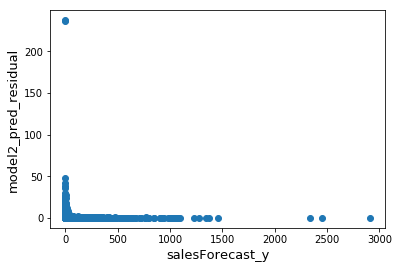

In [30]:
fig, ax = plt.subplots()
ax.scatter(x =df4.salesForecast_y, y = df4.model2_pred_mape)
plt.ylabel('model2_pred_mape', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

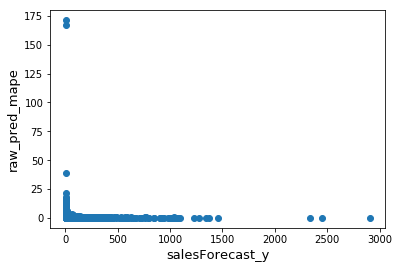

In [32]:
fig, ax = plt.subplots()
ax.scatter(x =df4.salesForecast_y, y = df4.raw_pred_mape)
plt.ylabel('raw_pred_mape', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

In [34]:
print df4.final_ensemble.sum()
print np.sum(np.abs(df4.final_ensemble - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

print df4.final_ensemble_2.sum()
print np.sum(np.abs(df4.final_ensemble_2 - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

#print df2.final_ensemble_3.sum()
#print np.sum(np.abs(df2.final_ensemble_3 - df2.salesForecast)) / np.sum(df2.salesForecast)
print "\n"
print df4.salesForecast_y.sum()
print df4.ypred_raw.sum()
print df4.model_2_ypred.sum()
print "\n"
print np.sum(np.abs(df4.ypred_raw - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)
print np.sum(np.abs(df4.model_2_ypred - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

223007.25821488842
0.3668618512866513
232331.41794975853
0.36877163899915044


251373
222224.36760477058
242438.46829474648


0.37911222635420433
0.385255627368478


In [63]:
cate3 = 7371

In [69]:
df4.shape

(10964, 11)

In [64]:
df4.head()

,RDCKey,ProductKey,model_2_ypred,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2,model2_pred_mape,raw_pred_mape,ensemble_mape
0,3.0,247046,6.729485,6.651096,7.605618,10,7.128161,7.167552,0.327051,0.239438,0.287184
1,3.0,247048,1.712392,1.615216,1.499655,1,1.582146,1.606023,0.712392,0.499655,0.582146
3,3.0,385612,302.197403,238.895996,279.539525,210,281.331853,290.868464,0.439035,0.331141,0.339675
4,3.0,385627,87.708409,89.256198,85.347943,60,84.629268,86.528176,0.461807,0.422466,0.410488
5,3.0,385632,30.696890,29.095059,29.409510,11,29.239728,30.053200,1.790626,1.673592,1.658157


In [98]:
df4.loc[df4.salesForecast_y<=30,['model2_pred_mape', 'raw_pred_mape', 'ensemble_mape']].mean()

model2_pred_mape    1.023528
raw_pred_mape       0.837696
ensemble_mape       0.882534
dtype: float64

In [78]:
sales_threshold = np.arange(0, 2000, 100)
tmp_list = []
for i in range(len(sales_threshold)):
    if i != len(sales_threshold)-1:
        tmp = df4[(sales_threshold[i]<df4.salesForecast_y)&(df4.salesForecast_y <= sales_threshold[i+1])]
        tmp_oneline_df = pd.DataFrame()
        tmp_oneline_df['cate3'] = [cate3]
        tmp_oneline_df['range_min'] = [sales_threshold[i]]
        tmp_oneline_df['range_max'] = [sales_threshold[i+1]]
        tmp_oneline_df['count_num'] = [tmp.shape[0]]
        tmp_oneline_df['sales_ratio_total'] = [float(tmp.salesForecast_y.sum()) / df4.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_sum'] = [tmp.ypred_raw.sum()]
        tmp_oneline_df['model_2_ypred_sum'] = [tmp.model_2_ypred.sum()]
        tmp_oneline_df['ensemble_sum'] = [tmp.final_ensemble.sum()]
        tmp_oneline_df['actual_sales_sum'] = [tmp.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_mape'] = [np.sum(np.abs(tmp.ypred_raw - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['model_2_ypred_mape'] = [np.sum(np.abs(tmp.model_2_ypred - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['ensemble_mape'] = [np.sum(np.abs(tmp.final_ensemble - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
    else:
        tmp = df4[(sales_threshold[i]<df4.salesForecast_y)]
        tmp_oneline_df = pd.DataFrame()
        tmp_oneline_df['cate3'] = [cate3]
        tmp_oneline_df['range_min'] = [sales_threshold[i]]
        tmp_oneline_df['range_max'] = [-999]
        tmp_oneline_df['count_num'] = [tmp.shape[0]]
        tmp_oneline_df['sales_ratio_total'] = [float(tmp.salesForecast_y.sum()) / df4.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_sum'] = [tmp.ypred_raw.sum()]
        tmp_oneline_df['model_2_ypred_sum'] = [tmp.model_2_ypred.sum()]
        tmp_oneline_df['ensemble_sum'] = [tmp.final_ensemble.sum()]
        tmp_oneline_df['actual_sales_sum'] = [tmp.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_mape'] = [np.sum(np.abs(tmp.ypred_raw - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['model_2_ypred_mape'] = [np.sum(np.abs(tmp.model_2_ypred - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['ensemble_mape'] = [np.sum(np.abs(tmp.final_ensemble - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
    tmp_list.append(tmp_oneline_df)
        
stat_df = pd.concat(tmp_list)          


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [79]:
stat_df.count_num.sum()

10964

In [81]:
stat_df.to_csv('./result_670/stat_df_7371.csv',index=False)

In [3]:
df4 = pd.read_csv('./result_670/stat_df_7371.csv')

In [4]:
df4

,cate3,range_min,range_max,count_num,sales_ratio_total,ypred_raw_sum,model_2_ypred_sum,ensemble_sum,actual_sales_sum,ypred_raw_mape,model_2_ypred_mape,ensemble_mape
0,7371,0,100,10455,0.431307,95690.320522,111824.364359,98499.383458,108419,0.536630,0.575582,0.526516
1,7371,100,200,281,0.158350,32652.342700,33077.621963,31451.500277,39805,0.366024,0.335821,0.345650
2,7371,200,300,99,0.096347,20260.755641,20523.055582,19495.164874,24219,0.288833,0.268603,0.277840
3,7371,300,400,43,0.058825,13047.632897,13218.379653,12724.333312,14787,0.257033,0.271359,0.263459
4,7371,400,500,29,0.050117,9798.110316,10936.852866,9990.924870,12598,0.276712,0.244825,0.262866
5,7371,500,600,17,0.037864,8343.052314,8792.918352,8350.492285,9518,0.218435,0.165455,0.190085
6,7371,600,700,5,0.012861,2949.449769,2882.389237,2823.604639,3233,0.203180,0.174222,0.188466
7,7371,700,800,8,0.023646,6573.638247,7492.329736,6918.422303,5944,0.202473,0.330816,0.257254
8,7371,800,900,3,0.009922,2220.428978,2264.683700,2160.359727,2494,0.109692,0.205320,0.148149
9,7371,900,1000,7,0.026129,6845.326091,7035.161981,6803.902096,6568,0.144750,0.135519,0.130018


In [86]:
df4_small = df4[df4.salesForecast_y<=100]
sales_threshold = np.arange(0, 100, 5)
tmp_list = []
for i in range(len(sales_threshold)):
    if i != len(sales_threshold)-1:
        tmp = df4_small[(sales_threshold[i]<df4_small.salesForecast_y)&(df4_small.salesForecast_y <= sales_threshold[i+1])]
        tmp_oneline_df = pd.DataFrame()
        tmp_oneline_df['cate3'] = [cate3]
        tmp_oneline_df['range_min'] = [sales_threshold[i]]
        tmp_oneline_df['range_max'] = [sales_threshold[i+1]]
        tmp_oneline_df['count_num'] = [tmp.shape[0]]
        tmp_oneline_df['sales_ratio_total'] = [float(tmp.salesForecast_y.sum()) / df4_small.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_sum'] = [tmp.ypred_raw.sum()]
        tmp_oneline_df['model_2_ypred_sum'] = [tmp.model_2_ypred.sum()]
        tmp_oneline_df['ensemble_sum'] = [tmp.final_ensemble.sum()]
        tmp_oneline_df['actual_sales_sum'] = [tmp.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_mape'] = [np.sum(np.abs(tmp.ypred_raw - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['model_2_ypred_mape'] = [np.sum(np.abs(tmp.model_2_ypred - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['ensemble_mape'] = [np.sum(np.abs(tmp.final_ensemble - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
    else:
        tmp = df4_small[(sales_threshold[i]<df4_small.salesForecast_y)]
        tmp_oneline_df = pd.DataFrame()
        tmp_oneline_df['cate3'] = [cate3]
        tmp_oneline_df['range_min'] = [sales_threshold[i]]
        tmp_oneline_df['range_max'] = [-999]
        tmp_oneline_df['count_num'] = [tmp.shape[0]]
        tmp_oneline_df['sales_ratio_total'] = [float(tmp.salesForecast_y.sum()) / df4_small.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_sum'] = [tmp.ypred_raw.sum()]
        tmp_oneline_df['model_2_ypred_sum'] = [tmp.model_2_ypred.sum()]
        tmp_oneline_df['ensemble_sum'] = [tmp.final_ensemble.sum()]
        tmp_oneline_df['actual_sales_sum'] = [tmp.salesForecast_y.sum()]
        tmp_oneline_df['ypred_raw_mape'] = [np.sum(np.abs(tmp.ypred_raw - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['model_2_ypred_mape'] = [np.sum(np.abs(tmp.model_2_ypred - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
        tmp_oneline_df['ensemble_mape'] = [np.sum(np.abs(tmp.final_ensemble - tmp.salesForecast_y)) / np.sum(tmp.salesForecast_y)]
    tmp_list.append(tmp_oneline_df)
        
stat_df_small = pd.concat(tmp_list)          


In [87]:
stat_df_small.to_csv('./result_670/stat_df_7371_small.csv',index=False)

In [88]:
stat_df_small

,cate3,range_min,range_max,count_num,sales_ratio_total,ypred_raw_sum,model_2_ypred_sum,ensemble_sum,actual_sales_sum,ypred_raw_mape,model_2_ypred_mape,ensemble_mape
0,7371,0,5,6182,0.125218,15616.029574,20231.423999,16904.516708,13576,0.835588,1.027943,0.886493
0,7371,5,10,1577,0.112702,10420.279954,12397.919080,10936.863013,12219,0.631394,0.667095,0.622597
0,7371,10,15,777,0.090916,8313.454976,9880.247636,8709.446561,9857,0.589993,0.641761,0.587436
0,7371,15,20,467,0.076767,7421.914077,8788.756342,7660.499901,8323,0.566652,0.616311,0.550288
0,7371,20,25,293,0.061640,5403.387790,6593.215672,5662.118877,6683,0.530454,0.590162,0.522150
0,7371,25,30,223,0.057241,4995.809162,5851.560197,5116.636349,6206,0.469024,0.493505,0.448382
0,7371,30,35,169,0.051347,4758.325718,5438.267567,4864.916147,5567,0.493294,0.509439,0.475594
0,7371,35,40,114,0.039864,3984.073907,4563.266561,4059.979697,4322,0.471631,0.492581,0.446760
0,7371,40,45,100,0.039375,3239.325731,3509.459574,3247.323004,4269,0.387441,0.346870,0.355524
0,7371,45,50,88,0.039154,3535.188591,3902.438649,3547.537717,4245,0.431179,0.429574,0.409045


In [ ]:
df4[['']]

In [59]:
df5 = df4[df4.salesForecast_y >= 100]
print df5.shape
print df4.shape
print df5.final_ensemble.sum()
print np.sum(np.abs(df5.final_ensemble - df5.salesForecast_y)) / np.sum(df5.salesForecast_y)

print df5.final_ensemble_2.sum()
print np.sum(np.abs(df5.final_ensemble_2 - df5.salesForecast_y)) / np.sum(df5.salesForecast_y)

#print df2.final_ensemble_3.sum()
#print np.sum(np.abs(df2.final_ensemble_3 - df2.salesForecast)) / np.sum(df2.salesForecast)
print "\n"
print df5.salesForecast_y.sum()
print float(df5.salesForecast_y.sum()) / df4.salesForecast_y.sum()
print df5.ypred_raw.sum()
print df5.model_2_ypred.sum()
print "\n"
print np.sum(np.abs(df5.ypred_raw - df5.salesForecast_y)) / np.sum(df5.salesForecast_y)
print np.sum(np.abs(df5.model_2_ypred - df5.salesForecast_y)) / np.sum(df5.salesForecast_y)

(516, 11)
(10964, 11)
125029.48287380257
0.24700085486527693
129124.41403052544
0.23963334557512464


143654
0.571477445867
127121.30001279499
131127.52804825592


0.2612920446642975
0.24219109505263592


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

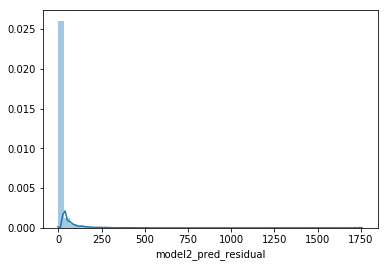

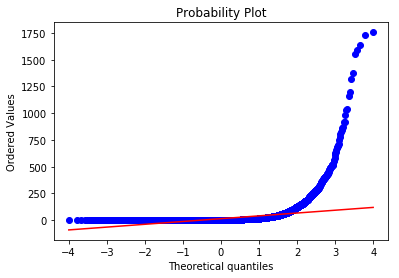

In [58]:
sns.distplot(df3['model2_pred_residual']);
fig = plt.figure()
res = stats.probplot(df3['model2_pred_residual'], plot=plt)


In [73]:
df3.describe()

,RDCKey,ProductKey,ypred,model_2_ypred,sales,salesForecast,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2,model2_pred_residual,raw_pred_residual,ensemble_residual
count,21481.000000,2.148100e+04,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000
mean,140.037568,3.842260e+06,10.834663,11.738066,11.993762,11.702109,10.818860,10.638342,11.702109,10.698146,11.188204,4.960188,4.729595,4.609598
std,259.633633,2.068688e+06,59.733222,63.025278,64.683694,61.898123,59.492530,61.821546,61.898123,60.814693,62.136044,16.341262,17.003589,15.599615
min,3.000000,2.470460e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025503,0.000000,0.000000,0.000000
25%,4.000000,1.615571e+06,0.137634,0.376624,0.000000,0.000000,0.148698,0.138590,0.000000,0.143703,0.277550,0.319076,0.138590,0.146590
50%,6.000000,4.331134e+06,0.800657,1.077541,1.000000,1.000000,0.844828,0.795745,1.000000,0.845617,0.914372,0.799926,0.699747,0.715365
75%,10.000000,5.720177e+06,3.635452,4.618884,4.000000,4.000000,3.975901,3.647596,4.000000,3.947642,4.142634,3.004846,2.692453,2.769571
max,772.000000,7.429953e+06,2680.637110,2994.259591,3118.000000,2908.000000,2822.719460,3108.443900,2908.000000,3041.086051,3051.351746,570.969820,700.714780,435.417673


In [81]:
df3['mape_raw'] = np.abs(df3.ypred_raw - df3.salesForecast_y) / df3.salesForecast_y
df3['mape_model2'] = np.abs(df3.model_2_ypred - df3.salesForecast_y) / df3.salesForecast_y

In [88]:
print df3[df3.mape_model2<=0.2].shape
print float(df3[df3.mape_model2<=0.2]['salesForecast_y'].sum()) /df3.salesForecast_y.sum()
print df3[df3.mape_model2<=0.3].shape
print float(df3[df3.mape_model2<=0.3]['salesForecast_y'].sum()) /df3.salesForecast_y.sum()

print df3[df3.mape_raw<=0.2].shape
print float(df3[df3.mape_raw<=0.2]['salesForecast_y'].sum()) /df3.salesForecast_y.sum()
print df3[df3.mape_raw<=0.3].shape
print float(df3[df3.mape_raw<=0.3]['salesForecast_y'].sum()) /df3.salesForecast_y.sum()

print df3.salesForecast_y.sum()

(2218, 13)
0.403790383215
(3233, 13)
0.552453923055
(2007, 13)
0.362159022648
(3016, 13)
0.526763017508
251373


In [74]:
print df3[df3.model2_pred_residual > df3.raw_pred_residual].shape
print df3[df3.model2_pred_residual <= df3.raw_pred_residual].shape
print df3.shape

(13812, 14)
(7669, 14)
(21481, 14)


In [75]:
df3.drop(['ypred','sales','salesForecast'],axis=1,inplace=True)

In [76]:
good = df3[df3.model2_pred_residual <= df3.raw_pred_residual]
bad = df3[df3.model2_pred_residual > df3.raw_pred_residual]

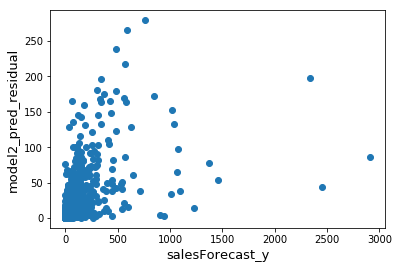

In [93]:
fig, ax = plt.subplots()
ax.scatter(x =good.salesForecast_y, y = good.model2_pred_residual)
plt.ylabel('model2_pred_residual', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

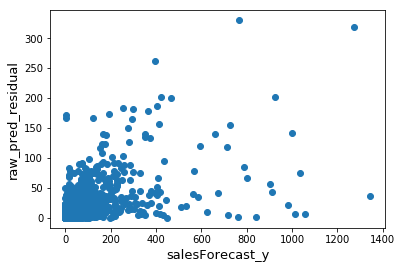

In [94]:
fig, ax = plt.subplots()
ax.scatter(x =bad.salesForecast_y, y = bad.raw_pred_residual)
plt.ylabel('raw_pred_residual', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

In [91]:
print good.salesForecast_y.max()
print bad.salesForecast_y.max()

2908
1343


In [92]:
df3[df3.salesForecast_y>=100].sort_values(by='salesForecast_y',ascending=False).head(20)

,RDCKey,ProductKey,model_2_ypred,ensemble,ypred_raw,salesForecast_y,final_ensemble,final_ensemble_2,model2_pred_residual,raw_pred_residual,ensemble_residual,mape_raw,mape_model2
431,3.0,1140673,2994.259591,2822.719460,3108.443900,2908,3041.086051,3051.351746,86.259591,200.443900,133.086051,0.068928,0.029663
13862,10.0,1140673,2498.539046,2401.553194,2359.201580,2455,2426.210503,2428.870313,43.539046,95.798420,28.789497,0.039022,0.017735
8464,6.0,1140673,2536.272881,2413.156723,3038.714780,2338,2711.476247,2787.493831,198.272881,700.714780,373.476247,0.299707,0.084804
38,3.0,603859,1403.781046,1336.712246,1290.319525,1457,1335.654464,1347.050286,53.218954,166.680475,121.345536,0.114400,0.036526
8343,6.0,1081963,1453.282583,1489.559939,1538.630064,1375,1490.774451,1495.956323,78.282583,163.630064,115.774451,0.119004,0.056933
310,3.0,1081963,1664.384742,1278.049583,1379.689000,1343,1504.173475,1522.036871,321.384742,36.689000,161.173475,0.027319,0.239304
10537,6.0,6410825,917.346153,903.359449,955.303387,1274,911.888094,936.324770,356.653847,318.696613,362.111906,0.250154,0.279948
65,3.0,642776,1241.390446,1261.140146,1326.285050,1227,1276.033414,1283.837748,14.390446,99.285050,49.033414,0.080917,0.011728
8904,6.0,2294966,1130.788466,1010.035641,1153.209594,1093,1133.090109,1141.999030,37.788466,60.209594,40.090109,0.055087,0.034573
37,3.0,603835,1172.968670,1217.574303,1317.775074,1075,1233.073529,1245.371872,97.968670,242.775074,158.073529,0.225837,0.091134


In [67]:
df4 = df3[df3.salesForecast_y>=30]

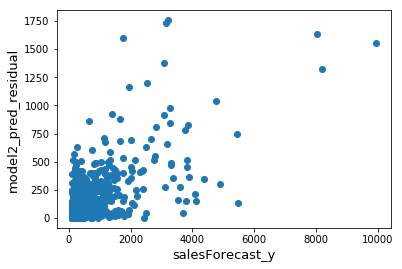

In [64]:
fig, ax = plt.subplots()
ax.scatter(x =df4.salesForecast_y, y = df4.model2_pred_residual)
plt.ylabel('model2_pred_residual', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

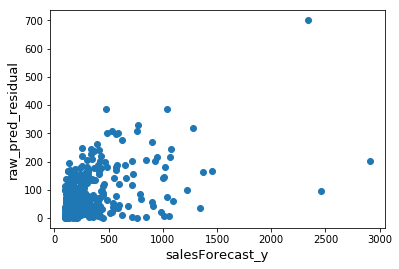

In [47]:
fig, ax = plt.subplots()
ax.scatter(x =df4.salesForecast_y, y = df4.raw_pred_residual)
plt.ylabel('raw_pred_residual', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

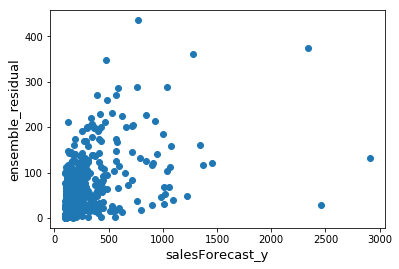

In [48]:
fig, ax = plt.subplots()
ax.scatter(x =df4.salesForecast_y, y = df4.ensemble_residual)
plt.ylabel('ensemble_residual', fontsize=13)
plt.xlabel('salesForecast_y', fontsize=13)
plt.show()

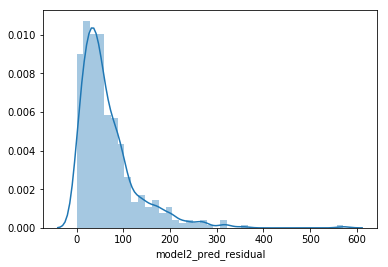

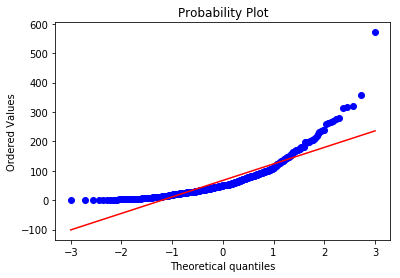

In [49]:
sns.distplot(df4['model2_pred_residual']);
fig = plt.figure()
res = stats.probplot(df4['model2_pred_residual'], plot=plt)

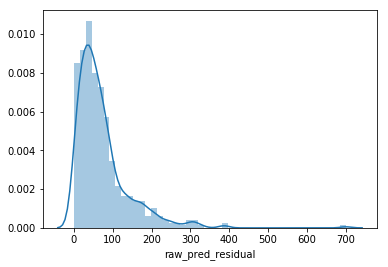

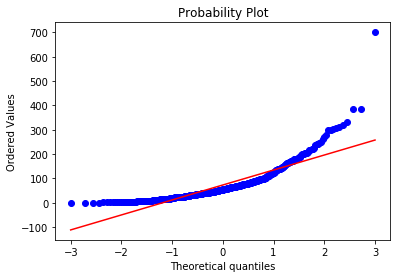

In [50]:
sns.distplot(df4['raw_pred_residual']);
fig = plt.figure()
res = stats.probplot(df4['raw_pred_residual'], plot=plt)

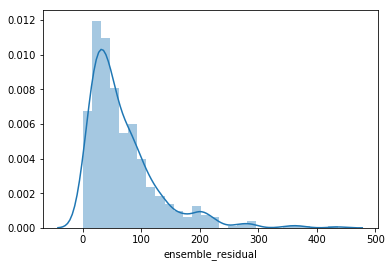

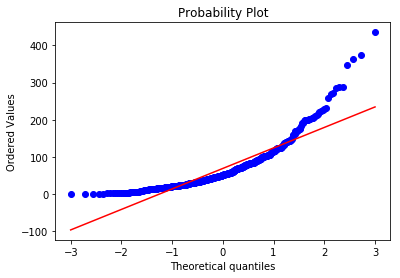

In [51]:
sns.distplot(df4['ensemble_residual']);
fig = plt.figure()
res = stats.probplot(df4['ensemble_residual'], plot=plt)

In [68]:
print df4.final_ensemble.sum()
print np.sum(np.abs(df4.final_ensemble - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

print df4.final_ensemble_2.sum()
print np.sum(np.abs(df4.final_ensemble_2 - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

#print df2.final_ensemble_3.sum()
#print np.sum(np.abs(df2.final_ensemble_3 - df2.salesForecast)) / np.sum(df2.salesForecast)
print "\n"
print df4.salesForecast_y.sum()
print df4.ypred_raw.sum()
print df4.model_2_ypred.sum()
print "\n"
print np.sum(np.abs(df4.ypred_raw - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)
print np.sum(np.abs(df4.model_2_ypred - df4.salesForecast_y)) / np.sum(df4.salesForecast_y)

814034.8429838088
0.262629142111751
849512.3468247696
0.2629165741721574


898490
832843.0964645164
866181.597185023


0.2889556026508293
0.27424135958845886


In [66]:
print df3.shape
print df4.shape

(21481, 11)
(1795, 11)


In [37]:
print df3.model2_pred_residual.sum()
print df3.raw_pred_residual.sum()
print df3.ensemble_residual.sum()

106549.79749584096
101596.43835156849
99018.78313427442


In [148]:
print "lgm pred sum:           %s"%final_result.model_2_ypred.sum()
print "actual sales sum:       %s"%final_result.salesForecast.sum()
print "bottom up pred sum:     %s"%final_result.ypred.sum()
print "ensemble pred sum:      %s"%final_result.ensemble.sum()

final_sku_rdc = final_result.groupby(['RDCKey','ProductKey']).sum().reset_index()
final_sku = final_result.groupby(['ProductKey']).sum().reset_index()
print "\nbottom up pred mape:\n"

print "daily_rdc_sku mape :%s"%(np.sum(np.abs(final_result.ypred - final_result.salesForecast)) / np.sum(final_result.salesForecast))
print "28days_rdc_sku mape:%s"%(np.sum(np.abs(final_sku_rdc.ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast))
print "28days_sku mape:    %s"%(np.sum(np.abs(final_sku.ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast))
print "\nlgm pred mape:\n"
print "daily_rdc_sku mape  :%s"%(np.sum(np.abs(final_result.model_2_ypred - final_result.salesForecast)) / np.sum(final_result.salesForecast))
print "28days_rdc_sku mape :%s"%(np.sum(np.abs(final_sku_rdc.model_2_ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast))
print "28days_sku mape     :%s"%(np.sum(np.abs(final_sku.model_2_ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast))
print "\nensemble pred mape:\n"
print "daily_rdc_sku mape  :%s"%(np.sum(np.abs(final_result.ensemble - final_result.salesForecast)) / np.sum(final_result.salesForecast))
print "28days_rdc_sku mape :%s"%(np.sum(np.abs(final_sku_rdc.ensemble - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast))
print "28days_sku mape     :%s"%(np.sum(np.abs(final_sku.ensemble - final_sku.salesForecast)) / np.sum(final_sku.salesForecast))

lgm pred sum:           61058.38974629441
actual sales pred sum:  49913.0
bottom up pred pred sum:57581.19
ensemble pred sum:      54425.41019669719

bottom up pred mape:

daily_rdc_sku mape :0.8057542038170936
28days_rdc_sku mape:0.4298976791658998
28days_sku mape:    0.3792427265562631

lgm pred mape:

daily_rdc_sku mape  :0.8139971854023952
28days_rdc_sku mape :0.4319781114967387
28days_sku mape     :0.3612977399483407

ensemble pred mape:

daily_rdc_sku mape  :0.7388314801381223
28days_rdc_sku mape :0.3444100998784615
28days_sku mape     :0.30498336973428014


In [180]:
result2 = final_result[final_result.Date<='2018-05-14']

print result2.model_2_ypred.sum()
print result2.salesForecast.sum()
print result2.ypred.sum()
print result2.ensemble.sum()

final_sku_rdc = result2.groupby(['RDCKey','ProductKey']).sum().reset_index()
final_sku = result2.groupby(['ProductKey']).sum().reset_index()

print np.sum(np.abs(result2.ypred - result2.salesForecast)) / np.sum(result2.salesForecast)
print np.sum(np.abs(final_sku_rdc.ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

print np.sum(np.abs(result2.model_2_ypred - result2.salesForecast)) / np.sum(result2.salesForecast)
print np.sum(np.abs(final_sku_rdc.model_2_ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.model_2_ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

print np.sum(np.abs(result2.ensemble - result2.salesForecast)) / np.sum(result2.salesForecast)
print np.sum(np.abs(final_sku_rdc.ensemble - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.ensemble - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

386979.61442904826
353955.0
312920.28
320854.73052179447
0.6221973253982767
0.401730627207566
0.28037285992501776
0.6192544957199012
0.3961479468583056
0.2540728292215213
0.5856877856905752
0.36357233691185026
0.24189731385176763


In [179]:
result3 = final_result[final_result.Date<='2018-05-21']

print result3.model_2_ypred.sum()
print result3.salesForecast.sum()
print result3.ypred.sum()
print result3.ensemble.sum()

final_sku_rdc = result3.groupby(['RDCKey','ProductKey']).sum().reset_index()
final_sku = result3.groupby(['ProductKey']).sum().reset_index()

print np.sum(np.abs(result3.ypred - result3.salesForecast)) / np.sum(result3.salesForecast)
print np.sum(np.abs(final_sku_rdc.ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

print np.sum(np.abs(result3.model_2_ypred - result3.salesForecast)) / np.sum(result3.salesForecast)
print np.sum(np.abs(final_sku_rdc.model_2_ypred - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.model_2_ypred - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

print np.sum(np.abs(result3.ensemble - result3.salesForecast)) / np.sum(result3.salesForecast)
print np.sum(np.abs(final_sku_rdc.ensemble - final_sku_rdc.salesForecast)) / np.sum(final_sku_rdc.salesForecast)
print np.sum(np.abs(final_sku.ensemble - final_sku.salesForecast)) / np.sum(final_sku.salesForecast)

768821.2473570952
659103.0
628273.9
642050.8492180129
0.6225258683742442
0.3586670960474832
0.2553152699682589
0.6592315955877557
0.3896289505990724
0.2729987668734885
0.5881977519053915
0.30941828048810543
0.2163505769698077
